In [236]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math as m
from datetime import datetime, timedelta
import numpy as np
import re
import random
import plotly.graph_objs as go
import plotly.express as px
import networkx as nx
import geopy.distance
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

-------------
# Lectura de tablas
## Pedidos

Empezamos con la tabla de pedidos:

In [ ]:
pedidos = pd.read_csv("Pedidos.csv", delimiter=';', encoding='cp1252')
pedidos

Busco aquellas columnas que solo contengan valores nulos (no son interesantes)

In [238]:
pedidos.count()

Id_Pedido            14337
NPedido              14337
NPedidoExt           14337
Fecha_Alta           14337
Fecha_Baja               0
Id_Tipo_Pedido           0
Estado               14337
NroPales             12948
Peso                 12948
VolumenM3            12948
TipoMercancia        12878
Gastos               12948
Fecha_Inicio         14337
Fecha_Fin            14337
Margen_Inicio        14337
Margen_Fin           14337
Fecha_Inicio_Real     6553
Fecha_Final_Real      3245
Fecha_Ult_Estado      6546
Ult_OT                4230
Via_Fin                 91
Id_Marca_Ini         14337
Id_Marca_Fin         14337
LineaPedido          12948
TipoTransporte       14330
ADR                  12948
ReferenciaCliente        4
ReferenciaFactura    10748
dtype: int64

El total de filas es:

In [239]:
pedidos.shape[0]

14337

Comprobación de calidad de datos de columnas de interés

In [240]:
frecuencias = pedidos['Gastos'].value_counts()

#Calcular el porcentaje de aparición de cada valor
porcentajes = frecuencias / len(pedidos) * 100

print(porcentajes)
print("Nulos: ", pedidos['Gastos'].isna().sum()/ len(pedidos) * 100)

Gastos
0.0    90.311781
Name: count, dtype: float64
Nulos:  9.688219292739067


De momento podemos descartar las columnas de Fecha_Baja y Id_Tipo_Pedido. Ahora voy a analizar qué variedad de valores pueden tomar algunas de las otras columnas:

In [241]:
NroPales = set(x for x in pedidos["NroPales"] if x == x) # No tengo en cuenta los nulos
pedidos["NroPales"].value_counts()

NroPales
1.0    12928
0.0       20
Name: count, dtype: int64

Vemos que esta columna no aporta mucho. Solo hay 0 o 1 palés. CONTINUAR CUANDO TENGA MÁS DATOS DE PEDIDOS

---------------------------
## Rutas

Leo los datos de las tablas que me interesan (Movimientos y RutasCalculadas)

In [ ]:
rc = pd.read_csv("RutasCalculadas.csv", delimiter=';', encoding='cp1252')
rc 

In [243]:
frecuencias = rc['DistanciaTotal'].value_counts()

#Calcular el porcentaje de aparición de cada valor
porcentajes = frecuencias / len(rc) * 100

print(porcentajes)
print("Nulos: ", rc['DistanciaTotal'].isna().sum()/ len(rc) * 100)

DistanciaTotal
0           0.137012
118,035     0.070868
320,174     0.056695
708,436     0.037796
1179,615    0.037796
              ...   
127,321     0.004725
955,11      0.004725
973,42      0.004725
117,673     0.004725
457,994     0.004725
Name: count, Length: 11817, dtype: float64
Nulos:  42.29424548804687


In [ ]:
mov = pd.read_csv("Movimientos.csv", delimiter=';', encoding='cp1252')
mov

In [ ]:
rc_av = pd.read_csv("RutasCalculadasAsignacionVehiculos.csv", delimiter=';', encoding='cp1252')
rc_av

In [246]:
frecuencias = rc_av['Fecha_Final_Real'].value_counts()

#Calcular el porcentaje de aparición de cada valor
porcentajes = frecuencias / len(rc_av) * 100

print(porcentajes)
print("Nulos: ", rc_av['Fecha_Final_Real'].isna().sum()/ len(rc_av) * 100)

Fecha_Final_Real
2024-01-27 12:33:47.000    0.044658
2024-03-25 20:00:00.000    0.033493
2024-03-25 20:02:59.000    0.022329
2024-02-07 15:01:15.000    0.022329
2023-10-26 10:00:23.303    0.022329
                             ...   
2024-01-24 07:27:25.000    0.011164
2024-01-24 04:10:08.000    0.011164
2024-01-24 17:07:58.000    0.011164
2024-01-23 19:11:58.000    0.011164
2024-04-05 15:58:11.000    0.011164
Name: count, Length: 8870, dtype: float64
Nulos:  0.8373339287707938


Ahora voy a comprobar aquellas rutas que no se han usado en movimientos:

In [247]:
rc_av_no_util = set(rc_av['Id_VR']) - set(mov['Id_VR'])
rc_av_no_util

{1, 2, 3, 4, 5, 6}

También aquellas rutas que supuestamente se han usado en movimientos, pero no se ve reflejado en la asignación al vehículo:

In [248]:
mov_no_util = set(mov['Id_VR']) - set(rc_av['Id_VR'])
mov_no_util

{-1,
 27,
 29,
 30,
 37,
 45,
 52,
 58,
 61,
 82,
 106,
 108,
 127,
 248,
 289,
 405,
 559,
 566,
 619,
 622,
 730,
 817,
 966,
 987,
 1098}

Elimino esos movimientos y asignaciones de rutas

In [249]:
print(mov.shape[0], rc_av.shape[0])
mov = mov.loc[mov["Id_VR"].isin(mov_no_util) == False]
rc_av = rc_av.loc[rc_av["Id_VR"].isin(rc_av_no_util) == False]
print(mov.shape[0], rc_av.shape[0])

8977 8957
8951 8951


Para analizar las rutas no tendré en cuenta las que no se han usado para asignaciones que fuesen útiles.

In [250]:
rutas_utiles = sorted(set(rc_av["IdRuta"]))
print(rutas_utiles)
rc = rc.loc[rc["IdRuta"].isin(rutas_utiles)]
rc.shape[0]

[1549, 1550, 1551, 1553, 1555, 1559, 1562, 1565, 1568, 1571, 1572, 1576, 1579, 1596, 1607, 1610, 1614, 1615, 1620, 1623, 1624, 1626, 1627, 1629, 1639, 1641, 1643, 1645, 1648, 1650, 1652, 1697, 1698, 1699, 1700, 1703, 1705, 1707, 1708, 1710, 1712, 1713, 1715, 1716, 1718, 1731, 1732, 1733, 1734, 1735, 1738, 1771, 1933, 1935, 1936, 1938, 1939, 1942, 1943, 1947, 1951, 1952, 1954, 2012, 2015, 2024, 2032, 2035, 2036, 2046, 2061, 2066, 2077, 2083, 2085, 2325, 2331, 2418, 2419, 2423, 2426, 2430, 2431, 2512, 2513, 2516, 2517, 2519, 2521, 2523, 2525, 2534, 2538, 2539, 2544, 2553, 2559, 2604, 2608, 2609, 2612, 2618, 2626, 2627, 2631, 2639, 2642, 2643, 2667, 2672, 2677, 2684, 2686, 2693, 2694, 2695, 2706, 2707, 2709, 2710, 2711, 2718, 2734, 2818, 2830, 2831, 2837, 2840, 2847, 2848, 2849, 2853, 2885, 2890, 2891, 2893, 2896, 2904, 2925, 2972, 2988, 2992, 2994, 2995, 2997, 2998, 2999, 3000, 3001, 3011, 3022, 3023, 3034, 3084, 3088, 3091, 3092, 3093, 3094, 3098, 3124, 3126, 3132, 3144, 3145, 3149, 315

8951

Voy a unir las tres tablas, pero antes voy a comprobar que por cada relación entre las 3 debería haber solo una fila (por ejemplo no se usa la misma ruta para varios vehículos y un movimiento se relaciona solo con una asignación de ruta a vehículo)

In [251]:
rc_av[rc_av.duplicated(subset='IdRuta')]

Empty DataFrame
Columns: [Id_VR, IdRuta, IdVehiculo, fecha_desde, fecha_hasta, NroSerie, Id_Caja, Matricula, notificacion_web, notificacion_api, notificacion_eventos, notificacion_email, observaciones, Fecha_Inicio_Real, Fecha_Final_Real, Estado, Ult_Parada, Fecha_Ult_Estado, MargenInferior, MargenSuperior, Pasajeros, RouteApproach, AlarmaETA, AlarmaPtoPer, AlarmaPtoNop]
Index: []

[0 rows x 25 columns]

In [252]:
mov[mov.duplicated(subset='Id_VR')]

Empty DataFrame
Columns: [Id_Movimiento, CodigoViaje, Id_Vehiculo, Matricula, Id_Conductor, Nombre_Conductor, Apellido1_Conductor, Apellido2_Conductor, Id_VR, Estado_Movimiento, Fecha_Alta, Fecha_Ult_Modif, LogPedidos, Telefono, Trunking, CodigoLinea, Transportista, MatriculaAux, DuracionTeorMinut, Id_CarrierRep, Id_SalesRep, Recepcion_Ot, Remolque, Id_Conductor2, Nombre_Conductor2, Apellido1_Conductor2, Apellido2_Conductor2, Comentarios]
Index: []

[0 rows x 28 columns]

Por último, compruebo que todas las rutas que tengo se usan asignándose a vehículos

In [253]:
rc_no_util = set(rc['IdRuta']) - set(rc_av['IdRuta'])
rc_no_util

set()

Ahora puedo unir las tres tablas.

In [254]:
rutas_asignacion = pd.merge(rc, rc_av, left_on='IdRuta', right_on='IdRuta')
print(rutas_asignacion.columns)
rutas_asignacion_mov = pd.merge(rutas_asignacion, mov, left_on='Id_VR', right_on='Id_VR')
rutas_asignacion_mov.columns

Index(['IdRuta', 'Nombre', 'TipoCalculo', 'VelocidadUrbana',
       'VelocidadNacional', 'VelocidadAutopista', 'VelocidadFerry',
       'TiempoTotal', 'DistanciaTotal', 'IdUser', 'Fecha_Alta', 'Fecha_Baja',
       'EvitarPeaje', 'EvitarAutopista', 'OptimizarPuntosRuta',
       'TipoMovimiento', 'MargenInferior_x', 'MargenSuperior_x',
       'ArranqueParada', 'ArranqueRuta', 'TipoCartografia', 'Id_VR',
       'IdVehiculo', 'fecha_desde', 'fecha_hasta', 'NroSerie', 'Id_Caja',
       'Matricula', 'notificacion_web', 'notificacion_api',
       'notificacion_eventos', 'notificacion_email', 'observaciones',
       'Fecha_Inicio_Real', 'Fecha_Final_Real', 'Estado', 'Ult_Parada',
       'Fecha_Ult_Estado', 'MargenInferior_y', 'MargenSuperior_y', 'Pasajeros',
       'RouteApproach', 'AlarmaETA', 'AlarmaPtoPer', 'AlarmaPtoNop'],
      dtype='object')


Index(['IdRuta', 'Nombre', 'TipoCalculo', 'VelocidadUrbana',
       'VelocidadNacional', 'VelocidadAutopista', 'VelocidadFerry',
       'TiempoTotal', 'DistanciaTotal', 'IdUser', 'Fecha_Alta_x', 'Fecha_Baja',
       'EvitarPeaje', 'EvitarAutopista', 'OptimizarPuntosRuta',
       'TipoMovimiento', 'MargenInferior_x', 'MargenSuperior_x',
       'ArranqueParada', 'ArranqueRuta', 'TipoCartografia', 'Id_VR',
       'IdVehiculo', 'fecha_desde', 'fecha_hasta', 'NroSerie', 'Id_Caja',
       'Matricula_x', 'notificacion_web', 'notificacion_api',
       'notificacion_eventos', 'notificacion_email', 'observaciones',
       'Fecha_Inicio_Real', 'Fecha_Final_Real', 'Estado', 'Ult_Parada',
       'Fecha_Ult_Estado', 'MargenInferior_y', 'MargenSuperior_y', 'Pasajeros',
       'RouteApproach', 'AlarmaETA', 'AlarmaPtoPer', 'AlarmaPtoNop',
       'Id_Movimiento', 'CodigoViaje', 'Id_Vehiculo', 'Matricula_y',
       'Id_Conductor', 'Nombre_Conductor', 'Apellido1_Conductor',
       'Apellido2_Conductor', '

In [255]:
rutas_asignacion_mov

IdRuta      Nombre TipoCalculo  VelocidadUrbana  VelocidadNacional  \
0       1549  VJ23023805         NaN              NaN                NaN   
1       1550  VJ23023810         NaN              NaN                NaN   
2       1551  VJ23023890         NaN              NaN                NaN   
3       1553  VJ23023860         NaN              NaN                NaN   
4       1555  VJ23023822         NaN              NaN                NaN   
...      ...         ...         ...              ...                ...   
8946   23433  VJ24015380         NaN              NaN                NaN   
8947   23435  VJ24015384         NaN              NaN                NaN   
8948   23438  VJ24015386         NaN              NaN                NaN   
8949   23441  VJ24015393         NaN              NaN                NaN   
8950   23443  VJ24015396         NaN              NaN                NaN   

      VelocidadAutopista  VelocidadFerry TiempoTotal DistanciaTotal  IdUser  \
0                    NaN             NaN         NaN            NaN     189   
1                    NaN             NaN         NaN            NaN     189   
2                    NaN             NaN         NaN            NaN     189   
3                    NaN             NaN         NaN            NaN     189   
4                    NaN             NaN         NaN            NaN     189   
...                  ...             ...         ...            ...     ...   
8946                 NaN             NaN         NaN            NaN     189   
8947                 NaN             NaN         NaN            NaN     189   
8948                 NaN             NaN         NaN            NaN     189   
8949                 NaN             NaN         NaN            NaN     189   
8950                 NaN             NaN         NaN            NaN     189   

      ... DuracionTeorMinut Id_CarrierRep  Id_SalesRep  Recepcion_Ot  \
0     ...                 0           NaN          NaN           NaN   
1     ...                 0           NaN          NaN           NaN   
2     ...                 0           NaN          NaN           NaN   
3     ...                 0           NaN          NaN           NaN   
4     ...                 0           NaN          NaN           NaN   
...   ...               ...           ...          ...           ...   
8946  ...                 0           NaN          NaN           NaN   
8947  ...                 0           NaN          NaN           NaN   
8948  ...                 0           NaN          NaN           NaN   
8949  ...                 0           NaN          NaN           NaN   
8950  ...                 0           NaN          NaN           NaN   

      Remolque  Id_Conductor2  Nombre_Conductor2  Apellido1_Conductor2  \
0     R4429BDJ            NaN                NaN                   NaN   
1     R4429BDJ         4128.0    MIRELA VASILICA                 LIPAN   
2     R0036BDG         1781.0             MILICA             BOCANEALA   
3     R0290BCZ            NaN      MARCO ANTONIO               CORDOVA   
4     R6485BCZ         3743.0              IONEL                 GROSU   
...        ...            ...                ...                   ...   
8946  R8097BCZ         3731.0               VERA               SPASOVA   
8947  R7467BDL         4575.0            FLORIN               BODORIN    
8948  R4209BCZ         4127.0                DAN                 LIPAN   
8949  R7468BDN         4034.0        ALDO ARTURO                  VEGA   
8950  R7469BDN         3027.0    ALBERT GHEORGHE                VAGNER   

      Apellido2_Conductor2  Comentarios  
0                      NaN          NaN  
1                      NaN          NaN  
2                      NaN          NaN  
3                    ORTIZ          NaN  
4                      NaN          NaN  
...                    ...          ...  
8946                   NaN          NaN  
8947                   NaN          NaN  
8948        

Analizaré las columnas de distancia y tiempo totales.

In [256]:
#fig,ax = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
#sns.boxplot(y=rutas_asignacion_mov['TiempoTotal'],ax=ax[0])
#sns.boxplot(y=rutas_asignacion_mov['DistanciaTotal'],ax=ax[1])
#fig.tight_layout(pad=2)

Bueno pues parece que todos los datos en rutas que se han usado tienen nulos estas columnas. Analizaré cuántos son.

In [257]:
rc_original = pd.read_csv('RutasCalculadas.csv', delimiter=';', encoding='cp1252')
dist_null_count = rc_original['DistanciaTotal'].isnull().sum()
time_null_count = rc_original['TiempoTotal'].isnull().sum()
print(dist_null_count,time_null_count)
print("Porcentaje de nulos:", round(dist_null_count*100/len(rc_original), 2))

8952 8952
Porcentaje de nulos: 42.29


---------------------

Estado_Movimiento
4    8141
5     715
3      65
1      56
Name: count, dtype: int64

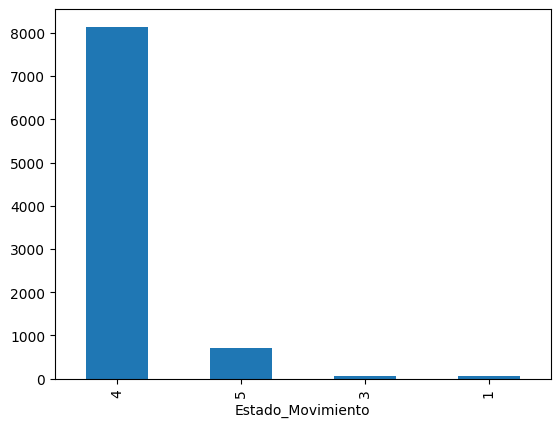

In [258]:
mov_original = pd.read_csv('Movimientos.csv', delimiter=';', encoding='cp1252')
mov_original['Estado_Movimiento'].value_counts().plot(kind='bar')
mov_original['Estado_Movimiento'].value_counts()

Estado
1    7716
4    3218
5    2861
6     232
7     167
8     143
Name: count, dtype: int64

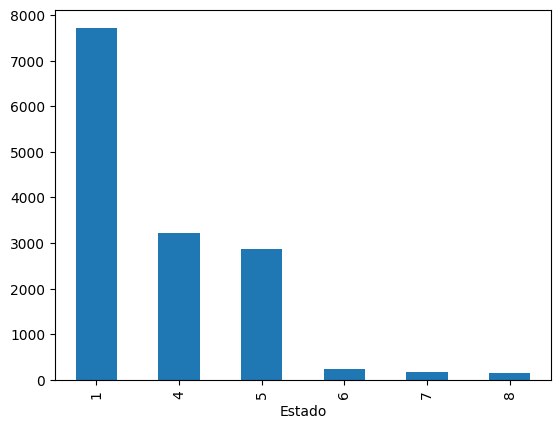

In [259]:
p = pd.read_csv('Pedidos.csv', delimiter=';', encoding='cp1252')
p['Estado'].value_counts().plot(kind='bar')
p['Estado'].value_counts()

In [260]:
pg = pd.read_csv('Pedidos_Grupos.csv', delimiter=';', encoding='cp1252')
pg

Id_Grupo  Id_Pedido  Id_PG
0             1          1      1
1             1          2      2
2             1          3      3
3             1          5      4
4             1          6      5
...         ...        ...    ...
14645        10      16565  14649
14646        10      16566  14650
14647        10      16567  14651
14648        10      16568  14652
14649        10      16569  14653

[14650 rows x 3 columns]

In [261]:
pg

Id_Grupo  Id_Pedido  Id_PG
0             1          1      1
1             1          2      2
2             1          3      3
3             1          5      4
4             1          6      5
...         ...        ...    ...
14645        10      16565  14649
14646        10      16566  14650
14647        10      16567  14651
14648        10      16568  14652
14649        10      16569  14653

[14650 rows x 3 columns]

In [262]:
p_no_util = set(p['Id_Pedido']) - set(pg['Id_Pedido'])
len(p_no_util)

1382

In [263]:
pg_no_util = set(pg['Id_Pedido']) - set(p['Id_Pedido'])
len(pg_no_util)

1695

In [264]:
len(pg)

14650

In [265]:
round(len(pg.loc[pg["Id_Pedido"].isin(pg_no_util) == True])*100/len(pg), 2)

11.57

In [266]:
mp = pd.read_csv('Movimientos_Pedidos.csv', delimiter=';', encoding='cp1252')
mp

Id_Movimiento  Id_Pedido  Id_MP
0                  1          1      1
1                  1          1      2
2                  2          1      3
3                  3          2      4
4                  3          2      5
...              ...        ...    ...
14905          10913      16548  17766
14906          10913      16538  17767
14907          10914      16549  17768
14908          10915      16550  17769
14909          10915      16498  17770

[14910 rows x 3 columns]

In [267]:
# Contar las apariciones de cada combinación
conteos = mp.groupby(['Id_Movimiento', 'Id_Pedido']).size().reset_index(name='counts')

# Filtrar los pares que tienen más de una aparición
duplicados = conteos[conteos['counts'] > 1]

# Contar el número de filas duplicadas
num_duplicates = duplicados['counts'].sum() - len(duplicados)

print(f"El número de filas duplicadas es: {num_duplicates}")
num_duplicates * 100 / len(mp)

El número de filas duplicadas es: 4626


31.026156941649898

In [268]:
mov_original.columns[mov_original.nunique() <= 3]
print(mov_original.columns)
print(len(mov_original.columns))

Index(['Id_Movimiento', 'CodigoViaje', 'Id_Vehiculo', 'Matricula',
       'Id_Conductor', 'Nombre_Conductor', 'Apellido1_Conductor',
       'Apellido2_Conductor', 'Id_VR', 'Estado_Movimiento', 'Fecha_Alta',
       'Fecha_Ult_Modif', 'LogPedidos', 'Telefono', 'Trunking', 'CodigoLinea',
       'Transportista', 'MatriculaAux', 'DuracionTeorMinut', 'Id_CarrierRep',
       'Id_SalesRep', 'Recepcion_Ot', 'Remolque', 'Id_Conductor2',
       'Nombre_Conductor2', 'Apellido1_Conductor2', 'Apellido2_Conductor2',
       'Comentarios'],
      dtype='object')
28


In [269]:
p.columns[p.nunique() <= 4]

Index(['Fecha_Baja', 'Id_Tipo_Pedido', 'NroPales', 'Peso', 'VolumenM3',
       'TipoMercancia', 'Gastos', 'Via_Fin', 'LineaPedido', 'TipoTransporte',
       'ADR', 'ReferenciaCliente'],
      dtype='object')

In [270]:
rc.columns[rc.nunique() <= 1]

Index(['TipoCalculo', 'VelocidadUrbana', 'VelocidadNacional',
       'VelocidadAutopista', 'VelocidadFerry', 'TiempoTotal', 'DistanciaTotal',
       'Fecha_Baja', 'EvitarPeaje', 'EvitarAutopista', 'OptimizarPuntosRuta',
       'TipoMovimiento', 'ArranqueParada', 'ArranqueRuta', 'TipoCartografia'],
      dtype='object')

In [271]:
rc_av.columns[rc_av.nunique() <= 1]

Index(['notificacion_web', 'notificacion_api', 'notificacion_eventos',
       'notificacion_email', 'observaciones', 'Pasajeros', 'RouteApproach',
       'AlarmaETA', 'AlarmaPtoPer', 'AlarmaPtoNop'],
      dtype='object')

In [272]:
v = pd.read_csv('Vehiculos.csv', delimiter=';', encoding='cp1252')
v.columns[v.nunique() <= 2]


Index(['Modelo', 'Icono', 'Bastidor', 'Cilindrada', 'Color', 'Garaje',
       'Fecha_Compra', 'Tara', 'PMA', 'Longitud', 'Ejes', 'Equipo_Frio',
       'IdSuspension', 'IdTipoMotor', 'IdMarca', 'Id_Tipo_General',
       'Desfase_Kilometrico', 'P1Nombre', 'P1Valor', 'P2Nombre', 'P2Valor',
       'P3Nombre', 'P3Valor', 'P4Nombre', 'P4Valor', 'P5Nombre', 'P5Valor',
       'P6Nombre', 'P6Valor', 'CodigoV', 'Id_Taller_Asociado',
       'Id_CentroCoste', 'Id_Ubicacion', 'Id_Responsable', 'ValorAdquisicion',
       'ImportePlataforma', 'Id_Gestion', 'FechaMatriculacion',
       'DuracionContrato', 'KmIniciales', 'KmAnualPrevisto', 'ImporteSeguro',
       'Id_CoberturaSeguro', 'Id_JefeTrafico', 'Cubicaje', 'Rampa',
       'Fecha_Recepcion', 'CosteMensual', 'Desfase_Horometro', 'Carrocero',
       'Desfase_Kilometrico_CAN', 'DescargaParado', 'VIN', 'Enlace'],
      dtype='object')

In [273]:
c = pd.read_csv('Conductores.csv', delimiter=';', encoding='cp1252')
c.columns[c.nunique() <= 2]

Index(['Codigo_Pin', 'Apodo', 'Fecha_Carnet', 'Id_Tipo_Carnet',
       'Fecha_Nacimiento', 'Telefono1', 'Telefono2', 'Direccion',
       'Fecha_Inicio_Contrato', 'Fecha_Fin_Contrato', 'Tipo_Contrato',
       'P1Nombre', 'P1Valor', 'P2Nombre', 'P2Valor', 'P3Nombre', 'P3Valor',
       'P4Nombre', 'P4Valor', 'P5Nombre', 'P5Valor', 'P6Nombre', 'P6Valor',
       'Matr_remolque', 'ip', 'versionSoft', 'numSerie', 'id_remolque',
       'Login', 'Id_Tipo_Operador', 'CodigoiButton', 'Email'],
      dtype='object')

In [274]:
vc = pd.read_csv('Vehiculos_Conductores2.csv', delimiter=';', encoding='cp1252')
vc.columns[vc.nunique() <= 1]

Index(['Id_User_Resp'], dtype='object')

In [275]:
rce12 = pd.read_csv('RutasCalculadasEventos_2023_12.csv', delimiter=';', encoding='cp1252')
rce12 = rce12.loc[rce12["Id_Ruta"].isin(rutas_utiles)]
rce11 = pd.read_csv('RutasCalculadasEventos_2023_11.csv', delimiter=';', encoding='cp1252')
rce11 = rce11.loc[rce11["Id_Ruta"].isin(rutas_utiles)]
rce10 = pd.read_csv('RutasCalculadasEventos_2023_10.csv', delimiter=';', encoding='cp1252')
rce10 = rce10.loc[rce10["Id_Ruta"].isin(rutas_utiles)]
rce12

Id_Ruta_Evento  Id_VR  Id_Ruta  Id_Vehiculo               Fecha_Hora  \
0                   1   1700     7458         1852  2023-12-01 00:01:50.000   
1                   2   1625     7310         2141  2023-12-01 00:02:11.000   
2                   3   1592     7233         2136  2023-12-01 00:02:59.000   
3                   4   1592     7233         2136  2023-12-01 00:02:59.000   
4                   5   1697     7451         2024  2023-12-01 00:03:54.000   
...               ...    ...      ...          ...                      ...   
12991           12992   2412     9183         1939  2023-12-31 10:16:19.000   
12992           12993   2412     9183         1939  2023-12-31 10:24:25.000   
12993           12994   2412     9183         1939  2023-12-31 11:04:27.000   
12994           12995   2397     9135         2017  2023-12-31 11:30:47.000   
12995           12996   2375     9079         1583  2023-12-31 13:02:59.000   

       Evento    Extra  Extra2   Latitud  Longitud     Extra3  
0           4      0.0       0  48,72365    2,3025  484917.46  
1           2      0.0       1  43,67828   3,40506   60829.40  
2           6  24201.0     123  52,29298   4,76412   59127.76  
3           5  24201.0       0  52,29298   4,76412   59127.76  
4           3      0.0       0  50,32515   2,91245        NaN  
...       ...      ...     ...       ...       ...        ...  
12991       3      0.0       0  49,52352   2,72351  243605.45  
12992       4      0.0       0   49,5379    2,7263  243607.33  
12993       3      0.0       0   50,0444   2,92556  243667.17  
12994       2      0.0       1  40,53102  -3,31976        NaN  
12995       2      0.0       1  42,72914  -1,61496        NaN  

[12763 rows x 11 columns]

Obtener distancias y tiempo entre salidas y vueltas a ruta

In [276]:
def dist(lat1, lon1, lat2, lon2):
    # Radio aproximado de la tierra en m
    R = 6371
    lat1 = m.radians(float(lat1.replace(",",".")))
    lon1 = m.radians(float(lon1.replace(",",".")))
    lat2 = m.radians(float(lat2.replace(",",".")))
    lon2 = m.radians(float(lon2.replace(",",".")))
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = m.sin(dlat / 2)**2 + m.cos(lat1) * m.cos(lat2) * m.sin(dlon / 2)**2
    c = 2 * m.atan2(m.sqrt(a), m.sqrt(1 - a))

    distancia = R * c
    return distancia

def calcular_diferencia_en_minutos(fecha1_str, fecha2_str):
    formato = "%Y-%m-%d %H:%M:%S.%f"

    fecha1 = datetime.strptime(fecha1_str, formato)
    fecha2 = datetime.strptime(fecha2_str, formato)

    diferencia = fecha2 - fecha1
    diferencia_en_minutos = diferencia.total_seconds() / 60

    return round(diferencia_en_minutos,2)


In [277]:
a = []
def calculoExtremosDT(rce : pd.DataFrame):
    global a
    salida_vuelta_ruta = dict()
    for ruta in rutas_utiles:
        ruta_actual = rce.loc[rce["Id_Ruta"] == ruta]
        salida = pd.Series()
        distancias = list()
        tiempos = list()
        mind, maxd, mint, maxt = None, None, None, None
        for i in range(len(ruta_actual)):
            actual = ruta_actual.iloc[i]
            if actual["Evento"] == 3 and salida.empty:
                salida = actual
            if actual["Evento"] == 4 and not salida.empty:
                distancias.append(geopy.distance.geodesic((actual["Latitud"].replace(',', '.'), actual["Longitud"].replace(',', '.')), 
                                                          (salida["Latitud"].replace(',', '.'), salida["Longitud"].replace(',', '.'))).km)
                tiempos.append(calcular_diferencia_en_minutos(salida["Fecha_Hora"], actual["Fecha_Hora"]))
                if calcular_diferencia_en_minutos(salida["Fecha_Hora"], actual["Fecha_Hora"]) > 4000:
                    a.append(ruta_actual)
                salida = pd.Series()
        tiempos.sort()
        distancias.sort()
        mediat = sum(tiempos)/len(tiempos) if len(tiempos) != 0 else None
        mediad = sum(distancias)/len(distancias) if len(distancias) != 0 else None
        if len(distancias) > 0:
            mind = distancias[0]
            maxd = distancias[-1]
            mint = tiempos[0]
            maxt = tiempos[-1]
        salida_vuelta_ruta[ruta] = {"mind": mind, "maxd": maxd, "mint": mint, "maxt": maxt, "mediad": mediad, "mediat": mediat}
    return salida_vuelta_ruta


Extremos en rutas de diciembre:

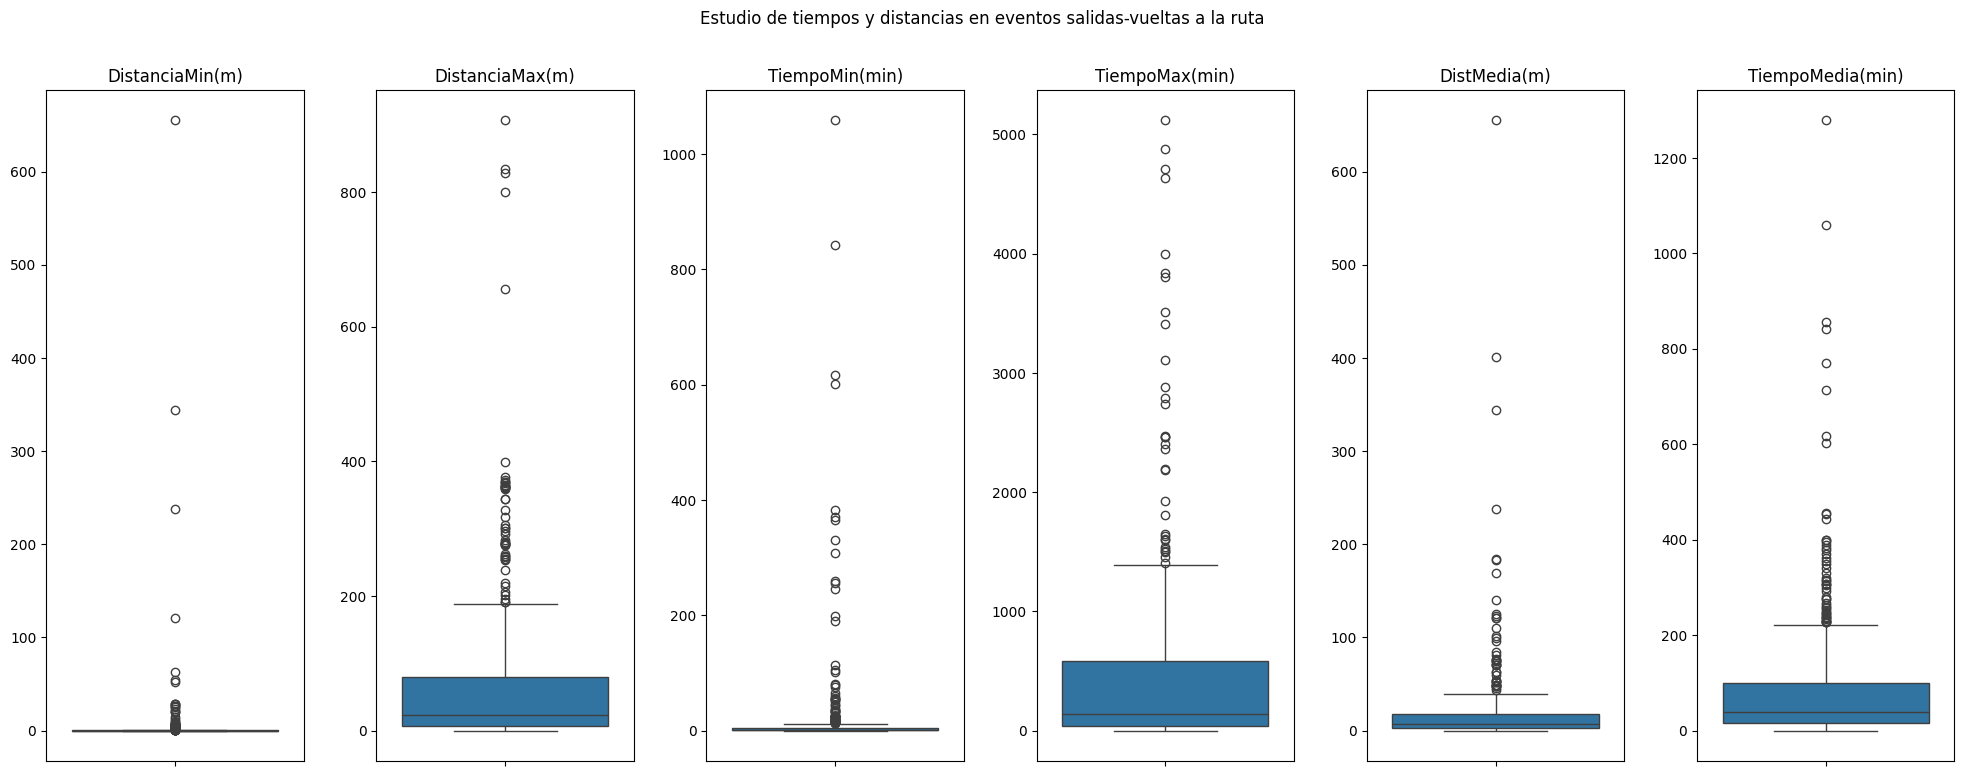

In [278]:
dibujos = [list(), list(), list(), list(), list(), list()]
titulos = ["DistanciaMin(m)", "DistanciaMax(m)", "TiempoMin(min)", "TiempoMax(min)", "DistMedia(m)", "TiempoMedia(min)"]
salida_vuelta_ruta = calculoExtremosDT(rce12)
for ruta, datos in salida_vuelta_ruta.items():
    dibujos[0].append(datos["mind"]) # minimosd
    dibujos[1].append(datos["maxd"]) # maximosd
    dibujos[2].append(datos["mint"]) # minimost
    dibujos[3].append(datos["maxt"]) # maximost
    dibujos[4].append(datos["mediad"]) # minimosd
    dibujos[5].append(datos["mediat"]) # minimosd

fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(20,8))
i = 0
for dato in range(len(dibujos)):
    sns.boxplot(y=dibujos[dato],ax=ax[i]).set_title(titulos[dato])
    i += 1

fig.suptitle("Estudio de tiempos y distancias en eventos salidas-vueltas a la ruta")
fig.tight_layout(pad=2)

Extremos en rutas de noviembre:

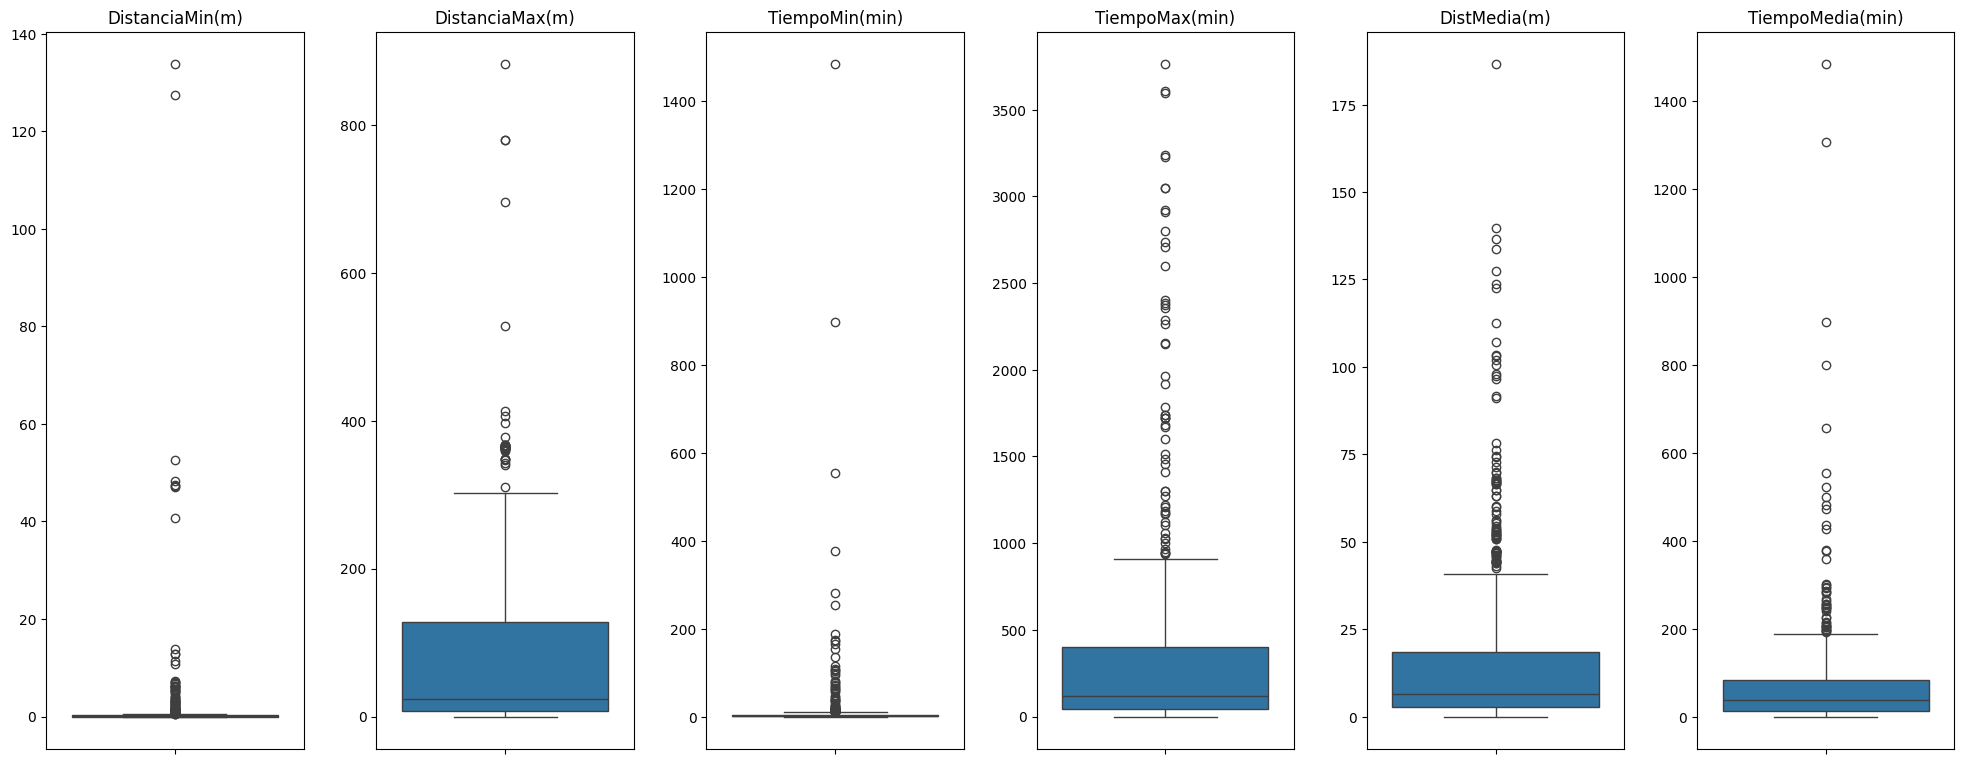

In [279]:
dibujos = [list(), list(), list(), list(), list(), list()]
titulos = ["DistanciaMin(m)", "DistanciaMax(m)", "TiempoMin(min)", "TiempoMax(min)", "DistMedia(m)", "TiempoMedia(min)"]
salida_vuelta_ruta = calculoExtremosDT(rce11)
for ruta, datos in salida_vuelta_ruta.items():
    dibujos[0].append(datos["mind"]) # minimosd
    dibujos[1].append(datos["maxd"]) # maximosd
    dibujos[2].append(datos["mint"]) # minimost
    dibujos[3].append(datos["maxt"]) # maximost
    dibujos[4].append(datos["mediad"]) # minimosd
    dibujos[5].append(datos["mediat"]) # minimosd

fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(20,8))
i = 0
for dato in range(len(dibujos)):
    sns.boxplot(y=dibujos[dato],ax=ax[i]).set_title(titulos[dato])
    i += 1
fig.tight_layout(pad=2)

Eventos de rutas en octubre:

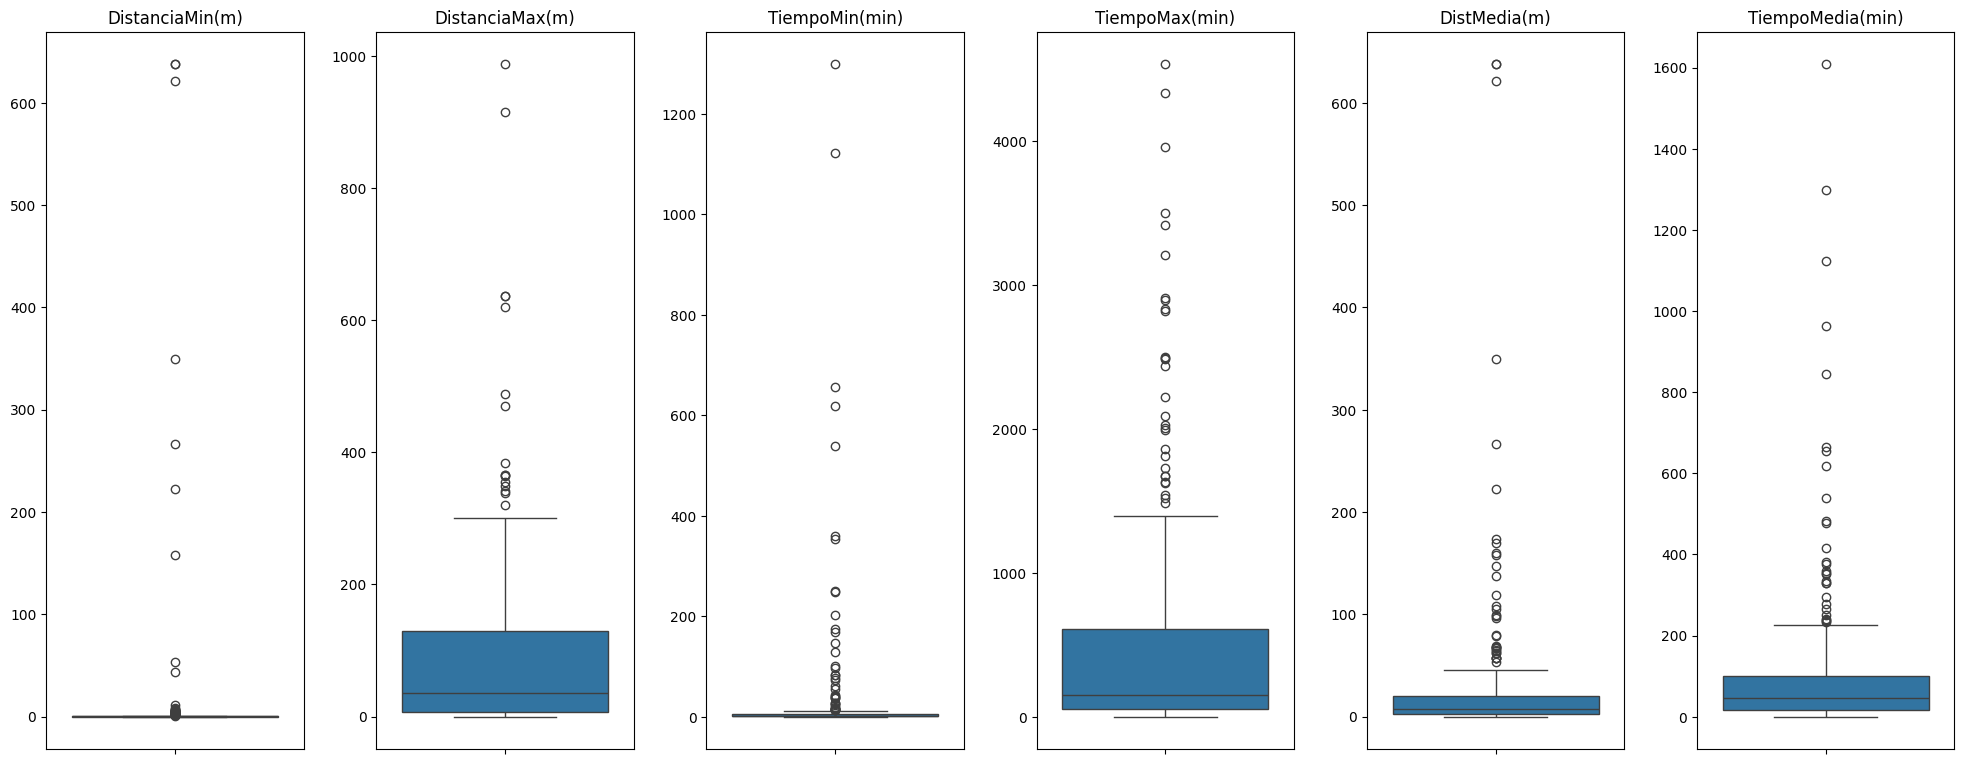

In [280]:
dibujos = [list(), list(), list(), list(), list(), list()]
titulos = ["DistanciaMin(m)", "DistanciaMax(m)", "TiempoMin(min)", "TiempoMax(min)", "DistMedia(m)", "TiempoMedia(min)"]
salida_vuelta_ruta = calculoExtremosDT(rce10)
for ruta, datos in salida_vuelta_ruta.items():
    dibujos[0].append(datos["mind"]) # minimosd
    dibujos[1].append(datos["maxd"]) # maximosd
    dibujos[2].append(datos["mint"]) # minimost
    dibujos[3].append(datos["maxt"]) # maximost
    dibujos[4].append(datos["mediad"]) # minimosd
    dibujos[5].append(datos["mediat"]) # minimosd

fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(20,8))
i = 0
for dato in range(len(dibujos)):
    sns.boxplot(y=dibujos[dato],ax=ax[i]).set_title(titulos[dato])
    i += 1
fig.tight_layout(pad=2)

--------------------------------------------------------------
# Dataset de trabajo

In [ ]:
df = pd.read_csv('Pedidos-Movimientos-RutasCalculadas-RutasCalculadasPuntos.csv', delimiter=';', encoding='cp1252')
df

Selección de atributos útiles

In [ ]:
df = df[["Id_Pedido", "NPedido", "Estado", "Id_Marca_Ini", "Id_Marca_Fin", # Referente a Pedidos
         "Id_Movimiento", "CodigoViaje", "Id_Vehiculo", "Matricula", # Referente a Movimientos
         "Id_Conductor", "Nombre_Conductor", "Apellido1_Conductor", "Apellido2_Conductor",
         "Id_Conductor2", "Nombre_Conductor2", "Apellido1_Conductor2", "Apellido2_Conductor2", "Estado_Movimiento",
         "IdRuta", "Nombre", # Referente a RutasCalculadas
         "IdPunto", "Nombre.1", "Latitud", "Longitud", "Parada", "Tiempo", "Distancia", "Id_Marca" # Referente a RutasCalculadasPuntos
         ]]
df

In [283]:
print(len(set(df["Id_Pedido"])))
print(len(set(df["Id_Movimiento"])))
print(len(set(df["IdRuta"])))

7649
8694
8694


In [284]:
def numMovimientos(dataFrame : pd.DataFrame):
    return len(set(dataFrame["Id_Movimiento"]))
def numParadas(dataFrame : pd.DataFrame):
    return len(dataFrame.loc[dataFrame["Parada"] == 1])
def numPuntos(dataFrame : pd.DataFrame):
    return len(set(dataFrame["IdPunto"]))  
def distReal(dataFrame : pd.DataFrame):
    return dataFrame["Distancia"].max()/1000
def tiempoEstimadoS(dataFrame : pd.DataFrame):
    return dataFrame["Tiempo"].max() / 60

In [285]:
ids_pedidos = set(df["Id_Pedido"])
ids_rutas = set(df["IdRuta"])
movimientos = dict()
paradas = dict()
puntos = dict()
distancias = dict()
tiemposEstimado = dict()
for id in ids_pedidos:
    filtrado = df.loc[df["Id_Pedido"] == id]
    movimientos[id] = numMovimientos(filtrado)
for id in ids_rutas:
    filtrado = df.loc[df["IdRuta"] == id]
    # por si se usa la ruta en varios pedidos
    pedidos = list(filtrado["Id_Pedido"])
    filtrado = filtrado[filtrado["Id_Pedido"] == pedidos[0]]
    paradas[id] = numParadas(filtrado)
    puntos[id] = numPuntos(filtrado)
    distancias[id] = distReal(filtrado)
    tiemposEstimado[id] = tiempoEstimadoS(filtrado)


In [ ]:
for i in df.index:
    df.at[i, "NumMovimientos"] = movimientos[df.at[i, "Id_Pedido"]]
    df.at[i, "NumParadas"] = paradas[df.at[i, "IdRuta"]]
    df.at[i, "NumPuntos"] = puntos[df.at[i, "IdRuta"]]
    df.at[i, "DistanciaReal_km"] = distancias[df.at[i, "IdRuta"]]
    df.at[i, "TiempoEstimadoSis_h"] = tiemposEstimado[df.at[i, "IdRuta"]]
    df.at[i, "NumConductores"] = 1 if np.isnan(df.at[i, "Id_Conductor2"]) else 2
df


In [287]:
df.loc[df['DistanciaReal_km'].isnull()]

Id_Pedido     NPedido  Estado  Id_Marca_Ini  Id_Marca_Fin  \
1312         794  PT23026621       1          5910          5911   
1313         794  PT23026621       1          5910          5911   
7632        4826  PT23034877       5          2838          4467   
7633        4826  PT23034877       5          2838          4467   
46976      15432  PT24009438       4          2838          7744   
46977      15432  PT24009438       4          2838          7744   

       Id_Movimiento CodigoViaje  Id_Vehiculo Matricula  Id_Conductor  ...  \
1312             239  VJ23039881         1585  2690LRJ              0  ...   
1313             239  VJ23039881         1585  2690LRJ              0  ...   
7632            1506  VJ23052065         1596   5837LRC             0  ...   
7633            1506  VJ23052065         1596   5837LRC             0  ...   
46976           9814  VJ24013590         1998   3911MDG             0  ...   
46977           9814  VJ24013590         1998   3911MDG             0  ...   

      Parada  Tiempo Distancia  Id_Marca NumMovimientos NumParadas NumPuntos  \
1312       1     NaN       NaN    5910.0            1.0        2.0       2.0   
1313       1     NaN       NaN    5911.0            1.0        2.0       2.0   
7632       1     0.0       NaN    2838.0            1.0        2.0       2.0   
7633       1   660.0       NaN    4467.0            1.0        2.0       2.0   
46976      1     0.0       NaN    2838.0            1.0        2.0       2.0   
46977      1  1800.0       NaN    7744.0            1.0        2.0       2.0   

       DistanciaReal_km  TiempoEstimadoSis_h NumConductores  
1312                NaN                  NaN            1.0  
1313                NaN                  NaN            1.0  
7632                NaN                 11.0            1.0  
7633                NaN                 11.0            1.0  
46976               NaN                 30.0            1.0  
46977               NaN                 30.0            1.0  

[6 rows x 34 columns]

Hay 2 pedidos en los que no se ha indicado la distancia entre sus puntos.

In [288]:
c = Counter(list(movimientos.values()))
c

Counter({1: 5872, 2: 1307, 3: 420, 4: 38, 5: 11, 7: 1})

Text(0, 0.5, 'Frecuencia')

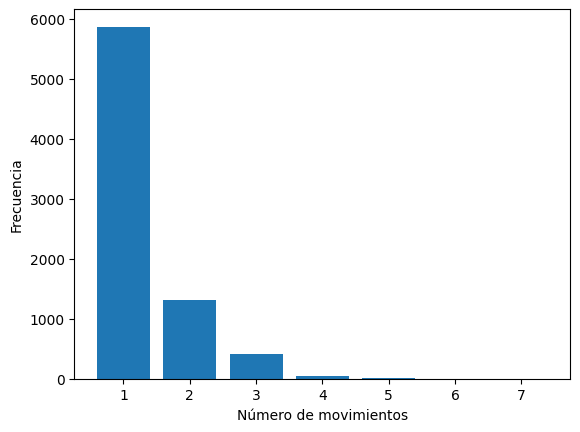

In [289]:
plt.bar(c.keys(), c.values())
plt.xlabel("Número de movimientos")
plt.ylabel("Frecuencia")

In [290]:
c = Counter(list(paradas.values()))
c

Counter({3: 3794,
         2: 3560,
         4: 831,
         5: 239,
         6: 101,
         7: 50,
         8: 30,
         9: 28,
         10: 15,
         11: 9,
         12: 9,
         1: 8,
         13: 7,
         15: 4,
         14: 4,
         17: 3,
         16: 1,
         24: 1})

<BarContainer object of 18 artists>

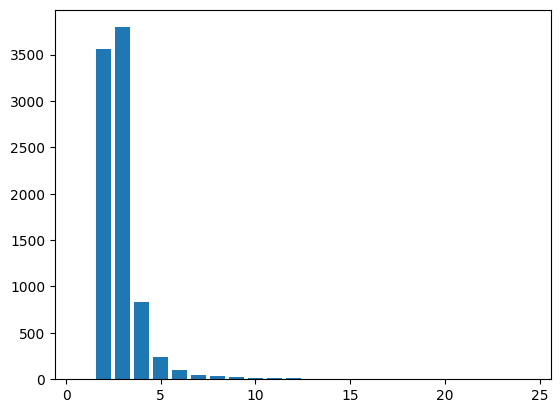

In [291]:
plt.bar(c.keys(), c.values())

In [292]:
c = Counter(list(puntos.values()))
c

Counter({4: 1521,
         3: 1447,
         5: 1221,
         7: 1129,
         6: 1047,
         2: 1043,
         8: 515,
         9: 285,
         10: 161,
         11: 107,
         12: 97,
         13: 45,
         15: 14,
         14: 14,
         16: 10,
         21: 8,
         1: 8,
         17: 5,
         18: 5,
         25: 5,
         20: 4,
         23: 2,
         30: 1})

<BarContainer object of 23 artists>

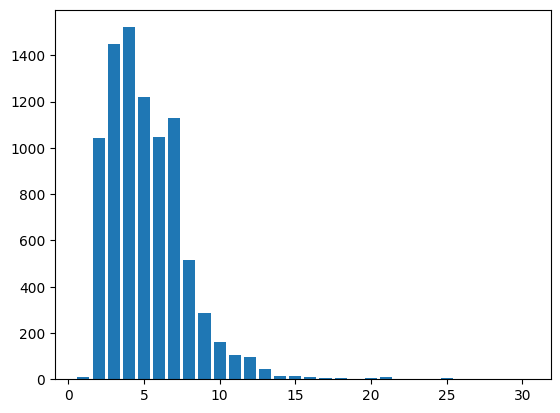

In [293]:
plt.bar(c.keys(), c.values())

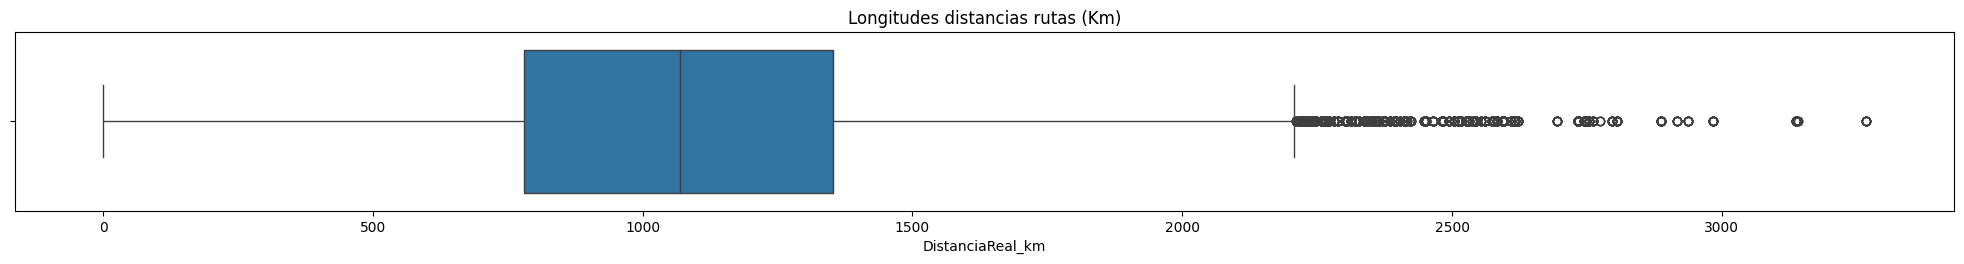

In [294]:
fig, ax = plt.subplots(figsize=(20,3))
sns.boxplot(x=df['DistanciaReal_km'], ax=ax).set_title("Longitudes distancias rutas (Km)")
plt.ticklabel_format(style='plain', axis='x')
fig.tight_layout(pad=2)

Compruebo pedidos que tengan rutas en común y sean versiones vacías

In [295]:
def tiene_pareja_vacio(valores):
    # Patrón de expresión regular para buscar el string seguido de "_vacio"
    patron = re.compile(r'(.*)_vacio')
    
    # Extraer solo los strings únicos (sin duplicados)
    unicos = set(valores)
    
    # Verificar si existe al menos una pareja de un string y otro añadiendo "_vacio"
    for valor in unicos:
        match = patron.match(valor)
        if match:
            # Si la versión con "_vacio" está presente en la lista, devuelve True
            if match.group(1) in unicos:
                return True
    return False

In [296]:
contadorMismasRutas = 0
for ruta in set(df["IdRuta"]):
    filtro = df[df["IdRuta"] == ruta]
    if tiene_pareja_vacio(set(filtro["NPedido"])):
        contadorMismasRutas += 1
print(contadorMismasRutas)
numRutas = len(set(df["IdRuta"]))
print(numRutas)
porcentaje = round(contadorMismasRutas * 100 / numRutas, 2)
print(str(porcentaje) + "%")


1266
8694
14.56%


Cluster por distancia

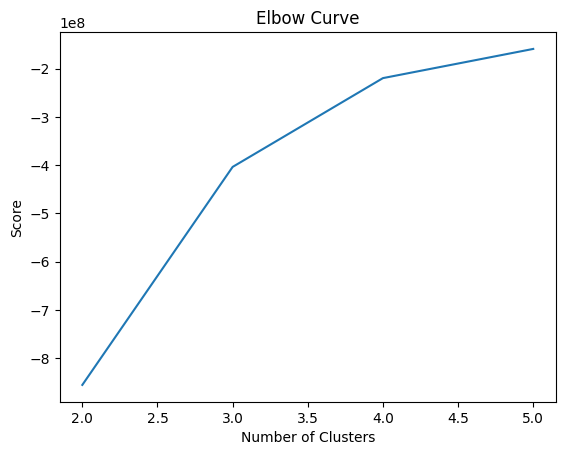

In [297]:
Nc = range(2, 6)
X = df.drop_duplicates(subset='IdRuta')['DistanciaReal_km']
X = X.dropna().values.reshape(-1, 1)
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [298]:
# Elijo usar 3 clusters
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 948.18824492]
 [ 279.14998588]
 [1563.3433272 ]]


Text(0, 0.5, 'Distancia de la ruta (Km)')

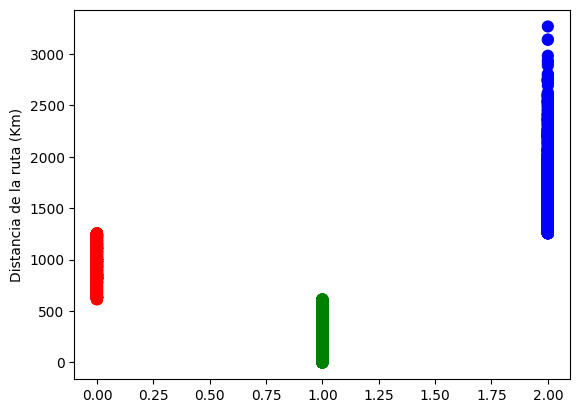

In [299]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig,ax =  plt.subplots()
ax.scatter(labels, X[:, 0], c=asignar,s=60)
ax.set_ylabel('Distancia de la ruta (Km)')

Clustering distancia y paradas:

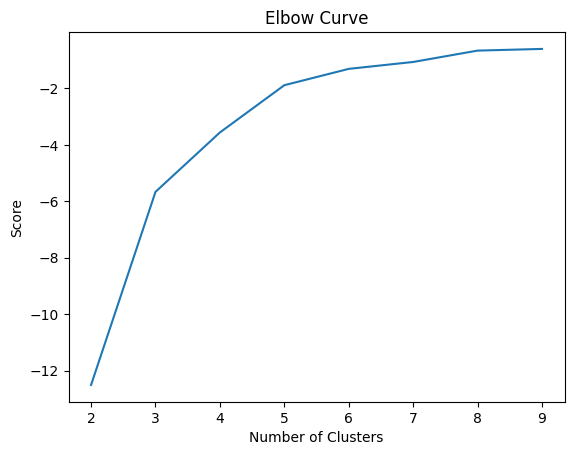

In [300]:
Nc = range(2, 10)
X = df.drop_duplicates(subset='IdRuta')[['NumPuntos','DistanciaReal_km','NumParadas']]
X = X.dropna().values
X_norm = normalize(X)
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [kmeans[i].fit(X_norm).score(X_norm) for i in range(len(kmeans))]
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [301]:
# Elijo usar 4 clusters
kmeans = KMeans(n_clusters=4, n_init="auto").fit(X_norm)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.00704484 0.99994338 0.004405  ]
 [0.30289957 0.89298141 0.29478383]
 [0.66953152 0.2292066  0.65157916]
 [0.06830467 0.99454371 0.06426825]]


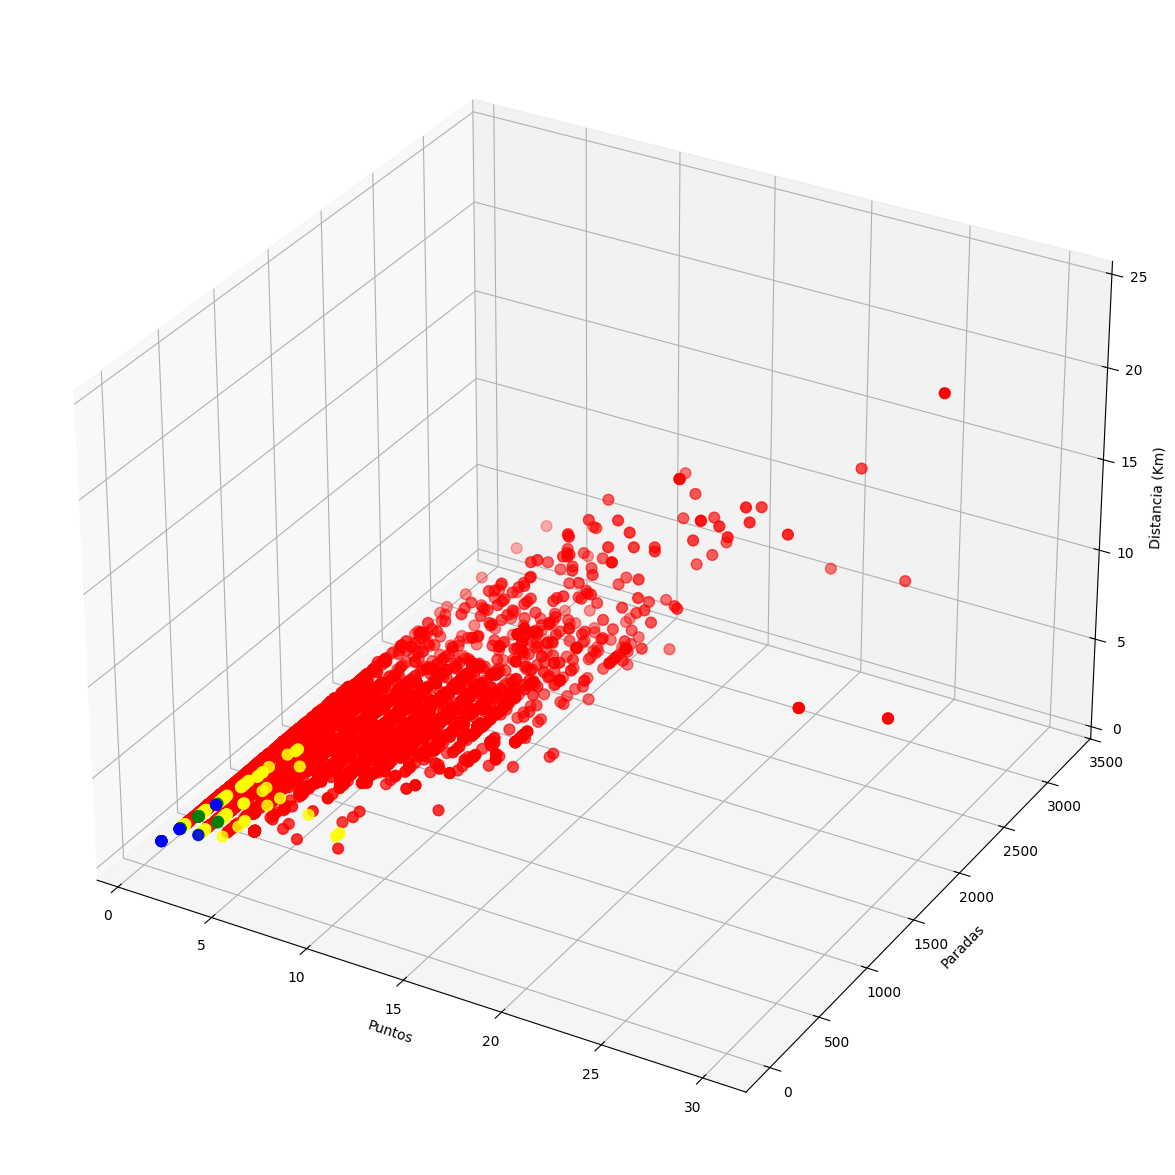

In [302]:
# Predicting the clusters
labels = kmeans.predict(X_norm)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','yellow','orange']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:,2], c=asignar,s=60)
ax.set_xlabel('Puntos')
ax.set_ylabel('Paradas')
ax.set_zlabel('Distancia (Km)')
plt.show()

<BarContainer object of 2 artists>

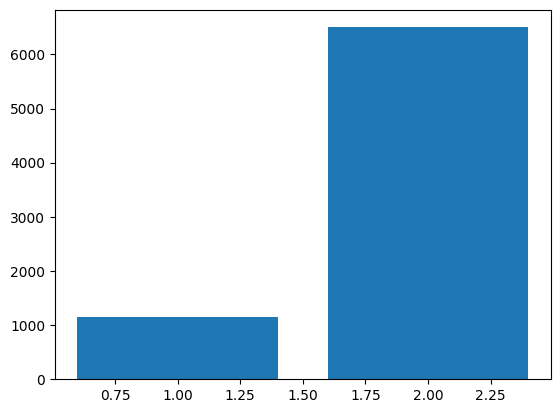

In [303]:
c = Counter(list(df.drop_duplicates(subset='Id_Pedido')["NumConductores"]))
plt.bar(c.keys(), c.values())

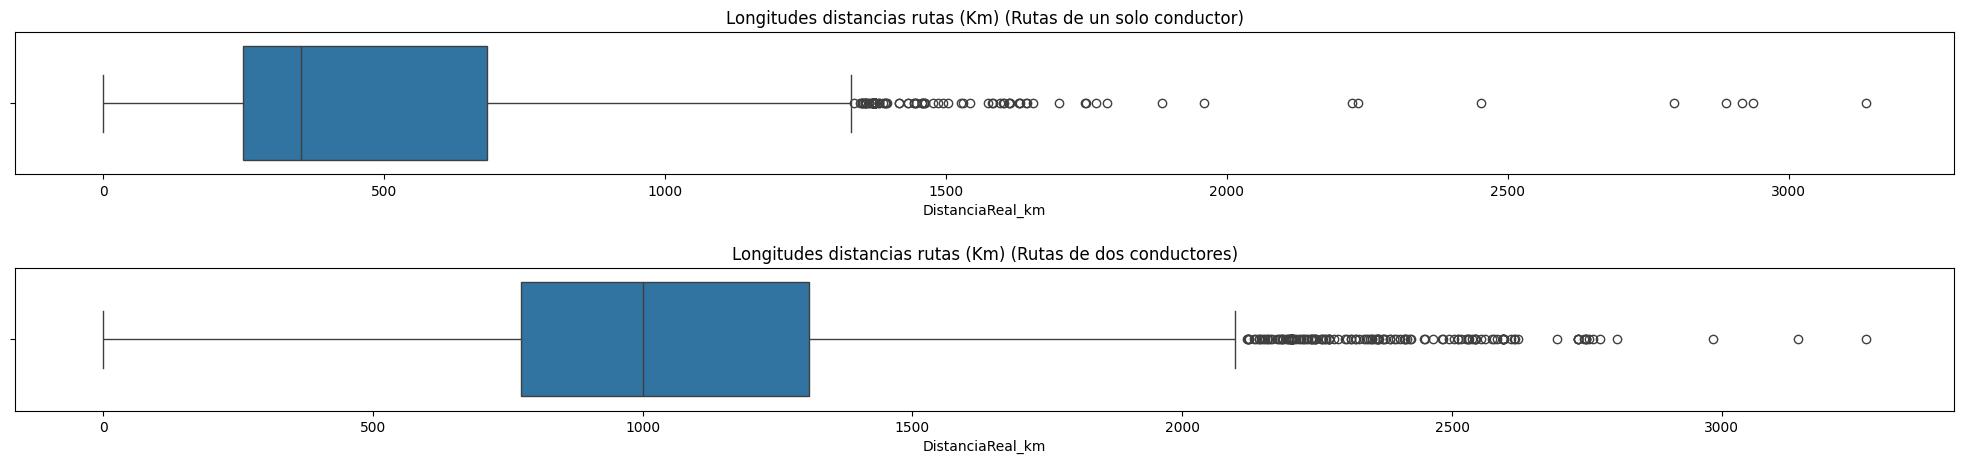

In [304]:
conductores_distancia = df.drop_duplicates(subset='IdRuta')
conductor1_distancia = conductores_distancia.loc[conductores_distancia["Id_Conductor2"].isnull()]
conductor2_distancia = conductores_distancia.loc[~conductores_distancia["Id_Conductor2"].isnull()]
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(20,5))
sns.boxplot(x=conductor1_distancia['DistanciaReal_km'], ax=ax[0]).set_title("Longitudes distancias rutas (Km) (Rutas de un solo conductor)")
sns.boxplot(x=conductor2_distancia['DistanciaReal_km'], ax=ax[1]).set_title("Longitudes distancias rutas (Km) (Rutas de dos conductores)")
plt.ticklabel_format(style='plain', axis='x')
fig.tight_layout(pad=2)

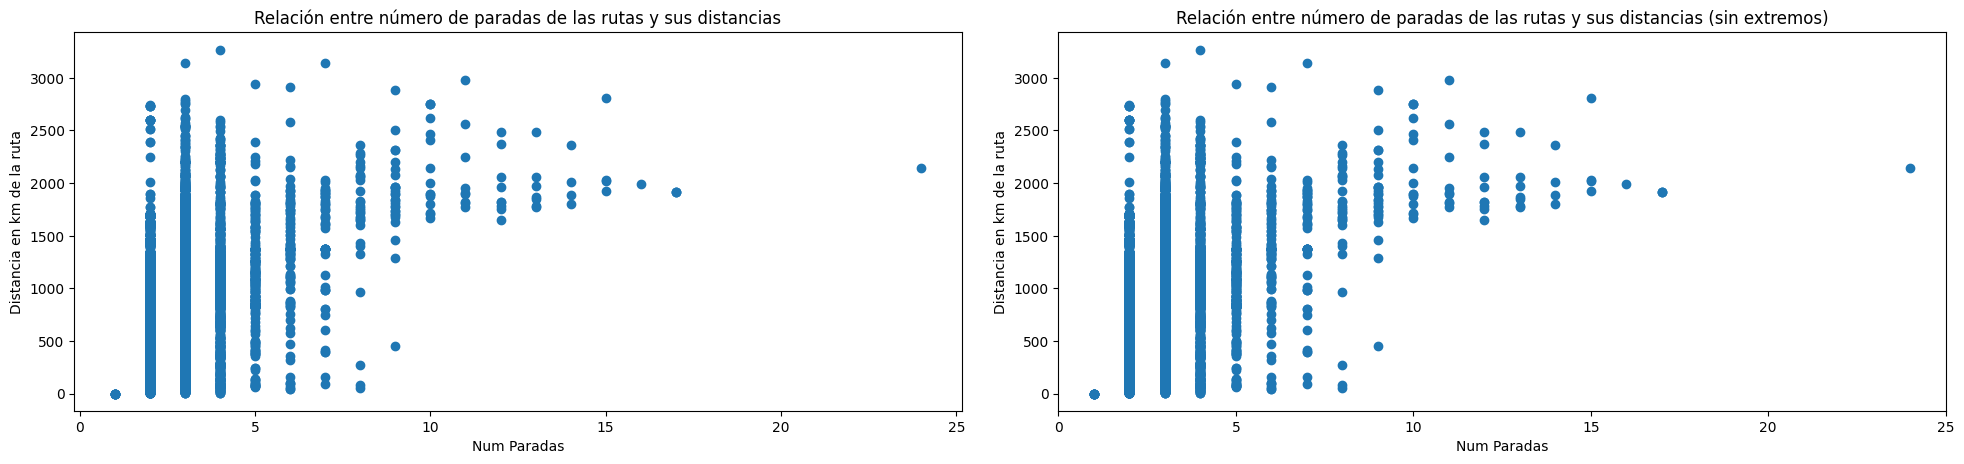

In [305]:
paradas_distancia = df.drop_duplicates(subset='IdRuta')
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
ax[0].scatter(paradas_distancia["NumParadas"], paradas_distancia["DistanciaReal_km"])
ax[0].set_xlabel('Num Paradas')
ax[0].set_ylabel('Distancia en km de la ruta')
ax[0].set_title('Relación entre número de paradas de las rutas y sus distancias')

# ignoro los valores extremos
ax[1].scatter(paradas_distancia["NumParadas"], paradas_distancia["DistanciaReal_km"])
ax[1].set_xlabel('Num Paradas')
ax[1].set_ylabel('Distancia en km de la ruta')
ax[1].set_title('Relación entre número de paradas de las rutas y sus distancias (sin extremos)')
ax[1].set_xlim(0, 25)

fig.tight_layout(pad=2)

### Días de la semana en las rutas

In [306]:
rce12 = pd.read_csv('RutasCalculadasEventos.csv', delimiter=';', encoding='cp1252')
def diaComienzoFin(rce: pd.DataFrame, ruta: int):
    diasSemana = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
    formatoFecha = '%Y-%m-%d %H:%M:%S.%f'

    eventos_ini = [8, 1]
    eventos_fin = [9, 10, 2]

    filtrado = rce.loc[rce["Id_Ruta"] == ruta]

    def obtener_fecha_hora(evento):
        eventos_filtrados = filtrado.loc[filtrado["Evento"].isin(evento)]
        if not eventos_filtrados.empty:
            return eventos_filtrados.iloc[0]["Fecha_Hora"]
        return None

    fechaIni = obtener_fecha_hora(eventos_ini)
    fechaFin = obtener_fecha_hora(eventos_fin)

    if fechaIni is None or fechaFin is None:
        return None, None

    diaIni = diasSemana[datetime.strptime(fechaIni, formatoFecha).weekday()]
    diaFin = diasSemana[datetime.strptime(fechaFin, formatoFecha).weekday()]

    return diaIni, diaFin

In [307]:
def diaComienzoFinEstimado(rc_av : pd.DataFrame, ruta: int):
    diasSemana = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
    formatoFecha = '%Y-%m-%d %H:%M:%S.%f'

    filtrado = rc_av.loc[rc_av["IdRuta"] == ruta]
    fechaIni = filtrado.iloc[0]["fecha_desde"]
    fechaFin = filtrado.iloc[0]["fecha_hasta"]

    diaIni = diasSemana[datetime.strptime(fechaIni, formatoFecha).weekday()] if not pd.isna(fechaIni) else None
    diaFin = diasSemana[datetime.strptime(fechaFin, formatoFecha).weekday()] if not pd.isna(fechaFin) else None

    return diaIni, diaFin

Análisis de tiempos entre salidas y vueltas a ruta

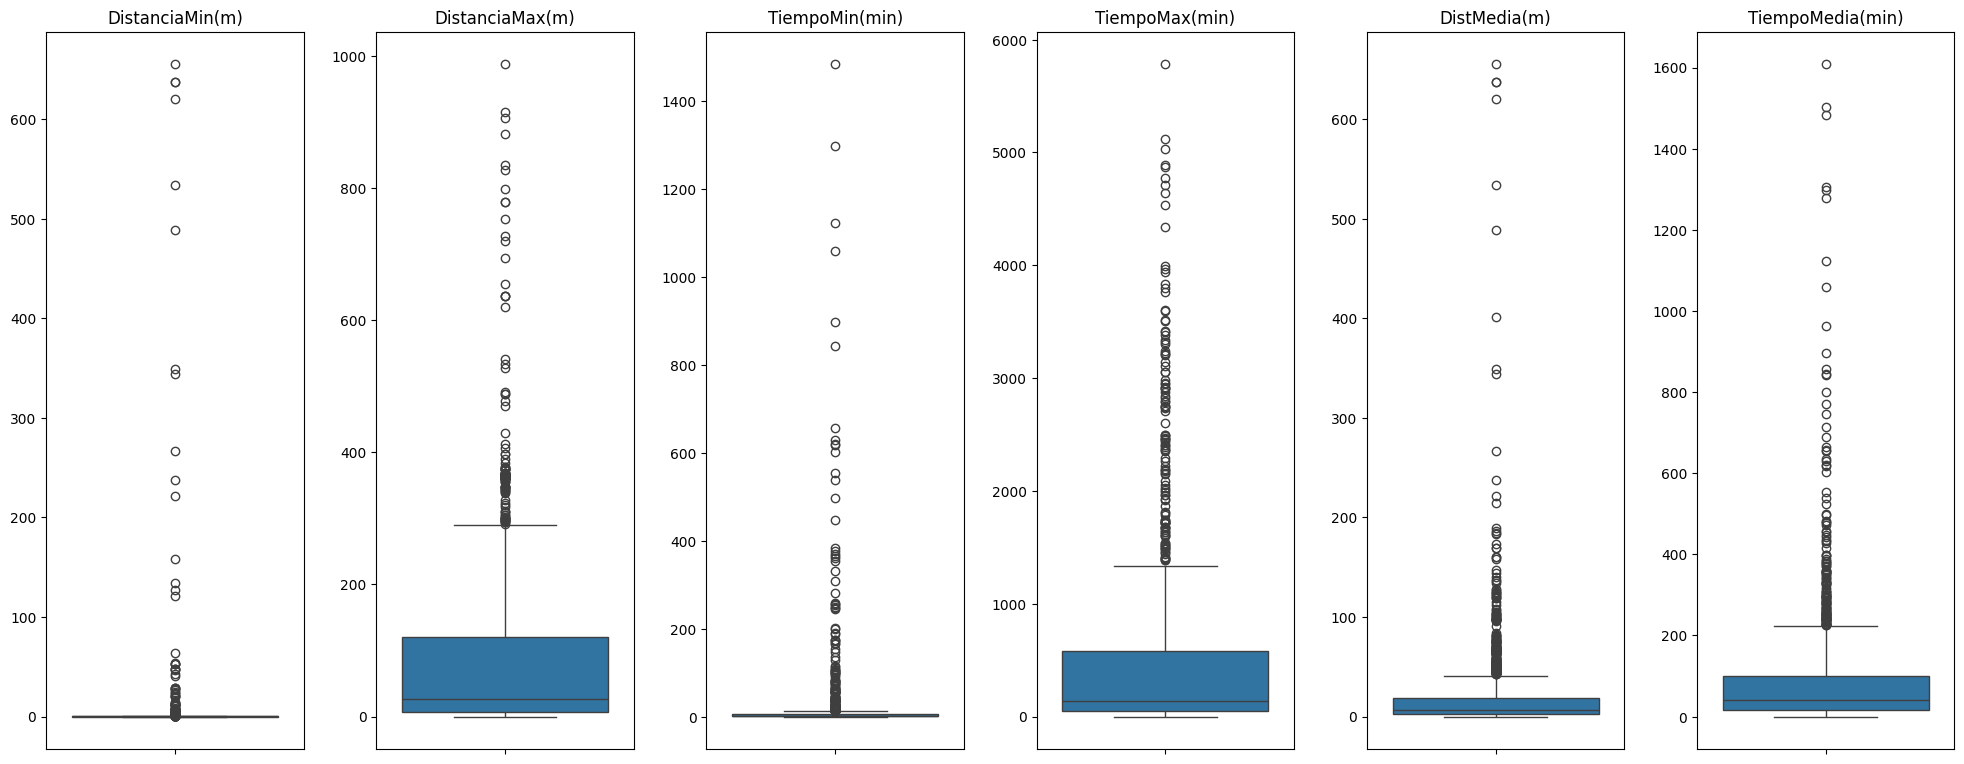

In [308]:
dibujos = [list(), list(), list(), list(), list(), list()]
titulos = ["DistanciaMin(m)", "DistanciaMax(m)", "TiempoMin(min)", "TiempoMax(min)", "DistMedia(m)", "TiempoMedia(min)"]
salida_vuelta_ruta = calculoExtremosDT(rce12)
for ruta, datos in salida_vuelta_ruta.items():
    dibujos[0].append(datos["mind"]) # minimosd
    dibujos[1].append(datos["maxd"]) # maximosd
    dibujos[2].append(datos["mint"]) # minimost
    dibujos[3].append(datos["maxt"]) # maximost
    dibujos[4].append(datos["mediad"]) # minimosd
    dibujos[5].append(datos["mediat"]) # minimosd

fig,ax = plt.subplots(ncols=6, nrows=1, figsize=(20,8))
i = 0
for dato in range(len(dibujos)):
    sns.boxplot(y=dibujos[dato],ax=ax[i]).set_title(titulos[dato])
    i += 1
fig.tight_layout(pad=2)

Etiquetar dias de comienzo y fin

In [309]:
df.columns

Index(['Id_Pedido', 'NPedido', 'Estado', 'Id_Marca_Ini', 'Id_Marca_Fin',
       'Id_Movimiento', 'CodigoViaje', 'Id_Vehiculo', 'Matricula',
       'Id_Conductor', 'Nombre_Conductor', 'Apellido1_Conductor',
       'Apellido2_Conductor', 'Id_Conductor2', 'Nombre_Conductor2',
       'Apellido1_Conductor2', 'Apellido2_Conductor2', 'Estado_Movimiento',
       'IdRuta', 'Nombre', 'IdPunto', 'Nombre.1', 'Latitud', 'Longitud',
       'Parada', 'Tiempo', 'Distancia', 'Id_Marca', 'NumMovimientos',
       'NumParadas', 'NumPuntos', 'DistanciaReal_km', 'TiempoEstimadoSis_h',
       'NumConductores'],
      dtype='object')

In [310]:
'''filtro = rce.loc[rce["Id_Ruta"].isin(df["IdRuta"])]
for ruta in set(df["IdRuta"]):
    comienzo, fin = diaComienzoFin(filtro, ruta)
    df.loc[df["IdRuta"] == ruta, "DiaIni"] = comienzo
    df.loc[df["IdRuta"] == ruta, "DiaFin"] = fin'''

filtro = rc_av.loc[rc_av["IdRuta"].isin(df["IdRuta"])]
for ruta in set(df["IdRuta"]):
    comienzo, fin = diaComienzoFinEstimado(filtro, ruta)
    df.loc[df["IdRuta"] == ruta, "DiaIni"] = comienzo
    df.loc[df["IdRuta"] == ruta, "DiaFin"] = fin

C:\Users\migue\AppData\Local\Temp\ipykernel_4828\1585842183.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\migue\AppData\Local\Temp\ipykernel_4828\1585842183.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [311]:
numNulls = df["DiaIni"].isnull().sum()
print(str(round(numNulls * 100 / len(df), 2)) + "%")

0.0%


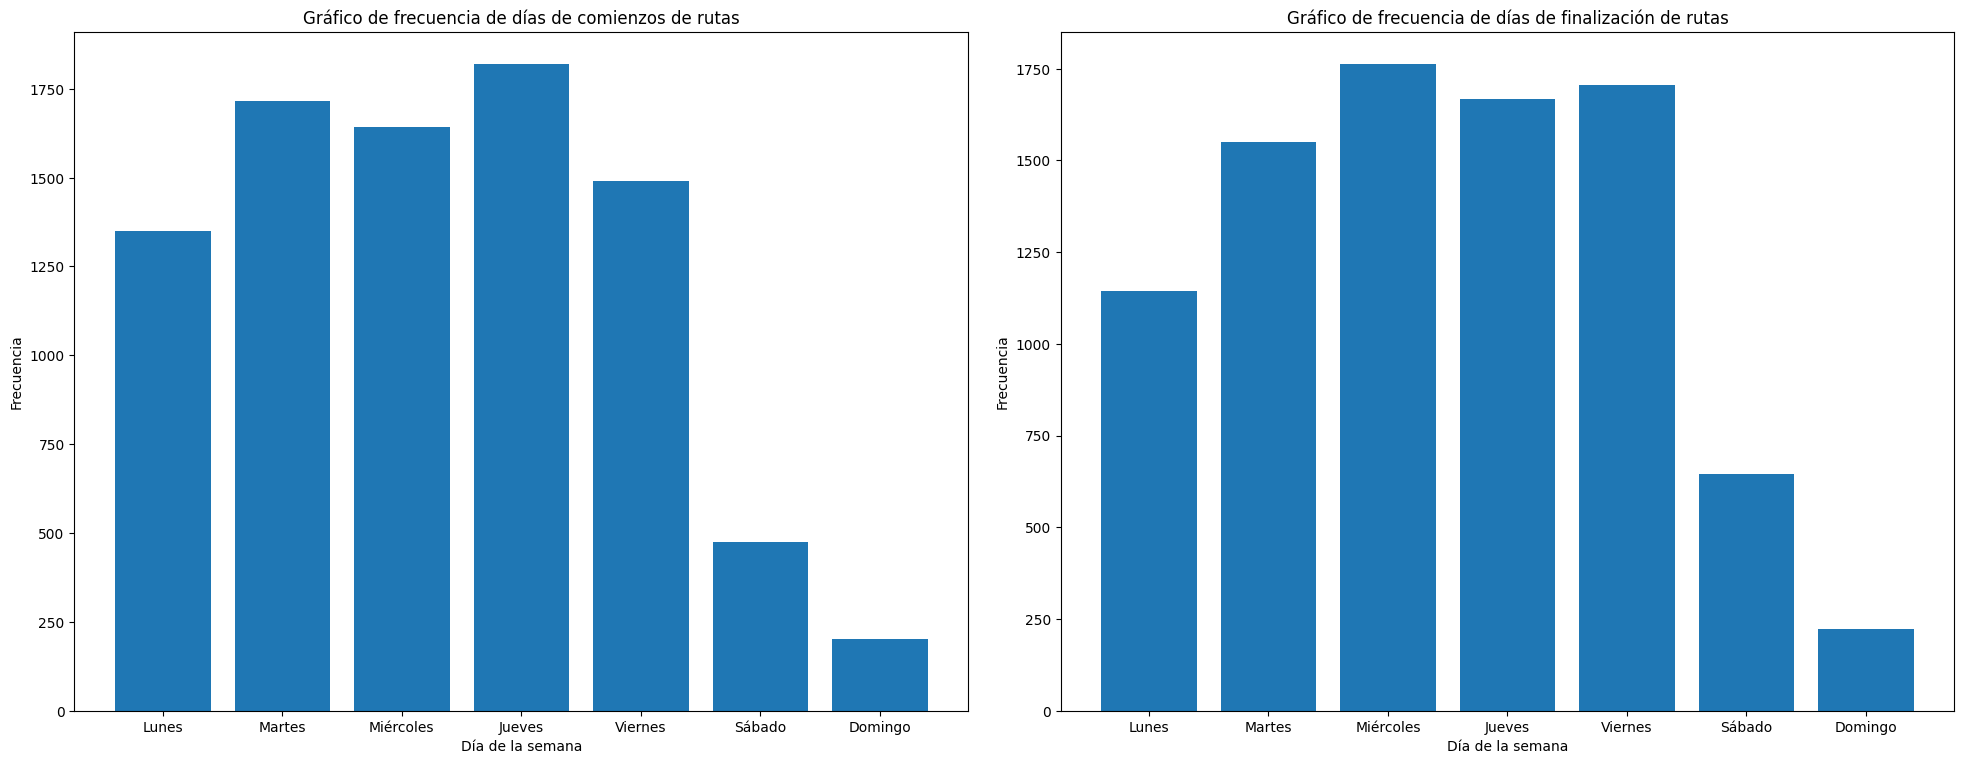

In [312]:
orden_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
filtro = df.drop_duplicates(subset='IdRuta').dropna(subset=['DiaIni'])
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(20,8))
frecuencias = filtro['DiaIni'].value_counts().reindex(orden_dias, fill_value=0)
ax[0].bar(frecuencias.index, frecuencias.values)
ax[0].set_xlabel('Día de la semana')
ax[0].set_ylabel('Frecuencia')
ax[0].set_title('Gráfico de frecuencia de días de comienzos de rutas')

frecuencias = filtro['DiaFin'].value_counts().reindex(orden_dias, fill_value=0)
ax[1].bar(frecuencias.index, frecuencias.values)
ax[1].set_xlabel('Día de la semana')
ax[1].set_ylabel('Frecuencia')
ax[1].set_title('Gráfico de frecuencia de días de finalización de rutas')
fig.tight_layout(pad=2)

### Comparar origen con el final

In [313]:
rcp = pd.read_csv('RutasCalculadasPuntos.csv', delimiter=';', encoding='cp1252')
def mismoOrigenDestino(rcp : pd.DataFrame, ruta : int):
    return rcp.loc[rcp["IdRuta"] == ruta].iloc[0]["Id_Marca"] == rcp.loc[rcp["IdRuta"] == ruta].iloc[-1]["Id_Marca"]

In [314]:
filtro = rcp.loc[rcp["IdRuta"].isin(df["IdRuta"])]
for ruta in set(df["IdRuta"]):
    df.loc[df["IdRuta"] == ruta, "MismoOrigenDestino"] = mismoOrigenDestino(filtro, ruta)

C:\Users\migue\AppData\Local\Temp\ipykernel_4828\857128062.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Gráfico de frecuencia de rutas que tienen mismo origen-destino')

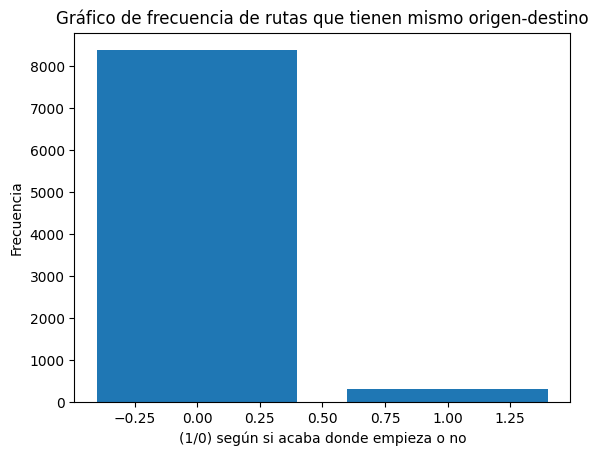

In [315]:
filtro = df.drop_duplicates(subset='IdRuta')
frecuencias = filtro['MismoOrigenDestino'].value_counts()
plt.bar(frecuencias.index, frecuencias.values)
plt.xlabel('(1/0) según si acaba donde empieza o no')
plt.ylabel('Frecuencia')
plt.title('Gráfico de frecuencia de rutas que tienen mismo origen-destino')

### Distancias totales pedidos

In [316]:
def distanciaTotalPedido(df: pd.DataFrame, pedido: int):
    filtro = df.loc[df["Id_Pedido"] == pedido].drop_duplicates(subset="IdRuta")
    return filtro["DistanciaReal_km"].sum()


In [317]:
for pedido in set(df["Id_Pedido"]):
    df.loc[df["Id_Pedido"] == pedido, "DistanciaTotalPedido_km"] = distanciaTotalPedido(df, pedido)

C:\Users\migue\AppData\Local\Temp\ipykernel_4828\1431332170.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [318]:
filtro = df.drop_duplicates(subset=["Id_Pedido"])
numMov = sorted(list(set(filtro["NumMovimientos"])))
mediaDist = list()
for n in numMov:
    distancias = filtro.loc[df["NumMovimientos"] == n]["DistanciaReal_km"].dropna()
    media = sum(distancias)/len(distancias)
    mediaDist.append(media)

Text(0.5, 1.0, 'Relacion entre los movimientos requeridos en un pedido y su distancia total')

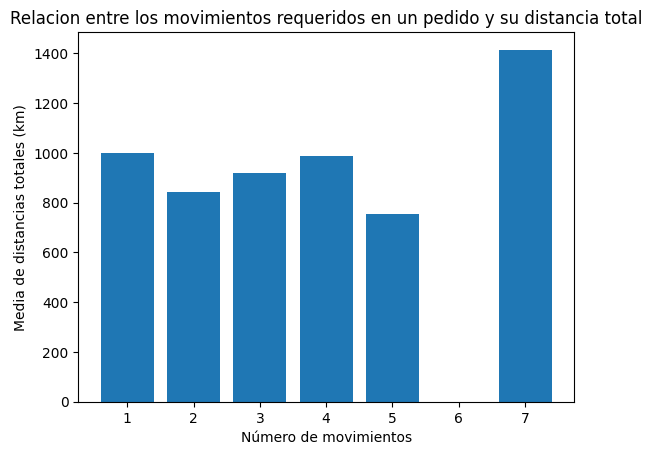

In [319]:
plt.bar(numMov, mediaDist)
plt.xlabel('Número de movimientos')
plt.ylabel('Media de distancias totales (km)')
plt.title('Relacion entre los movimientos requeridos en un pedido y su distancia total')

### Distancias de rutas segun comienzo en dia

Text(0, 0.5, 'Distancia de la ruta (km)')

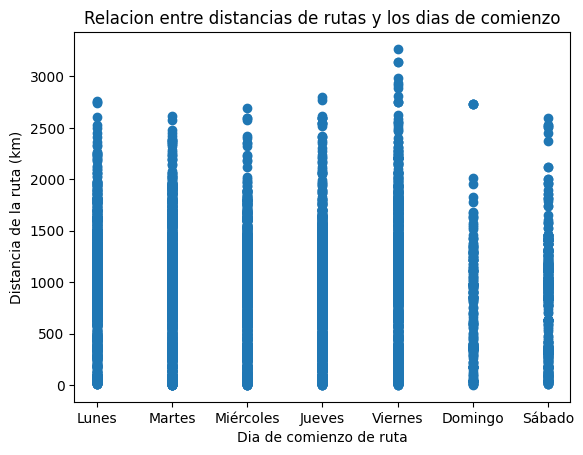

In [320]:
dias_distancias = df.drop_duplicates(subset='IdRuta').dropna(subset=['DiaIni'])
plt.scatter(dias_distancias["DiaIni"], dias_distancias["DistanciaReal_km"])
plt.title("Relacion entre distancias de rutas y los dias de comienzo")
plt.xlabel("Dia de comienzo de ruta")
plt.ylabel("Distancia de la ruta (km)")

Text(0, 0.5, 'Distancia media de las rutas (km)')

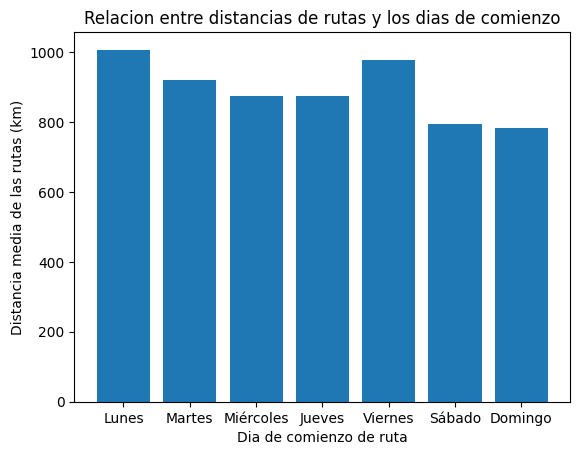

In [321]:
dias_distancias_medias = dias_distancias.groupby('DiaIni')['DistanciaReal_km'].mean().reset_index()
# Reindexar según el orden de los días de la semana
dias_distancias_medias.set_index('DiaIni', inplace=True)
dias_distancias_medias = dias_distancias_medias.reindex(orden_dias).reset_index()

plt.bar(dias_distancias_medias["DiaIni"], dias_distancias_medias["DistanciaReal_km"])
plt.title("Relacion entre distancias de rutas y los dias de comienzo")
plt.xlabel("Dia de comienzo de ruta")
plt.ylabel("Distancia media de las rutas (km)")

### Número de cargas y descargas

In [322]:
posibles_tareas = set(df["Nombre.1"])
print(posibles_tareas)
cargas = {"CARGA_INI", "CARGA_TRANS", "CARGA_ADIC"}
descargas = {"DESCARGA_FINAL", "DESCARGA_TRANS", "DESCARGA_ADIC"}


{'ENGANCHE_REM', 'DESCARGA_TRANS', nan, 'ENGANCHE', 'DESCARGA_ADIC', 'CARGA_TRANS', 'DESENGANCHE', 'DESCARGA_FINAL', 'CARGA_INI', 'CARGA_ADIC', 'INICIO'}


In [323]:
count = 0
count2 = 0
conjunto = cargas.union(descargas)
conjunto = conjunto.union(set(["ENGANCHE_REM", "DESENGANCHE", "ENGANCHE", "INICIO"]))
loquesale = set()
for index, row in df.iterrows():
    if row["Nombre.1"] not in conjunto  and row["Parada"] == 1:
        count += 1
        loquesale.add(row["Nombre.1"])
    if row["Parada"] == 1:
        count2 += 1
print(loquesale)
print(count)
print(count2)
count * 100 / count2

{nan}
139
29538


0.47058026948337733

In [324]:
def numCargas(dataFrame : pd.DataFrame):
    return len(dataFrame.loc[dataFrame["Nombre.1"].isin(cargas)])
def numDescargas(dataFrame : pd.DataFrame):
    return len(dataFrame.loc[dataFrame["Nombre.1"].isin(descargas)])

In [325]:
for ruta in set(df["IdRuta"]):
    filtro = df.loc[df["IdRuta"] == ruta]
    # por si se usa la ruta en varios pedidos
    pedidos = list(filtro["Id_Pedido"])
    filtro = filtro[filtro["Id_Pedido"] == pedidos[0]]
    df.loc[df["IdRuta"] == ruta, "NumCargasRuta"] = numCargas(filtro)
    df.loc[df["IdRuta"] == ruta, "NumDescargasRuta"] = numDescargas(filtro)

C:\Users\migue\AppData\Local\Temp\ipykernel_4828\3663861542.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\migue\AppData\Local\Temp\ipykernel_4828\3663861542.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df

### Extraer información de las direcciones

In [327]:
marcas = set(df.loc[~df["Id_Marca"].isnull()]["Id_Marca"]) 
marcadores = pd.read_csv('Marcadores.csv', delimiter=';', encoding='cp1252')
marcadores = marcadores.loc[marcadores["Id_Marca"].isin(marcas)]
marcadores = marcadores[["Id_Marca", "Nombre_Punto", "Latitud", "Longitud", "Localidad", "Codigo"]] # Selección de atributos de los lugares 
df = pd.merge(df, marcadores, how="left", on='Id_Marca')

In [ ]:
df

In [329]:
contadorCodigoRaro = 0
def decodificar_localidad(row):
    global contadorCodigoRaro
    patron1 = r'([A-Z]{2})(?:-[A-Z])?-(\d{4,8}(?:EH)?|\d{2,4}-\d{2,3})\s+(.+)'
    patron2 = r'([A-Z]{2})-(\d{7,8})'
    patron3 = r'(\d{4,5}(?:-\d{3})?|\d{2,5}-\d{3})\s([^\d,]+),(?:\s[^,]+,|)\s(.+)'
    patron4 = r'(49240), (Avrillé), (Francia)'
    patron5 = r'BOTTER 10   (NL)-(211) NM (BODEGRAVEN)'
    paises = {"ES": "España", "FR" : "Francia", "NL" : "Países Bajos", 
              "DE" : "Alemania", "BE" : "Bélgica", "MA" : "Marruecos", 
              "CH" : "Suiza", "SU" : "Suiza", "LU" : "Luxemburgo", 
              "PL" : "Polonia", "IT" : "Italia", "PT" : "Portugal"}
    
    if row["Parada"] != 1 or pd.isnull(row["Id_Marca"]) or pd.isnull(row["Localidad"]):
        return None, None, None
    match = re.search(patron1, row["Localidad"])
    if match:
        pais = paises[match.group(1)]
        codLocalidad = match.group(2)
        localidad = match.group(3).upper()
    elif match := re.search(patron2, row["Localidad"]):
        pais = paises[match.group(1)]
        codLocalidad = match.group(2)
        contadorCodigoRaro += 1
        localidad = None
    elif  match := re.search(patron3, row["Localidad"]):
        pais = match.group(3)
        codLocalidad = match.group(1)
        localidad = match.group(2).upper()
    elif  match := re.search(patron4, row["Localidad"]):
        pais = paises["FR"]
        codLocalidad = match.group(1)
        localidad = match.group(2).upper()
    elif  match := re.search(patron5, row["Localidad"]):
        pais = paises[match.group(1)]
        codLocalidad = match.group(2)
        localidad = match.group(3).upper()
    else:
        return None, None, None
    return pais, codLocalidad, localidad

Comprobar si cada dirección se puede capturar con algún patrón

In [330]:
for localidad in set(df["Localidad"]):
    if pd.notna(localidad):
        patron1 = r'([A-Z]{2})(?:-[A-Z])?-(\d{4,8}(?:EH)?|\d{2,4}-\d{2,3})\s+(.+)'
        patron2 = r'([A-Z]{2})-(\d{7,8})'
        patron3 = r'(\d{4,5}(?:-\d{3})?|\d{2,5}-\d{3})\s([^\d,]+),(?:\s[^,]+,|)\s(.+)'
        patron4 = r'(49240), (Avrillé), (Francia)'
        patron5 = r'BOTTER 10   (NL)-(211) NM (BODEGRAVEN)'
        m1 = re.search(patron1, localidad)
        m2 = re.search(patron2, localidad)
        m3 = re.search(patron3, localidad)
        m4 = re.search(patron4, localidad)
        m5 = re.search(patron5, localidad)
        if not m1 and not m2 and not m3 and not m4 and not m5:
            print(localidad)

Dataframe para analizarlo

In [331]:
contadorCodigoRaro = 0
df[["Pais", "CodLocalidad", "LocalidadReal"]] = df.apply(lambda row: pd.Series(decodificar_localidad(row)), axis=1)
df

Id_Pedido                  NPedido  Estado  Id_Marca_Ini  Id_Marca_Fin  \
0              1         PT23015597_10000       4          2690          4467   
1              1         PT23015597_10000       4          2690          4467   
2              1         PT23015597_10000       4          2690          4467   
3              1         PT23015597_10000       4          2690          4467   
4              1         PT23015597_10000       4          2690          4467   
...          ...                      ...     ...           ...           ...   
52470      16498         PT24010758_10000       6          2527          5062   
52471      16550  PT24010758_10000_vacio1       5          4524          2456   
52472      16498         PT24010758_10000       6          2527          5062   
52473      16550  PT24010758_10000_vacio1       5          4524          2456   
52474      16498         PT24010758_10000       6          2527          5062   

       Id_Movimiento CodigoViaje  Id_Vehiculo Matricula  Id_Conductor  ...  \
0                  1  VJ23023805         1972   9035MDF          3903  ...   
1                  1  VJ23023805         1972   9035MDF          3903  ...   
2                  1  VJ23023805         1972   9035MDF          3903  ...   
3                  1  VJ23023805         1972   9035MDF          3903  ...   
4                  1  VJ23023805         1972   9035MDF          3903  ...   
...              ...         ...          ...       ...           ...  ...   
52470          10915  VJ24015396         2222   9165MMZ          3482  ...   
52471          10915  VJ24015396         2222   9165MMZ          3482  ...   
52472          10915  VJ24015396         2222   9165MMZ          3482  ...   
52473          10915  VJ24015396         2222   9165MMZ          3482  ...   
52474          10915  VJ24015396         2222   9165MMZ          3482  ...   

      NumCargasRuta NumDescargasRuta Nombre_Punto  Latitud_y Longitud_y  \
0               1.0              0.0  ES-50197002    41,6515  -0,988084   
1               1.0              0.0  ES-28806003   40,49107   -3,39629   
2               1.0              0.0          NaN        NaN        NaN   
3               1.0              0.0          NaN        NaN        NaN   
4               1.0              0.0  FR-33610036   44,74506  -0,701694   
...             ...              ...          ...        ...        ...   
52470           1.0              1.0          NaN        NaN        NaN   
52471           1.0              1.0          NaN        NaN        NaN   
52472           1.0              1.0          NaN        NaN        NaN   
52473           1.0              1.0  FR-91100000    48,5885   2,435812   
52474           1.0              1.0  FR-91100000    48,5885   2,435812   

                                               Localidad  \
0                     CALLE OSCA, 76   ES-50197 ZARAGOZA   
1      CALLE TALES DE MILETO 19   ES-28806 Alcala De ...   
2                                                    NaN   
3                                                    NaN   
4                                        FR-33610 Cestas   
...                                                  ...   
52470                                                NaN   
52471                                                NaN   
52472                                                NaN   
52473  ZAC DES BRATEAUX RUE DES 44 ARPENTS, BAT E  FR...   
52474  ZAC DES BRATEAUX RUE DES 44 ARPENTS, BAT E  FR...   

                           Codigo     Pais  CodLocalidad      LocalidadReal  
0      PLATAFORMA EUROPA ZARAGOZA   España         50197           ZARAGOZA  
1            MONDIAL RELAY ALCALA   España         28806  ALCALA DE HENARES  
2                             NaN     None          None               None  
3                             NaN     None          None               None  
4            PARKING CESTAS NORTE  Francia         33610             CESTAS  
...    

In [332]:
print(contadorCodigoRaro*100/len(set(df["Localidad"])))
print(len(set(df["Localidad"])))
contadorCodigoRaro

3.289791969037252
2067


68

In [333]:
set(df["Pais"])

{'Alemania',
 'Bélgica',
 'España',
 'Francia',
 'Italia',
 'Luxemburgo',
 'Marruecos',
 None,
 'Países Bajos',
 'Polonia',
 'Portugal',
 'Suiza'}

Compruebo si realmente el codigo que he extraido es el de la localidad

In [334]:
# Agrupar los datos por el campo "Codigo" y contar las localidades únicas asociadas a cada código
conteo_localidades_por_codigo = df.groupby('CodLocalidad')['LocalidadReal'].nunique()

# Filtrar los códigos que no tienen una única localidad asociada
codigos_no_unicos = conteo_localidades_por_codigo[conteo_localidades_por_codigo > 1].index.tolist()

if len(codigos_no_unicos) == 0:
    print("Todos los códigos tienen una única localidad asociada.")
else:
    print("Códigos que no tienen una única localidad asociada:")
    print(codigos_no_unicos)
    print(len(codigos_no_unicos))

Códigos que no tienen una única localidad asociada:
['01015', '01196', '01213', '02140', '02240', '06510', '08040', '08130', '08430', '08520', '08740', '08820', '10440', '12000', '14100', '16300', '20100', '20150', '20180', '2133', '28041', '2830', '28320', '28700', '30000', '31119', '31191', '31200', '31360', '31450', '31486', '31620', '31800', '33380', '34120', '37210', '40140', '40260', '41600', '42100', '4460', '45140', '45200', '45210', '45300', '45700', '48340', '48480', '48510', '48950', '50190', '50197', '50690', '51520', '59125', '59174', '59264', '59554', '59710', '60280', '60330', '60530', '62138', '62500', '64230', '6851EH', '69125', '69780', '76430', '77130', '77220', '77230', '77240', '77290', '77470', '77550', '77610', '78730', '80700', '82370', '82700', '8930', '9042', '9100', '91090', '91220', '9130', '91700', '93290', '93600', '95300', '95470', '95500', '95670', '9810']
95


Al observar los datos veo que algunas localidades son las mismas, pero escritas diferente. Asigno la forma más común de escribirlo. Cuando solo haya dos posibles localidades se usará la versión más común y cuando sean varias, entre las que haya otras localidades que sí sean diferentes, se hace la asignación para esos casos concretos por ser pocos.

In [335]:
for cod in codigos_no_unicos:
    localidades = set(df.loc[df["CodLocalidad"] == cod, 'LocalidadReal'])
    if len(localidades) > 2:
        print(localidades)
        print(cod)
        
# solo hay que corregir FRANQUESES DEL VALLE

{'LOPIDANA', 'ETXABARRI IBIÑA', 'ANTEZANA/ANDETXA', 'VITORIA-GASTEIZ'}
01196
{"CORRO D'AVALL (FRANQUESES DEL ", 'FRANQUESES DEL VALLE', 'LES FRANQUESES DEL VALLÉS'}
08520
{'BERIAIN', 'CORDOVILLA', 'ESQUIROZ (GALAR)'}
31191
{'VALENTINE', 'SAINT-GAUDENS', 'ALTSASU/ALSASUA'}
31800
{'MARGNY-LÈS-COMPIÈGNE', 'VENETTE', 'CLAIROIX'}
60280
{'VÉMARS', 'SURVILLIERS', 'SAINT-WITZ'}
95470
{'LE THILLAY', 'BONNEUIL-EN-FRANCE', 'GONESSE'}
95500


In [336]:
codigos_corregir = set()
for cod in codigos_no_unicos:
    localidades = set(df.loc[df["CodLocalidad"] == cod, 'LocalidadReal'])
    
    if len(localidades) == 2 :
        s1 = localidades.pop()
        s2 = localidades.pop()
        if s1[:4].lower() == s2[:4].lower():
            codigos_corregir.add(cod)
            print(s1,s2)


VITORIA VITORIA-GASTEIZ
LA ROCA DEL VALLES LA ROCA DEL VALLÈS
AMOREBIETA-ETXANO AMOREBIETA
AEROPUERTO DE GARRAPINILLOS (Z AEROPUERTO ZARAGOZA
TRITH SAINT LEGER TRITH-SAINT-LÉGER
MONTEREAU FAUT YONNE MONTEREAU-FAULT-YONNE
MONTBARTIER MONTECH
TREMBLAY EN FRANCE TREMBLAY-EN-FRANCE
AULNAY-SOUS-BOIS AULNAY SOUS BOIS
MARLY-LA-VILLE MARLY LA VILLE


In [337]:
# Agrupar los datos por el campo "CodLocalidad" y contar las ocurrencias de cada localidad
conteo_localidades_por_codigo = df.groupby('CodLocalidad')['LocalidadReal'].value_counts()

# Encontrar la localidad más común para cada código
localidades_mas_comunes_por_codigo = conteo_localidades_por_codigo.groupby('CodLocalidad').idxmax()
print(localidades_mas_comunes_por_codigo)

# Crear un diccionario que mapee cada código a su localidad más común
diccionario_localidades_mas_comunes = {codigo: localidad for codigo, localidad in localidades_mas_comunes_por_codigo}

def corregir_localidades(row):
    if row["CodLocalidad"] in codigos_corregir:
        return diccionario_localidades_mas_comunes.get(row['CodLocalidad'], row['LocalidadReal'])
    elif row["CodLocalidad"] == '08520':
        return "FRANQUESES DEL VALLE"
    else:
        return row['LocalidadReal']
# Actualizar todas las filas del DataFrame con la localidad más común para cada código no único
df['LocalidadReal'] = df.apply(lambda row: corregir_localidades(row), axis=1)
df


CodLocalidad
01015          (01015, VITORIA-GASTEIZ)
01100                   (01100, ARBENT)
01110    (01110, SANTA CRUZ DE CAMPEZO)
01160               (01160, PONT-D’AIN)
01170                  (01170, LEGUTIO)
                      ...              
9810                   (9810, NAZARETH)
9820                  (9820, MERELBEKE)
9880                     (9880, AALTER)
9940                    (9940, EVERGEM)
9990                   (9990, MALDEGEM)
Name: count, Length: 1211, dtype: object


Id_Pedido                  NPedido  Estado  Id_Marca_Ini  Id_Marca_Fin  \
0              1         PT23015597_10000       4          2690          4467   
1              1         PT23015597_10000       4          2690          4467   
2              1         PT23015597_10000       4          2690          4467   
3              1         PT23015597_10000       4          2690          4467   
4              1         PT23015597_10000       4          2690          4467   
...          ...                      ...     ...           ...           ...   
52470      16498         PT24010758_10000       6          2527          5062   
52471      16550  PT24010758_10000_vacio1       5          4524          2456   
52472      16498         PT24010758_10000       6          2527          5062   
52473      16550  PT24010758_10000_vacio1       5          4524          2456   
52474      16498         PT24010758_10000       6          2527          5062   

       Id_Movimiento CodigoViaje  Id_Vehiculo Matricula  Id_Conductor  ...  \
0                  1  VJ23023805         1972   9035MDF          3903  ...   
1                  1  VJ23023805         1972   9035MDF          3903  ...   
2                  1  VJ23023805         1972   9035MDF          3903  ...   
3                  1  VJ23023805         1972   9035MDF          3903  ...   
4                  1  VJ23023805         1972   9035MDF          3903  ...   
...              ...         ...          ...       ...           ...  ...   
52470          10915  VJ24015396         2222   9165MMZ          3482  ...   
52471          10915  VJ24015396         2222   9165MMZ          3482  ...   
52472          10915  VJ24015396         2222   9165MMZ          3482  ...   
52473          10915  VJ24015396         2222   9165MMZ          3482  ...   
52474          10915  VJ24015396         2222   9165MMZ          3482  ...   

      NumCargasRuta NumDescargasRuta Nombre_Punto  Latitud_y Longitud_y  \
0               1.0              0.0  ES-50197002    41,6515  -0,988084   
1               1.0              0.0  ES-28806003   40,49107   -3,39629   
2               1.0              0.0          NaN        NaN        NaN   
3               1.0              0.0          NaN        NaN        NaN   
4               1.0              0.0  FR-33610036   44,74506  -0,701694   
...             ...              ...          ...        ...        ...   
52470           1.0              1.0          NaN        NaN        NaN   
52471           1.0              1.0          NaN        NaN        NaN   
52472           1.0              1.0          NaN        NaN        NaN   
52473           1.0              1.0  FR-91100000    48,5885   2,435812   
52474           1.0              1.0  FR-91100000    48,5885   2,435812   

                                               Localidad  \
0                     CALLE OSCA, 76   ES-50197 ZARAGOZA   
1      CALLE TALES DE MILETO 19   ES-28806 Alcala De ...   
2                                                    NaN   
3                                                    NaN   
4                                        FR-33610 Cestas   
...                                                  ...   
52470                                                NaN   
52471                                                NaN   
52472                                                NaN   
52473  ZAC DES BRATEAUX RUE DES 44 ARPENTS, BAT E  FR...   
52474  ZAC DES BRATEAUX RUE DES 44 ARPENTS, BAT E  FR...   

                           Codigo     Pais  CodLocalidad      LocalidadReal  
0      PLATAFORMA EUROPA ZARAGOZA   España         50197           ZARAGOZA  
1            MONDIAL RELAY ALCALA   España         28806  ALCALA DE HENARES  
2                             NaN     None          None               None  
3                             NaN     None          None               None  
4            PARKING CESTAS NORTE  Francia         33610             CESTAS  
...    

Vuelvo a comprobar si coinciden origen y destino

In [338]:
def mismoOrigenDestinoLocalidad(df : pd.DataFrame, ruta : int):
    ini = df.loc[(df["IdRuta"] == ruta) & (df["Parada"] == 1)].iloc[0]["LocalidadReal"]
    fin = df.loc[(df["IdRuta"] == ruta) & (df["Parada"] == 1)].iloc[-1]["LocalidadReal"]
    return ini != "" and fin != "" and ini is not None and fin is not None and ini == fin
def mismoOrigenDestinoPais(df : pd.DataFrame, ruta : int):
    ini = df.loc[(df["IdRuta"] == ruta) & (df["Parada"] == 1)].iloc[0]["Pais"]
    fin = df.loc[(df["IdRuta"] == ruta) & (df["Parada"] == 1)].iloc[-1]["Pais"]
    return ini != "" and fin != "" and ini is not None and fin is not None and ini == fin

In [339]:
for ruta in set(df["IdRuta"]):
    df.loc[df["IdRuta"] == ruta, "MismoOrigenDestinoLocalidad"] = mismoOrigenDestinoLocalidad(df, ruta)
    df.loc[df["IdRuta"] == ruta, "MismoOrigenDestinoPais"] = mismoOrigenDestinoPais(df, ruta)

MismoOrigenDestinoLocalidad
False    8344
True      350
Name: count, dtype: int64

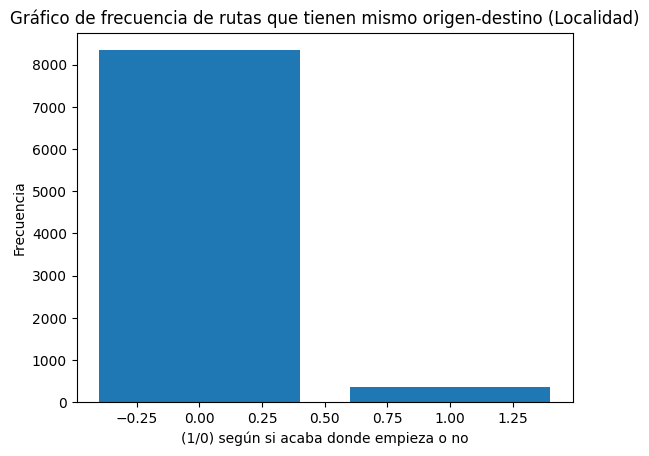

In [340]:
filtro = df.drop_duplicates(subset='IdRuta')
frecuencias = filtro['MismoOrigenDestinoLocalidad'].value_counts()
plt.bar(frecuencias.index, frecuencias.values)
plt.xlabel('(1/0) según si acaba donde empieza o no')
plt.ylabel('Frecuencia')
plt.title('Gráfico de frecuencia de rutas que tienen mismo origen-destino (Localidad)')
frecuencias

MismoOrigenDestinoPais
False    5259
True     3435
Name: count, dtype: int64

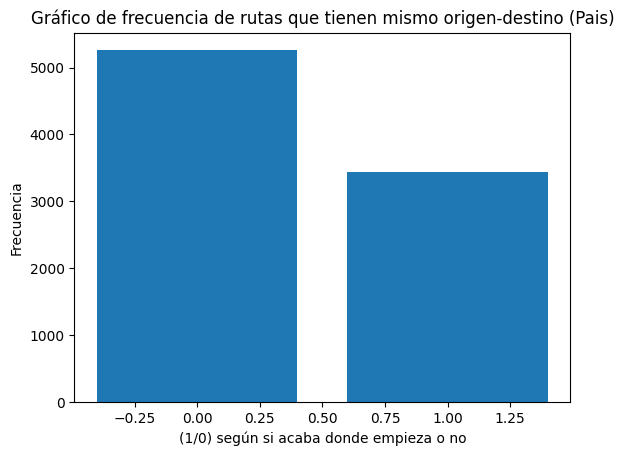

In [341]:
frecuencias = filtro['MismoOrigenDestinoPais'].value_counts()
plt.bar(frecuencias.index, frecuencias.values)
plt.xlabel('(1/0) según si acaba donde empieza o no')
plt.ylabel('Frecuencia')
plt.title('Gráfico de frecuencia de rutas que tienen mismo origen-destino (Pais)')
frecuencias

## Zonas en las que se mueven conductores

In [342]:
conductoresLugares = dict()
set2_sin_nulos = {x for x in set(df["Id_Conductor2"]) if pd.notna(x)}
conductores = set(df["Id_Conductor"]).union(set2_sin_nulos)
for conductor in conductores:
    conductoresLugares[conductor] = defaultdict(lambda:0)
for ruta in set(df["IdRuta"]):
    filtro = df[df["IdRuta"] == ruta]
    conductor1 = filtro.iloc[0]["Id_Conductor"]
    conductor2 = filtro.iloc[0]["Id_Conductor2"]
    localidades = {x for x in set(filtro["LocalidadReal"]) if x==x}
    if pd.notna(conductor1):
        for localidad in localidades:
            conductoresLugares[conductor1][localidad] += 1
            if pd.notna(conductor2):
                conductoresLugares[conductor2][localidad] += 1
conductoresFrecuentan = dict()
for conductor in conductoresLugares.keys():
    actual = conductoresLugares[conductor]
    if None in actual.keys():
        actual.pop(None)
    if actual:
        maximo = max(actual, key=actual.get)
        minimo = min(actual, key=actual.get)
        if maximo is None or maximo == '':
            maximo = "Desconocido"
        if minimo is None or minimo == '':
            minimo = "Desconocido"
        conductoresFrecuentan[conductor] = (maximo, minimo)
    else:
        conductoresFrecuentan[conductor] = ("Desconocido", "Desconocido")

In [343]:
def primer_no_nan(lista):
    for elemento in lista:
        if pd.notna(elemento):
            return elemento
    return None
localidadesConductores = dict()
localidades = {x for x in set(df["LocalidadReal"]) if pd.notna(x)}
for localidad in localidades:
    localidadesConductores[localidad] = defaultdict(lambda:0)
for ruta in set(df["IdRuta"]):
    filtro = df.loc[df["IdRuta"] == ruta]
    conductor1 = filtro.iloc[0]["Id_Conductor"]
    conductor2 = filtro.iloc[0]["Id_Conductor2"]
    origen = primer_no_nan(filtro["LocalidadReal"])
    lat_origen = primer_no_nan(filtro["Latitud_y"])
    long_origen = primer_no_nan(filtro["Longitud_y"])
    destino = primer_no_nan(reversed(list(filtro["LocalidadReal"])))
    lat_destino = primer_no_nan(reversed(list(filtro["Latitud_y"])))
    long_destino = primer_no_nan(reversed(list(filtro["Longitud_y"])))
    df.loc[df["IdRuta"] == ruta, ["Origen", "Lat_origen", "Long_origen", "Destino", "Lat_destino", "Long_destino"]] = [origen, lat_origen, long_origen, destino, lat_destino, long_destino]
    if pd.notna(origen):
        if pd.notna(conductor1) and conductor1 != -1:
            localidadesConductores[origen][conductor1] += 1
        if pd.notna(conductor2) and conductor2 != -1:
            localidadesConductores[origen][conductor2] += 1
'''        
fLocalidadConductores = dict()
for localidad in localidadesConductores.keys():
    actual = localidadesConductores[localidad]
    fLocalidadConductores[localidad] = sorted(actual, key=lambda x: actual[x])
    
localidadesConductores['La Rivière-de-Corps']
'''  
fLocalidadConductores = defaultdict(lambda: dict())
for localidad in localidadesConductores.keys():
    actual = localidadesConductores[localidad]
    for key, valor in actual.items():
        if valor not in fLocalidadConductores[localidad]:
            fLocalidadConductores[localidad][valor] = [key]
        else:
            fLocalidadConductores[localidad][valor].append(key)



### Mostrar cantidades de conductores por localidad y localidades por conductor

In [344]:
def resumir_diccionario(dic):
    resumido = {}
    for key, value in dic.items():
        if isinstance(value, dict):
            resumido[key] = len(value)
        else:
            resumido[key] = value
    return resumido

dictNumConductoresLocalidad = resumir_diccionario(fLocalidadConductores)
dictNumLocalidadesConductor = resumir_diccionario(conductoresLugares)


Mostrar estos datos

In [345]:
color_escala = 'Viridis' 
ids = list(dictNumConductoresLocalidad.keys())
valores = list(dictNumConductoresLocalidad.values())
fig = go.Figure(data=[go.Bar(x=ids, y=valores, marker=dict(color=valores, colorscale=color_escala))])

# Personalizar el diseño del gráfico
fig.update_layout(
    title="Número de conductores que parten de localidades",
    xaxis_title="Localidad",
    yaxis_title="Número de conductores",
    width=1500,
    height=600
)

# Mostrar el gráfico interactivo
fig.show()

In [346]:
color_escala = 'Viridis' 
ids = list(dictNumLocalidadesConductor.keys())
valores = list(dictNumLocalidadesConductor.values())
fig = go.Figure(data=[go.Bar(x=ids, y=valores, marker=dict(color='black'))])

# Personalizar el diseño del gráfico
fig.update_layout(
    title="Número de localidades de las que parten conductores",
    xaxis_title="IDs conductores",
    yaxis_title="Número de localidades",
    yaxis=dict(range=[0, 100]),
    width=1500,
    height=600
)

# Mostrar el gráfico interactivo
fig.show()

In [347]:
np.quantile(np.array(list(dictNumLocalidadesConductor.values())), [.2,.4,.6,.8,1])

array([  9.,  28.,  42.,  54., 143.])

In [348]:
filas = []
for localidad, conductores in localidadesConductores.items():
    for conductor, valor in conductores.items():
        filas.append([localidad, conductor, valor])

# Crear el DataFrame
dfLocalidadesConductores = pd.DataFrame(filas, columns=["Localidad", "ID_Conductor", "Frecuencia"])
dfLocalidadesConductores

Localidad  ID_Conductor  Frecuencia
0                   LOGNES        3669.0           1
1                   LOGNES        3764.0           1
2                   LOGNES        3945.0           3
3                   LOGNES        4165.0           3
4                   LOGNES        3630.0           2
...                    ...           ...         ...
8862  HOLLOGNE-AUX-PIERRES        3870.0           1
8863  HOLLOGNE-AUX-PIERRES        2317.0           1
8864  HOLLOGNE-AUX-PIERRES        3327.0           1
8865                TUBIZE        3175.0           1
8866                TUBIZE        4489.0           1

[8867 rows x 3 columns]

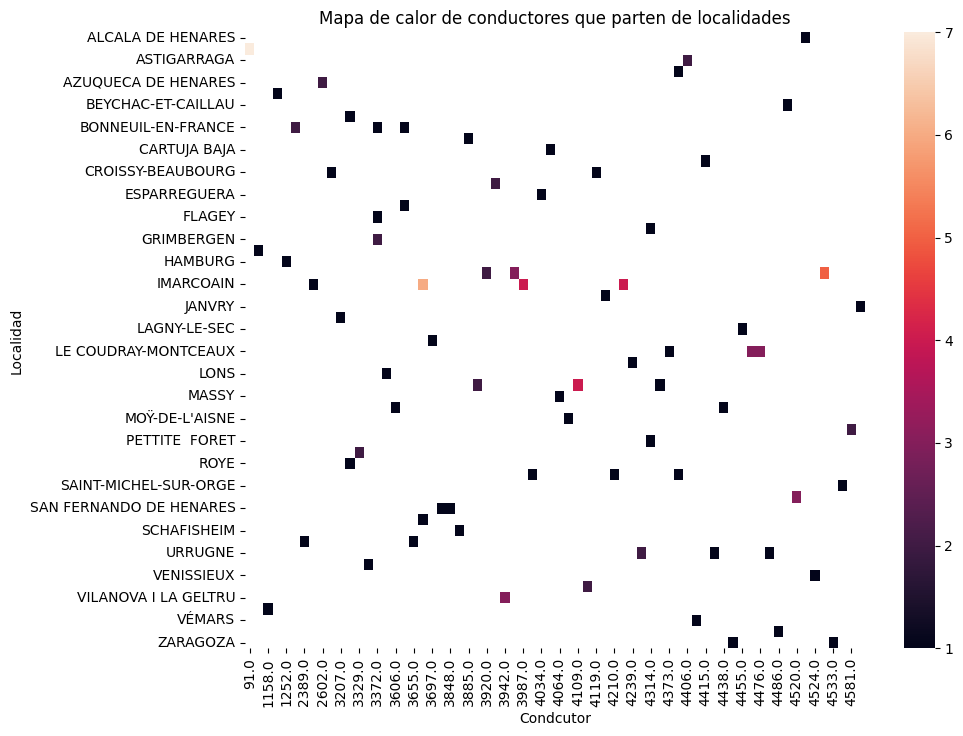

In [349]:
random.seed()
df_muestra = dfLocalidadesConductores.sample(n=75)
plt.figure(figsize=(10, 8))
sns.heatmap(df_muestra.pivot(index="Localidad", columns="ID_Conductor", values="Frecuencia"))
plt.title("Mapa de calor de conductores que parten de localidades")
plt.xlabel("Condcutor")
plt.ylabel("Localidad")
plt.show()

### Cantidad de puntos importantes en localidades

In [350]:
df_filtrado = df.dropna(subset=["Localidad"])
puntosLocalidades = defaultdict(lambda: set())
for index, row in df_filtrado.iterrows():
    puntosLocalidades[row["LocalidadReal"]].add(row["Localidad"])

In [351]:
longitudes = {k: len(v) for k, v in puntosLocalidades.items()}

# Crear un gráfico de barras con Plotly
fig = go.Figure(data=[go.Bar(x=list(longitudes.keys()), y=list(longitudes.values()))])

# Personalizar el diseño del gráfico
fig.update_layout(
    title="Número de puntos de las localidades que se usan para rutas",
    xaxis_title="Localidad",
    yaxis_title="Número de puntos",
)

# Mostrar el gráfico
fig.show()

## Tiempos de las rutas: estimado por persona, estimado por el sistema y el establecido como real.

Ya cuento en el dataset con los tiempos estimados por el sistema (extraidos de RutasCalculadasPuntos). Ahora, usando RutasCalculadasAsignacionVehiculos tengo las fechas que estableció el encargado de definir la ruta y las reales de cuando se realizaron las rutas.

In [352]:
rc_av = pd.read_csv("RutasCalculadasAsignacionVehiculos.csv", delimiter=';', encoding='cp1252')
rc_av

Id_VR  IdRuta  IdVehiculo              fecha_desde  \
0         1      24        1444  2019-04-24 16:20:00.000   
1         2      24        1444  2019-04-24 17:50:00.000   
2         3      24        1444  2019-04-24 17:50:00.000   
3         4       1        1484  2023-03-03 09:15:00.000   
4         5       2        1931  2023-03-03 09:18:00.000   
...     ...     ...         ...                      ...   
8952  10441   23433        2142  2024-04-05 17:00:00.000   
8953  10442   23435        2009  2024-04-07 14:00:00.000   
8954  10443   23438        2229  2024-04-06 23:00:00.000   
8955  10444   23441        2335  2024-04-05 23:45:00.000   
8956  10445   23443        2222  2024-04-05 13:00:00.000   

                  fecha_hasta     NroSerie  Id_Caja           Matricula  \
0     2019-04-24 16:20:00.000          NaN      NaN  Prueba David Oreña   
1     2019-04-24 17:50:00.000          NaN      NaN  Prueba David Oreña   
2     2019-04-24 17:50:00.000          NaN      NaN  Prueba David Oreña   
3     2023-03-03 09:15:00.000  pruebafagor    691.0         pruebafagor   
4     2023-03-03 12:18:00.000          NaN      NaN      PRUEBAS_TABLET   
...                       ...          ...      ...                 ...   
8952  2024-04-09 06:00:00.000     6,28E+03    322.0             6137MKD   
8953  2024-04-08 08:00:00.000       114V71    660.0             7589MFG   
8954  2024-04-08 12:00:00.000       1403L1    845.0             1378MPB   
8955  2024-04-08 04:00:00.000       05CRB1    157.0             4912MNV   
8956  2024-04-08 08:00:00.000       0629A1    318.0             9165MMZ   

      notificacion_web  notificacion_api  ...  Estado  Ult_Parada  \
0                  NaN               NaN  ...       0         NaN   
1                  NaN               NaN  ...       0         NaN   
2                  NaN               NaN  ...       0         NaN   
3                  NaN               NaN  ...       2         NaN   
4                  NaN               NaN  ...       2         NaN   
...                ...               ...  ...     ...         ...   
8952               NaN               NaN  ...       1         0.0   
8953               NaN               NaN  ...       0         NaN   
8954               NaN               NaN  ...       1         0.0   
8955               NaN               NaN  ...       1         0.0   
8956               NaN               NaN  ...       1         0.0   

             Fecha_Ult_Estado MargenInferior MargenSuperior  Pasajeros  \
0                         NaN            0.0              0        NaN   
1                         NaN            0.0              0        NaN   
2                         NaN            0.0              0        NaN   
3     2023-03-03 09:21:47.000          120.0            120        NaN   
4     2023-03-03 09:21:55.000          120.0            120        NaN   
...                       ...            ...            ...        ...   
8952  2024-04-06 13:08:10.000          720.0            720        NaN   
8953                      NaN          720.0            720        NaN   
8954  2024-04-06 20:04:20.000          720.0            720        NaN   
8955  2024-04-06 13:19:38.000          720.0            720        NaN   
8956  2024-04-06 13:09:37.000          720.0            720        NaN   

      RouteApproach AlarmaETA  AlarmaPtoPer  AlarmaPtoNop  
0               NaN       NaN           NaN           NaN  
1               NaN       NaN           NaN           NaN  
2               NaN       NaN           NaN           NaN  
3               NaN       NaN           NaN           NaN  
4               NaN       NaN           NaN           NaN  
...             ...       ...           ...           ...  
8952            NaN       NaN           NaN           NaN  
8953            NaN       NaN           NaN           NaN  
8954            NaN       NaN           NaN           NaN  
8955            NaN       NaN           NaN           NaN  
8956  

In [353]:
rutas = set(df["IdRuta"])
filtro = rc_av[rc_av["IdRuta"].isin(rutas)]
def infoRCAV(row):
    filaRCAV = filtro[filtro["IdRuta"] == row["IdRuta"]].iloc[0]
    formato = "%Y-%m-%d %H:%M:%S.%f"
    margenSup = timedelta(hours=(filaRCAV["MargenSuperior"] / 60) * 2)
    
    tiempoEstimado = None
    if not pd.isna(filaRCAV["fecha_desde"]) and not pd.isna(filaRCAV["fecha_hasta"]):
        # tiempo estimado por la persona encargada
        fecha1E = datetime.strptime(filaRCAV["fecha_desde"], formato)
        fecha2E = datetime.strptime(filaRCAV["fecha_hasta"], formato)

        diferencia = fecha2E - fecha1E
        tiempoEstimado = round(diferencia.total_seconds() / 3600.0,2)
        if tiempoEstimado < 0:
            print(filaRCAV["fecha_desde"], filaRCAV["fecha_hasta"])
        fechaConMargen = fecha2E + margenSup
    
    tiempoReal = None
    fecha1R = None
    if not pd.isna(filaRCAV["Fecha_Inicio_Real"]) and not pd.isna(filaRCAV["Fecha_Final_Real"]):
        # tiempo real que se tardó
        fecha1R = datetime.strptime(filaRCAV["Fecha_Inicio_Real"], formato)
        fecha2R = datetime.strptime(filaRCAV["Fecha_Final_Real"], formato)

        diferencia = fecha2R - fecha1R
        tiempoReal = round(diferencia.total_seconds() / 3600.0,2)
    elif not pd.isna(filaRCAV["Fecha_Final_Real"]):
        fecha2R = datetime.strptime(filaRCAV["Fecha_Final_Real"], formato)
    
    # comprobar si termina en el margen o no
    franja = timedelta(minutes=15)
    puntualidad = None
    if fecha1R is None:
        puntualidad = None
    elif (fechaConMargen - fecha2R) <= franja:
        puntualidad = "CerradoAutomatico"
    else:
        puntualidad = "CerradoATiempo"
    
    return tiempoEstimado, tiempoReal, puntualidad
df[["TiempoEstimadoPersona_h", "TiempoReal_h", "CierreRuta"]] = df.apply(infoRCAV, axis=1, result_type='expand')

2023-09-13 22:00:00.000 2023-09-13 18:00:00.000
2023-09-13 22:00:00.000 2023-09-13 18:00:00.000
2023-09-13 22:00:00.000 2023-09-13 18:00:00.000
2023-09-13 22:00:00.000 2023-09-13 18:00:00.000
2023-09-13 22:00:00.000 2023-09-13 18:00:00.000
2023-09-13 22:00:00.000 2023-09-13 18:00:00.000
2023-09-13 22:00:00.000 2023-09-13 18:00:00.000
2023-09-13 22:00:00.000 2023-09-13 18:00:00.000
2023-10-04 21:00:00.000 2023-10-04 10:00:00.000
2023-10-04 21:00:00.000 2023-10-04 10:00:00.000
2023-10-04 21:00:00.000 2023-10-04 10:00:00.000
2023-10-04 21:00:00.000 2023-10-04 10:00:00.000
2023-10-04 21:00:00.000 2023-10-04 10:00:00.000
2023-10-05 21:00:00.000 2023-10-05 10:00:00.000
2023-10-05 21:00:00.000 2023-10-05 10:00:00.000
2023-10-05 21:00:00.000 2023-10-05 10:00:00.000
2023-10-05 21:00:00.000 2023-10-05 10:00:00.000
2023-10-05 21:00:00.000 2023-10-05 10:00:00.000
2023-11-08 14:00:00.000 2023-11-08 08:00:00.000
2023-11-08 14:00:00.000 2023-11-08 08:00:00.000
2023-11-08 14:00:00.000 2023-11-08 08:00

In [354]:
a = df.drop_duplicates(subset="IdRuta")
cont = 0
for index, row in a.iterrows():
    if row["TiempoEstimadoPersona_h"] < 0:
        cont += 1
cont

89

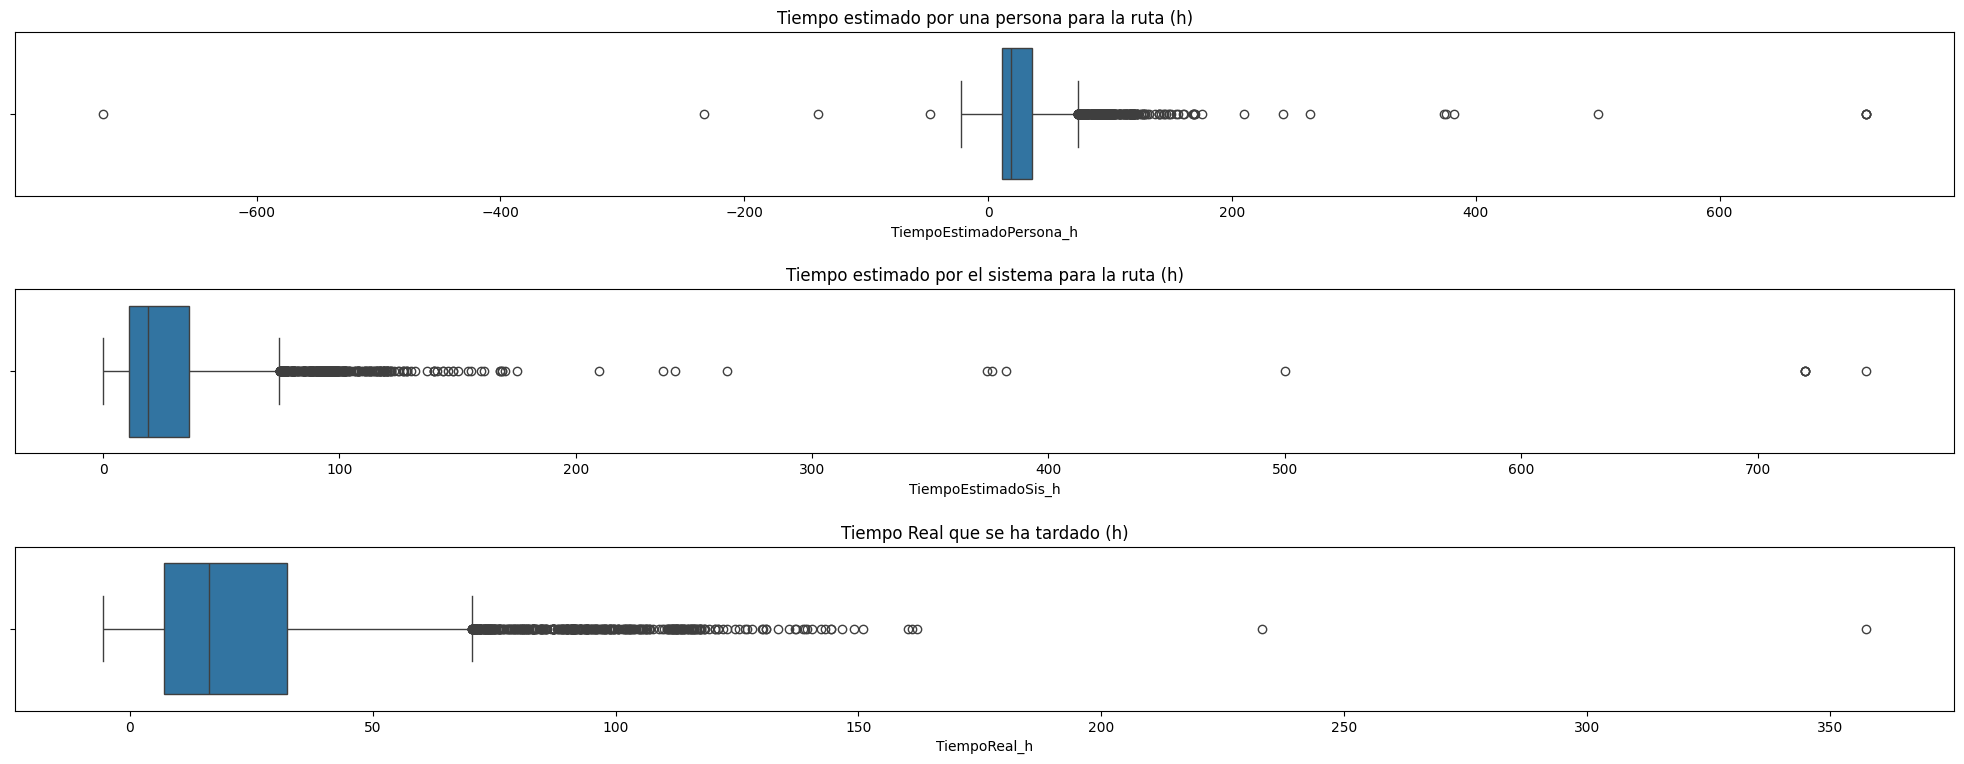

In [355]:
b = df.drop_duplicates(subset='IdRuta')
fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(20,8))
sns.boxplot(x=b['TiempoEstimadoPersona_h'], ax=ax[0]).set_title("Tiempo estimado por una persona para la ruta (h)")
sns.boxplot(x=b['TiempoEstimadoSis_h'], ax=ax[1]).set_title("Tiempo estimado por el sistema para la ruta (h)")
sns.boxplot(x=b['TiempoReal_h'], ax=ax[2]).set_title("Tiempo Real que se ha tardado (h)")
plt.ticklabel_format(style='plain', axis='x')
fig.tight_layout(pad=2)

CierreRuta
CerradoATiempo       6791
CerradoAutomatico      50
Name: count, dtype: int64


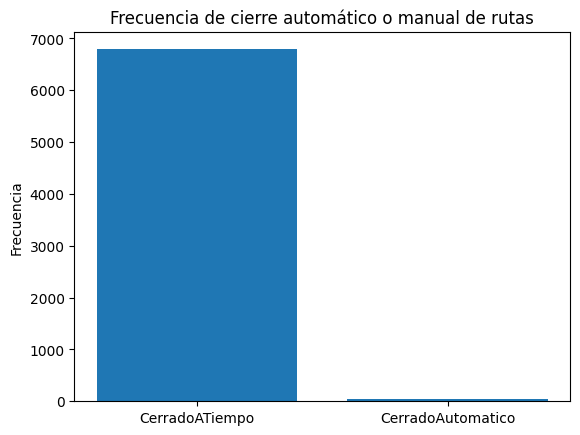

In [356]:
frecuencias = b['CierreRuta'].value_counts()
plt.bar(frecuencias.index, frecuencias.values)
plt.ylabel('Frecuencia')
plt.title('Frecuencia de cierre automático o manual de rutas')
print(b['CierreRuta'].value_counts())

Análisis de fallos por falta de datos (sin fechas) en las rutas

In [357]:
nulosEstimadoIni = filtro['fecha_desde'].isna().sum()
nulosEstimadoFin = filtro['fecha_hasta'].isna().sum()
nulosRealIni = filtro['Fecha_Inicio_Real'].isna().sum()
nulosRealFin = filtro['Fecha_Final_Real'].isna().sum()
nulosMargen = filtro['MargenSuperior'].isna().sum()

p1 = (nulosEstimadoIni / len(filtro['fecha_desde'])) * 100
p2 = (nulosEstimadoFin / len(filtro['fecha_hasta'])) * 100
print("Nulos en fechas ini y fin estimadas: " + str(p1) + "% " + str(p2) + "%")
p1 = (nulosRealIni / len(filtro['Fecha_Inicio_Real'])) * 100
p2 = (nulosRealFin / len(filtro['Fecha_Final_Real'])) * 100
print("Nulos en fechas ini y fin reales: " + str(p1) + "% " + str(p2) + "%")
p1 = (nulosMargen / len(filtro['MargenSuperior'])) * 100
print("Nulos en margenes: " + str(p1) + "%")

Nulos en fechas ini y fin estimadas: 0.011502185415228893% 0.011502185415228893%
Nulos en fechas ini y fin reales: 20.70393374741201% 0.8166551644812515%
Nulos en margenes: 0.0%


### Comparaciones y regresión lineal

Diferencia entre tiempos estimados

In [358]:
paraTiempos = df.drop_duplicates(subset='IdRuta').dropna(subset=['TiempoEstimadoPersona_h', 'TiempoEstimadoSis_h'])[['TiempoEstimadoPersona_h', 'TiempoEstimadoSis_h']]
difsAbs = list()
difsRel = list()

for index, row in paraTiempos.iterrows():
    diferenciaAbsoluta = abs(row["TiempoEstimadoPersona_h"] - row["TiempoEstimadoSis_h"])
    difsAbs.append(diferenciaAbsoluta)
    diferenciaRelativa = 1
    if (row["TiempoEstimadoSis_h"] == 0):
        print(row["TiempoEstimadoPersona_h"], row["TiempoEstimadoSis_h"])
    else:
        diferenciaRelativa = diferenciaAbsoluta / row["TiempoEstimadoSis_h"]
    difsRel.append(diferenciaRelativa)

0.0 0.0
-4.0 0.0
-11.0 0.0
-11.0 0.0
0.0 0.0
-6.0 0.0
-3.0 0.0
-6.0 0.0
-6.0 0.0
-6.5 0.0
-12.0 0.0
-5.0 0.0
-12.0 0.0
0.0 0.0
-20.0 0.0
0.0 0.0
-5.0 0.0
0.0 0.0
-4.5 0.0
-1.0 0.0
-17.0 0.0
-4.5 0.0
0.0 0.0
-2.13 0.0
0.0 0.0
-2.78 0.0
-0.5 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-8.0 0.0
0.0 0.0
-2.5 0.0
-9.0 0.0
-14.0 0.0
-9.0 0.0
-3.0 0.0
-2.0 0.0
-5.0 0.0
-1.0 0.0
-5.75 0.0
0.0 0.0
-7.0 0.0
-2.0 0.0
0.0 0.0
-19.5 0.0
-22.0 0.0
0.0 0.0
-14.5 0.0
0.0 0.0
0.0 0.0
-6.0 0.0
-3.0 0.0
0.0 0.0
-15.5 0.0
-6.0 0.0
-2.0 0.0
-8.5 0.0
-13.75 0.0
-4.5 0.0
-1.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-5.0 0.0
-0.25 0.0
-0.32 0.0
0.0 0.0
-6.38 0.0
0.0 0.0
-2.0 0.0
-5.0 0.0
0.0 0.0
-10.0 0.0
-726.0 0.0
0.0 0.0
0.0 0.0
-233.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-5.25 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-4.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-12.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-1.0 0.0
0.0 0

In [359]:
print(len(paraTiempos),len(set(df["IdRuta"])))


8692 8694


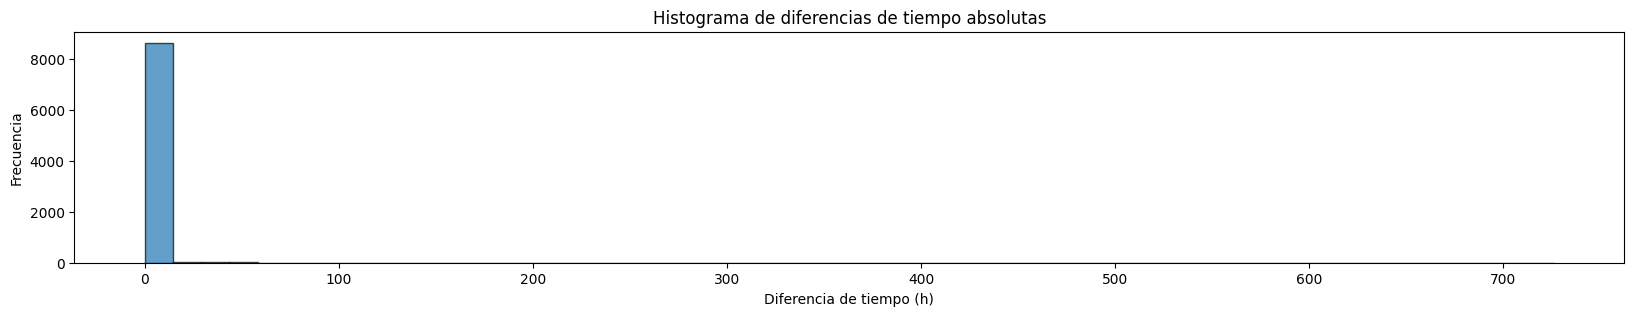

8692 7996


In [360]:
plt.figure(figsize=(20, 3))
plt.hist(difsAbs, bins=50, edgecolor='black', alpha=0.7)
plt.title('Histograma de diferencias de tiempo absolutas')
plt.xlabel('Diferencia de tiempo (h)')
plt.ylabel('Frecuencia')
plt.show()
print(len(difsAbs),difsAbs.count(0))

0.9199263690750115

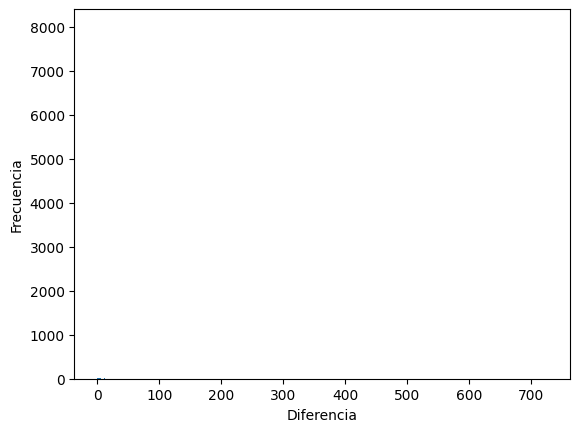

In [361]:
c = Counter(difsAbs)
plt.bar(c.keys(), c.values())
plt.xlabel("Diferencia")
plt.ylabel("Frecuencia")
c[0]/len(difsAbs)

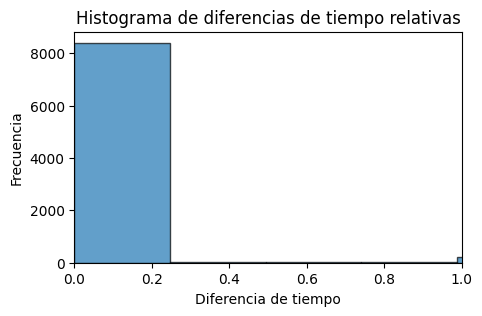

In [362]:
plt.figure(figsize=(5, 3))
plt.hist(difsRel, bins=100, edgecolor='black', alpha=0.7)
plt.xlim(0, 1)
plt.title('Histograma de diferencias de tiempo relativas')
plt.xlabel('Diferencia de tiempo')
plt.ylabel('Frecuencia')
plt.show()

In [363]:
conTiempoReal = df.drop_duplicates(subset='IdRuta').dropna(subset=['TiempoEstimadoPersona_h', 'TiempoEstimadoSis_h', 'TiempoReal_h'])[['IdRuta','TiempoEstimadoPersona_h', 'TiempoEstimadoSis_h', 'TiempoReal_h']]
difsAbsR = list()

for index, row in conTiempoReal.iterrows():
    diferenciaAbsoluta = row["TiempoEstimadoSis_h"] - row["TiempoReal_h"]
    if diferenciaAbsoluta >= 30 or diferenciaAbsoluta <= -30:
        print(row['IdRuta'], )
        pass
    if diferenciaAbsoluta == 0:
        pass
        #print(row['IdRuta'], row["TiempoEstimadoSis_h"], row["TiempoReal_h"])
    difsAbsR.append(diferenciaAbsoluta)
conTiempoReal = conTiempoReal.assign(DiferenciaAbsoluta=difsAbsR)
conTiempoReal

2085.0
2559.0
2604.0
2608.0
2609.0
2626.0
2711.0
2734.0
3088.0
3093.0
3155.0
3548.0
3555.0
3599.0
3830.0
3836.0
3838.0
3846.0
3867.0
3871.0
4033.0
4081.0
4118.0
4158.0
4200.0
4202.0
4239.0
4264.0
4269.0
4345.0
4400.0
4409.0
4415.0
4450.0
4589.0
4652.0
4654.0
4696.0
4720.0
4723.0
4807.0
4855.0
4923.0
5074.0
5075.0
5168.0
5177.0
5289.0
5339.0
5343.0
5358.0
5368.0
5446.0
5491.0
5554.0
5586.0
5668.0
5699.0
5733.0
5735.0
5775.0
5803.0
5815.0
5816.0
5854.0
5885.0
5893.0
5903.0
5929.0
5988.0
6074.0
6075.0
6140.0
6200.0
6302.0
6375.0
6488.0
6491.0
6493.0
6567.0
6703.0
6826.0
6888.0
6900.0
6945.0
6954.0
7008.0
7012.0
7097.0
7111.0
7114.0
7227.0
7280.0
7374.0
7419.0
7474.0
7492.0
7504.0
7534.0
7536.0
7556.0
7685.0
7731.0
7737.0
7822.0
7846.0
7851.0
7852.0
7853.0
7973.0
8025.0
8152.0
8154.0
8184.0
8233.0
8319.0
8321.0
8356.0
8357.0
8358.0
8385.0
8394.0
8416.0
8417.0
8422.0
8430.0
8450.0
8469.0
8470.0
8634.0
8642.0
8836.0
8910.0
8911.0
8923.0
8967.0
8975.0
9044.0
9060.0
9072.0
9203.0
9207.0
9209.0

IdRuta  TiempoEstimadoPersona_h  TiempoEstimadoSis_h  TiempoReal_h  \
0        1549                    24.00                24.00          0.00   
11       1551                    15.00                15.00         12.14   
18       1553                    11.00                11.00         10.48   
30       1555                    14.00                14.00          8.32   
38       1559                    35.00                35.00         18.58   
...       ...                      ...                  ...           ...   
52366   23410                    49.75                49.75         29.39   
52378   23414                    47.00                47.00         55.34   
52398   23424                    15.75                15.75         11.91   
52404   23426                    15.75                15.75          0.10   
52430   23430                    38.00                38.00          8.56   

       DiferenciaAbsoluta  
0                   24.00  
11                   2.86  
18                   0.52  
30                   5.68  
38                  16.42  
...                   ...  
52366               20.36  
52378               -8.34  
52398                3.84  
52404               15.65  
52430               29.44  

[6841 rows x 5 columns]

In [364]:
plt.figure(figsize=(10, 8))
plt.hist(difsAbsR, bins=600, edgecolor='black', alpha=0.7)
plt.title('Histograma de diferencias de tiempo entre el estimado para la ruta y el real')
plt.xlabel('Diferencia de tiempo (h)')
plt.ylabel('Frecuencia')
plt.xlim(-50,50) 
plt.xticks(range(-50, 51, 5)) 
plt.show()

De entre los tiempos que parecen reales (no se introduce mismo inicio y final) estudiar características cuando la diferencia de tiempo es grande

In [365]:
rutas = set(conTiempoReal["IdRuta"])
filtro = rc_av[rc_av["IdRuta"].isin(rutas)]
def diasSemanaTiempos(row):
    filaRCAV = filtro[filtro["IdRuta"] == row["IdRuta"]].iloc[0]
    formato = "%Y-%m-%d %H:%M:%S.%f"
    iniSis, finSis, iniReal, finReal, diaIniSis,diaFinSis, diaIniReal, diaFinReal = None, None, None, None, None, None, None, None
    if not pd.isna(filaRCAV["fecha_desde"]) and not pd.isna(filaRCAV["fecha_hasta"]):
        iniSis = filaRCAV["fecha_desde"]
        finSis = filaRCAV["fecha_hasta"]
        diaIniSis = datetime.strptime(filaRCAV["fecha_desde"], formato).weekday()
        diaFinSis = datetime.strptime(filaRCAV["fecha_hasta"], formato).weekday()

    if not pd.isna(filaRCAV["Fecha_Inicio_Real"]) and not pd.isna(filaRCAV["Fecha_Final_Real"]):
        iniReal = filaRCAV["Fecha_Inicio_Real"]
        finReal = filaRCAV["Fecha_Final_Real"]
        diaIniReal = datetime.strptime(filaRCAV["Fecha_Inicio_Real"], formato).weekday()
        diaFinReal = datetime.strptime(filaRCAV["Fecha_Final_Real"], formato).weekday()
    elif not pd.isna(filaRCAV["Fecha_Final_Real"]):
        diaFinReal = datetime.strptime(filaRCAV["Fecha_Final_Real"], formato).weekday()
        finReal = filaRCAV["Fecha_Final_Real"]

    
    return iniSis, finSis, iniReal, finReal, diaIniSis, diaFinSis, diaIniReal, diaFinReal
conTiempoReal[["IniSis", "FinSis", "IniReal", "FinReal", "DiaIniSis", "DiaFinSis", "DiaIniReal", "DiaFinReal"]] = conTiempoReal.apply(diasSemanaTiempos, axis=1, result_type='expand')

In [366]:
df_filtrado = conTiempoReal[(conTiempoReal["IniReal"] != conTiempoReal["FinReal"]) & (conTiempoReal["IniSis"] != conTiempoReal["FinSis"]) & (conTiempoReal["DiferenciaAbsoluta"] >= 15)]

In [367]:
frecuencias_col1 = df_filtrado['DiaIniSis'].value_counts()
frecuencias_col2 = df_filtrado['DiaFinSis'].value_counts()
frecuencias_col3 = df_filtrado['DiaIniReal'].value_counts()
frecuencias_col4 = df_filtrado['DiaFinReal'].value_counts()

# Crear un nuevo DataFrame con las frecuencias
frecuencias_df = pd.concat([frecuencias_col1, frecuencias_col2, frecuencias_col3, frecuencias_col4], axis=1)
frecuencias_df.columns = ['InicioSis','FinSis', 'InicioReal', 'FinReal']

# Crear el diagrama de barras
fig = px.bar(frecuencias_df, x=frecuencias_df.index, y=['InicioSis','FinSis', 'InicioReal', 'FinReal'],
             title='Frecuencias de días con mucha diferencia')
fig.update_layout(xaxis_title='Día semana (0-6/Lunes-Domingo)', yaxis_title='Frecuencia', barmode='overlay')

In [368]:
df_filtrado = conTiempoReal[conTiempoReal["DiferenciaAbsoluta"] == 0]
fechasCopiadas = ((df_filtrado['IniSis'] == df_filtrado['IniReal']) & (df_filtrado['IniReal'] == df_filtrado['FinReal']))
fechasCopiadas.mean() * 100


0.0

Regresión lineal

In [369]:
X_train, X_test, y_train, y_test = train_test_split(np.array(paraTiempos["TiempoEstimadoSis_h"]).reshape((-1, 1)), paraTiempos["TiempoEstimadoPersona_h"], test_size=0.2, random_state=42)
#entrenar modelo
modelo = LinearRegression().fit(X_train,y_train)
#predecir 
y_pred = modelo.predict(X_test)

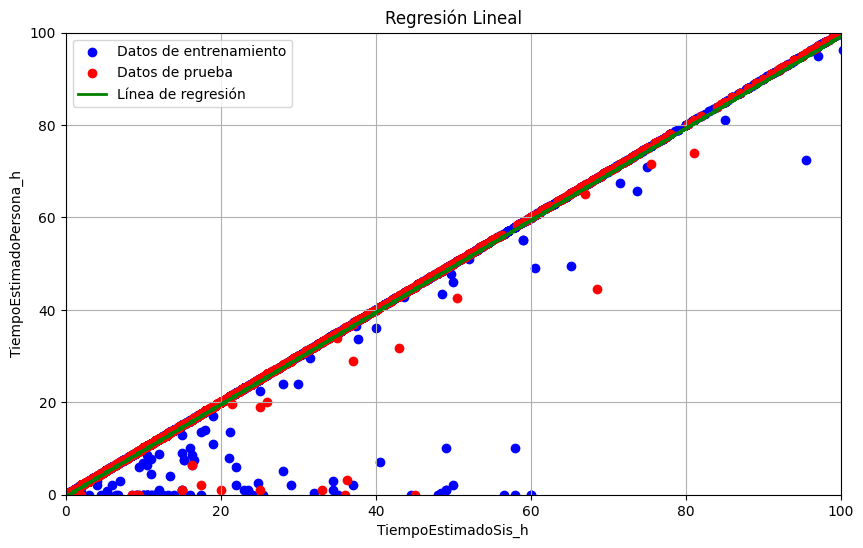

In [370]:
# Paso 5: Visualización
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.scatter(X_train, y_train, color='blue', label='Datos de entrenamiento')
# Graficar datos de prueba
plt.scatter(X_test, y_test, color='red', label='Datos de prueba')

# Graficar línea de regresión
plt.plot(X_test, y_pred, color='green', linewidth=2, label='Línea de regresión')

plt.title('Regresión Lineal')
plt.xlabel('TiempoEstimadoSis_h')
plt.ylabel('TiempoEstimadoPersona_h')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

Conclusión: son demasiado parecidos, no merece la pena hacer regresión lineal.

In [371]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Error Cuadrático Medio (MSE):", mse)
print("Coeficiente de determinación (R^2):", r2)

Error Cuadrático Medio (MSE): 296.8636771641077
Coeficiente de determinación (R^2): 0.6859714499225757


## Análisis de clientes

In [372]:
clientes = pd.read_csv("Grupos_Pedidos.csv", delimiter=';', encoding='cp1252')
clientes

Id_GrupoPedidos             NombreGrupoPedidos             Descripcion  \
0                  1             LODISNA FRANCE SAS  Creado automaticamente   
1                  2                           XXXX  Creado automaticamente   
2                  3           CATERPILLAR (NI) LTD  Creado automaticamente   
3                  4     FEDEX EXPRESS SPAIN S.L.U.  Creado automaticamente   
4                  5        VAN DUUREN INTERPORT BV  Creado automaticamente   
..               ...                            ...                     ...   
354              355          TALOG SOLUTIONS MITRY  Creado automaticamente   
355              356                 TRANSEUROPE CJ  Creado automaticamente   
356              357         DHL FREIGHT FRANCE SAS  Creado automaticamente   
357              358        SAS MALHERBE TRANSPORTS  Creado automaticamente   
358              359  ABREU - CARGA E TRANSITOS LDA  Creado automaticamente   

                  Fecha_Alta  Fecha_Baja          Fecha_Ult_Modif  Id_User  \
0    2023-06-05 16:27:40.513         NaN  2023-06-05 16:27:40.513      189   
1    2023-06-05 17:46:49.583         NaN  2023-06-05 17:46:49.583      189   
2    2023-06-08 13:35:30.360         NaN  2023-06-08 13:35:30.360      189   
3    2023-06-13 09:18:32.970         NaN  2023-06-13 09:18:32.970      189   
4    2023-06-13 15:27:28.107         NaN  2023-06-13 15:27:28.107      189   
..                       ...         ...                      ...      ...   
354  2024-04-04 16:17:01.037         NaN  2024-04-04 16:17:01.037      189   
355  2024-04-04 16:35:45.323         NaN  2024-04-04 16:35:45.323      189   
356  2024-04-04 20:12:17.750         NaN  2024-04-04 20:12:17.750      189   
357  2024-04-05 12:05:36.480         NaN  2024-04-05 12:05:36.480      189   
358  2024-04-05 13:29:06.187         NaN  2024-04-05 13:29:06.187      189   

     RouteApproach  AlarmaETA  AlarmaPtoPer  AlarmaPtoNop     Alias  
0              NaN        NaN           NaN           NaN  C0000794  
1              NaN        NaN           NaN           NaN  C0000868  
2              NaN        NaN           NaN           NaN  C0000587  
3              NaN        NaN           NaN           NaN  C0000271  
4              NaN        1.0           NaN           NaN  C0000558  
..             ...        ...           ...           ...       ...  
354            NaN        NaN           NaN           NaN  C0000159  
355            NaN        NaN           NaN           NaN  C0000157  
356            NaN        NaN           NaN           NaN  C0000422  
357            NaN        NaN           NaN           NaN  C0000215  
358            NaN        NaN           NaN           NaN  C0000871  

[359 rows x 12 columns]

In [373]:
clientes_pedidos = pd.read_csv("Pedidos_grupos.csv", delimiter=';', encoding='cp1252')
clientes_pedidos

Id_Grupo  Id_Pedido  Id_PG
0             1          1      1
1             1          2      2
2             1          3      3
3             1          5      4
4             1          6      5
...         ...        ...    ...
14645        10      16565  14649
14646        10      16566  14650
14647        10      16567  14651
14648        10      16568  14652
14649        10      16569  14653

[14650 rows x 3 columns]

Compruebo si todos los pedidos con los que trabajo tienen asociado un cliente

In [374]:
pedidosSinCliente = set(df["Id_Pedido"]).difference(set(clientes_pedidos["Id_Pedido"]))
print(len(pedidosSinCliente))
len(pedidosSinCliente)/len(set(df["Id_Pedido"]))

1314


0.17178716172048633

In [375]:
df_con_clientes = df[~df["Id_Pedido"].isin(pedidosSinCliente)]
df_con_clientes = df_con_clientes.merge(clientes_pedidos,how="inner",left_on="Id_Pedido",right_on="Id_Pedido")
df_con_clientes = df_con_clientes.merge(clientes[["Id_GrupoPedidos", "NombreGrupoPedidos"]], how="inner",left_on="Id_Grupo",right_on="Id_GrupoPedidos")

In [376]:
a = set()
clientesLugares = defaultdict(lambda:defaultdict(lambda:0))
for ruta in set(df_con_clientes["IdRuta"]):
    filtro = df_con_clientes[df_con_clientes["IdRuta"] == ruta]
    localidades = primer_no_nan(filtro["LocalidadReal"])
    cliente = filtro.iloc[0]["NombreGrupoPedidos"]
    if cliente == "FEDEX EXPRESS NETHERLANDS B.V.":
        a.add(filtro.iloc[0]["Id_Pedido"])
    clientesLugares[cliente][localidades] += 1

df_con_clientes.drop_duplicates(subset="IdRuta")[df_con_clientes["Id_Pedido"].isin(a)]["NombreGrupoPedidos"]

C:\Users\migue\AppData\Local\Temp\ipykernel_4828\1759801706.py:11: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



218      FEDEX EXPRESS NETHERLANDS B.V.
222      FEDEX EXPRESS NETHERLANDS B.V.
449      FEDEX EXPRESS NETHERLANDS B.V.
453      FEDEX EXPRESS NETHERLANDS B.V.
457      FEDEX EXPRESS NETHERLANDS B.V.
                      ...              
44157    FEDEX EXPRESS NETHERLANDS B.V.
44340    FEDEX EXPRESS NETHERLANDS B.V.
44532    FEDEX EXPRESS NETHERLANDS B.V.
44710    FEDEX EXPRESS NETHERLANDS B.V.
44787    FEDEX EXPRESS NETHERLANDS B.V.
Name: NombreGrupoPedidos, Length: 909, dtype: object

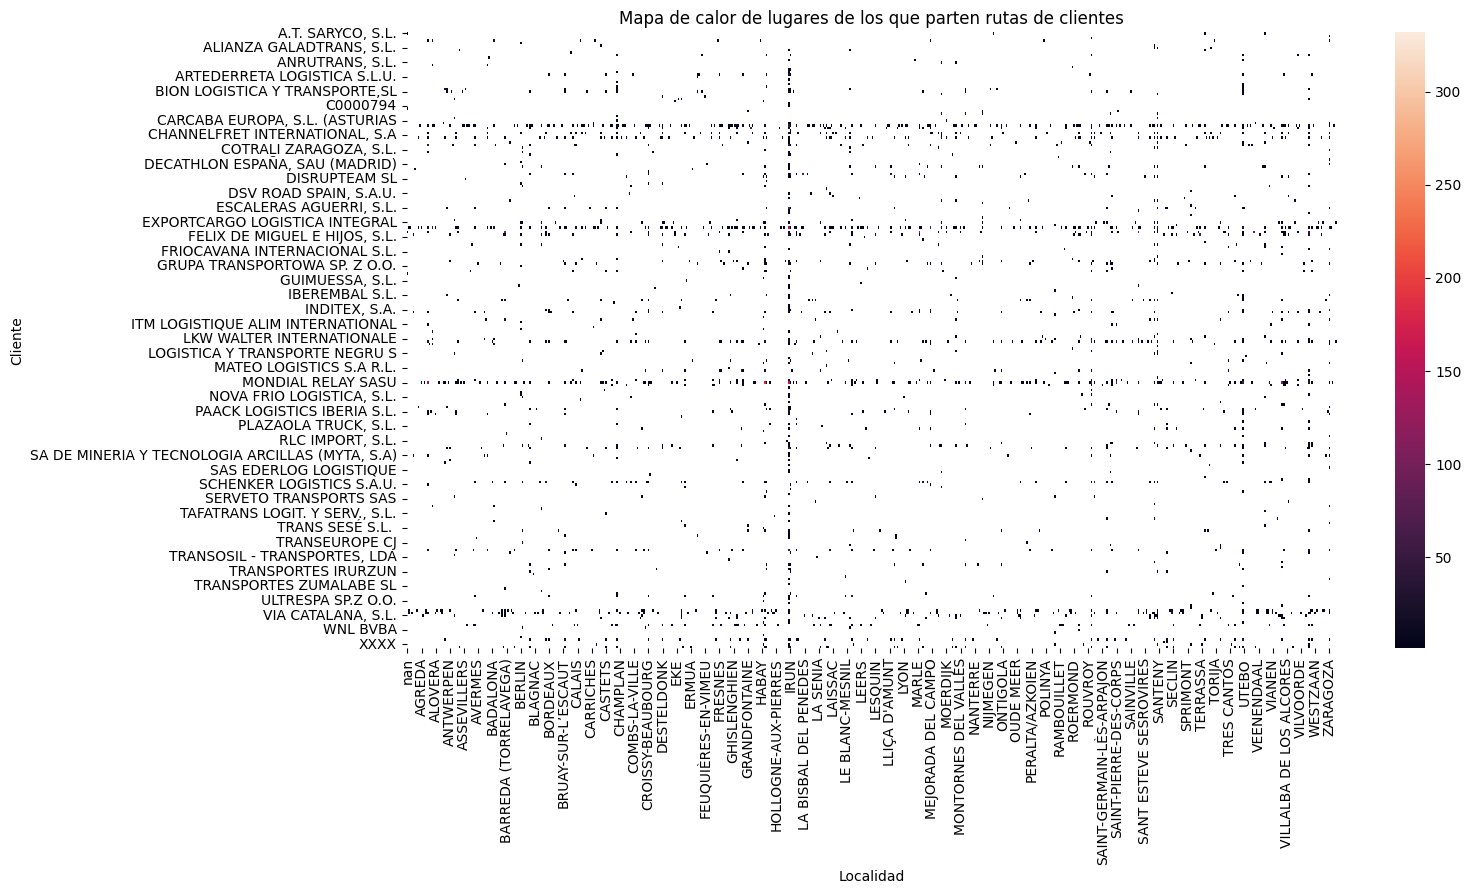

In [377]:
filas = []
for cliente, localidades in clientesLugares.items():
    for localidad, valor in localidades.items():
        filas.append([cliente, localidad, valor])

# Crear el DataFrame
dfClientesLocalidades = pd.DataFrame(filas, columns=["Cliente", "Localidad", "Frecuencia"])

'''random.seed()
df_muestra = dfClientesLocalidades.sample(n=150)'''
plt.figure(figsize=(15, 8))
sns.heatmap(dfClientesLocalidades.pivot(index="Cliente", columns="Localidad", values="Frecuencia"))
plt.title("Mapa de calor de lugares de los que parten rutas de clientes")
plt.xlabel("Localidad")
plt.ylabel("Cliente")
plt.show()

In [378]:
ordenado = dfClientesLocalidades.sort_values(by="Frecuencia", ascending=False)
ordenado.to_csv('ClientesLugaresMasFrecuentes.csv', index=False, sep=';') 
ordenado


Cliente               Localidad  Frecuencia
173   FEDEX EXPRESS NETHERLANDS B.V.  SAINT-PIERRE-DES-CORPS         332
1319              MONDIAL RELAY SASU                  HARNES         183
1324              MONDIAL RELAY SASU               IMARCOAIN         160
304     FASHION LOGISTICS FORWARDERS               IMARCOAIN         149
174   FEDEX EXPRESS NETHERLANDS B.V.          MARLY LA VILLE         134
...                              ...                     ...         ...
947                   INL CARGO B.V.        AULNAY-SOUS-BOIS           1
946                   INL CARGO B.V.                  VIANEN           1
944                   INL CARGO B.V.                    MECO           1
943                   INL CARGO B.V.       ALCALA DE HENARES           1
2176   ABREU - CARGA E TRANSITOS LDA                    RÉAU           1

[2177 rows x 3 columns]

## Pedidos vacíos y no vacíos

Análisis pedidos vacíos:

In [379]:
npedidos = set(df["NPedido"])
npedidos_vacios = set()
numvacios = 0
for pedido in npedidos:
    if "_vacio" in pedido:
        numvacios += 1
        npedidos_vacios.add(pedido)
print(len(npedidos))
print(numvacios)
porcentaje = numvacios * 100 / len(npedidos)
print(str(round(porcentaje, 2)) + '%')
solo_vacios = df.loc[df["NPedido"].isin(npedidos_vacios)]

nombres_comunes = set(solo_vacios["NPedido"].str.replace("_vacio1","")).intersection(npedidos)
solo_version_no_vacio = df.loc[df["NPedido"].isin(nombres_comunes)]
solo_vacios = solo_vacios[solo_vacios["NPedido"].str.replace("_vacio1","").isin(nombres_comunes)]


7571
1236
16.33%


In [380]:
solo_vacios

Id_Pedido                  NPedido  Estado  Id_Marca_Ini  Id_Marca_Fin  \
19             4  PT23015609_10000_vacio1       4          4301          4313   
21             4  PT23015609_10000_vacio1       4          4301          4313   
23             4  PT23015609_10000_vacio1       4          4301          4313   
25             4  PT23015609_10000_vacio1       4          4301          4313   
27             4  PT23015609_10000_vacio1       4          4301          4313   
...          ...                      ...     ...           ...           ...   
52465      16550  PT24010758_10000_vacio1       5          4524          2456   
52467      16550  PT24010758_10000_vacio1       5          4524          2456   
52469      16550  PT24010758_10000_vacio1       5          4524          2456   
52471      16550  PT24010758_10000_vacio1       5          4524          2456   
52473      16550  PT24010758_10000_vacio1       5          4524          2456   

       Id_Movimiento CodigoViaje  Id_Vehiculo Matricula  Id_Conductor  ...  \
19                 4  VJ23023860         1989   9024MDF          3829  ...   
21                 4  VJ23023860         1989   9024MDF          3829  ...   
23                 4  VJ23023860         1989   9024MDF          3829  ...   
25                 4  VJ23023860         1989   9024MDF          3829  ...   
27                 4  VJ23023860         1989   9024MDF          3829  ...   
...              ...         ...          ...       ...           ...  ...   
52465          10915  VJ24015396         2222   9165MMZ          3482  ...   
52467          10915  VJ24015396         2222   9165MMZ          3482  ...   
52469          10915  VJ24015396         2222   9165MMZ          3482  ...   
52471          10915  VJ24015396         2222   9165MMZ          3482  ...   
52473          10915  VJ24015396         2222   9165MMZ          3482  ...   

      MismoOrigenDestinoPais   Origen Lat_origen  Long_origen  Destino  \
19                      True    RONCQ   50,75418     3,129473   BRUGES   
21                      True    RONCQ   50,75418     3,129473   BRUGES   
23                      True    RONCQ   50,75418     3,129473   BRUGES   
25                      True    RONCQ   50,75418     3,129473   BRUGES   
27                      True    RONCQ   50,75418     3,129473   BRUGES   
...                      ...      ...        ...          ...      ...   
52465                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   
52467                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   
52469                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   
52471                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   
52473                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   

      Lat_destino Long_destino  TiempoEstimadoPersona_h  TiempoReal_h  \
19       44,89148    -0,606973                     11.0         10.48   
21       44,89148    -0,606973                     11.0         10.48   
23       44,89148    -0,606973                     11.0         10.48   
25       44,89148    -0,606973                     11.0         10.48   
27       44,89148    -0,606973                     11.0         10.48   
...           ...          ...                      ...           ...   
52465     48,5885     2,435812                     67.0           NaN   
52467     48,5885     2,435812                     67.0           NaN   
52469     48,5885     2,435812                     67.0           NaN   
52471     48,5885     2,435812                     67.0           NaN   
52473     48,5885     2,435812                     67.0           NaN   

              CierreRuta  
19     CerradoAutomatico  
21     CerradoAutomatico  
23     CerradoAutomatico  
25     CerradoAutomatico  
27     CerradoAutomatico  
...                  ...  
52465                NaN  
52467                NaN  
52469                NaN  
52471                NaN  
52473                NaN  

[7469 

In [381]:
solo_version_no_vacio

Id_Pedido           NPedido  Estado  Id_Marca_Ini  Id_Marca_Fin  \
18             3  PT23015609_10000       4          4313          3751   
20             3  PT23015609_10000       4          4313          3751   
22             3  PT23015609_10000       4          4313          3751   
24             3  PT23015609_10000       4          4313          3751   
26             3  PT23015609_10000       4          4313          3751   
...          ...               ...     ...           ...           ...   
52466      16498  PT24010758_10000       6          2527          5062   
52468      16498  PT24010758_10000       6          2527          5062   
52470      16498  PT24010758_10000       6          2527          5062   
52472      16498  PT24010758_10000       6          2527          5062   
52474      16498  PT24010758_10000       6          2527          5062   

       Id_Movimiento CodigoViaje  Id_Vehiculo Matricula  Id_Conductor  ...  \
18                 4  VJ23023860         1989   9024MDF          3829  ...   
20                 4  VJ23023860         1989   9024MDF          3829  ...   
22                 4  VJ23023860         1989   9024MDF          3829  ...   
24                 4  VJ23023860         1989   9024MDF          3829  ...   
26                 4  VJ23023860         1989   9024MDF          3829  ...   
...              ...         ...          ...       ...           ...  ...   
52466          10915  VJ24015396         2222   9165MMZ          3482  ...   
52468          10915  VJ24015396         2222   9165MMZ          3482  ...   
52470          10915  VJ24015396         2222   9165MMZ          3482  ...   
52472          10915  VJ24015396         2222   9165MMZ          3482  ...   
52474          10915  VJ24015396         2222   9165MMZ          3482  ...   

      MismoOrigenDestinoPais   Origen Lat_origen  Long_origen  Destino  \
18                      True    RONCQ   50,75418     3,129473   BRUGES   
20                      True    RONCQ   50,75418     3,129473   BRUGES   
22                      True    RONCQ   50,75418     3,129473   BRUGES   
24                      True    RONCQ   50,75418     3,129473   BRUGES   
26                      True    RONCQ   50,75418     3,129473   BRUGES   
...                      ...      ...        ...          ...      ...   
52466                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   
52468                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   
52470                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   
52472                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   
52474                   True  URRUGNE   43,35976    -1,695572  VILLABÉ   

      Lat_destino Long_destino  TiempoEstimadoPersona_h  TiempoReal_h  \
18       44,89148    -0,606973                     11.0         10.48   
20       44,89148    -0,606973                     11.0         10.48   
22       44,89148    -0,606973                     11.0         10.48   
24       44,89148    -0,606973                     11.0         10.48   
26       44,89148    -0,606973                     11.0         10.48   
...           ...          ...                      ...           ...   
52466     48,5885     2,435812                     67.0           NaN   
52468     48,5885     2,435812                     67.0           NaN   
52470     48,5885     2,435812                     67.0           NaN   
52472     48,5885     2,435812                     67.0           NaN   
52474     48,5885     2,435812                     67.0           NaN   

              CierreRuta  
18     CerradoAutomatico  
20     CerradoAutomatico  
22     CerradoAutomatico  
24     CerradoAutomatico  
26     CerradoAutomatico  
...                  ...  
52466                NaN  
52468                NaN  
52470                NaN  
52472                NaN  
52474                NaN  

[9750 rows x 59 columns]

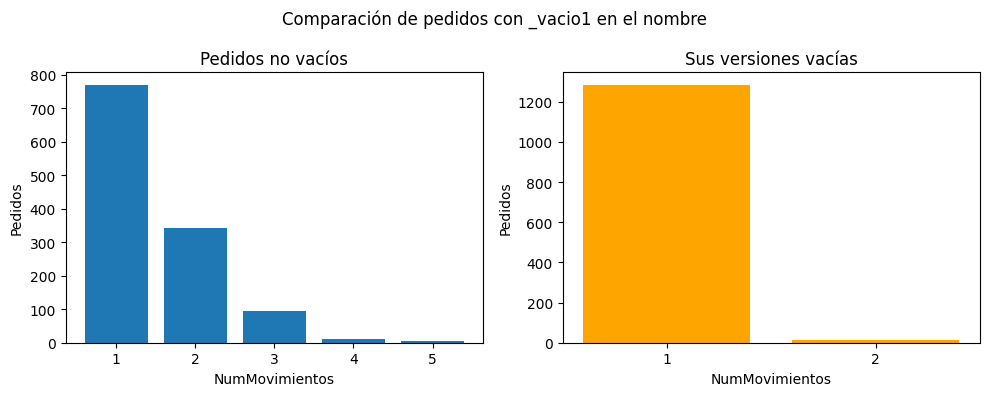

In [382]:
c1 = Counter(list(solo_version_no_vacio.drop_duplicates(subset='Id_Pedido')["NumMovimientos"]))
c2 = Counter(list(solo_vacios.drop_duplicates(subset='Id_Pedido')["NumMovimientos"]))
# Crear subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].bar(c1.keys(), c1.values())
ax[0].set_title('Pedidos no vacíos')
ax[0].set_xlabel('NumMovimientos')
ax[0].set_ylabel('Pedidos')

ax[1].bar(c2.keys(), c2.values(), color='orange')
ax[1].set_title('Sus versiones vacías')
ax[1].set_xlabel('NumMovimientos')
ax[1].set_ylabel('Pedidos')
ax[1].set_xlim(0.5, 2.5)
ax[1].set_xticks([1, 2])

fig.suptitle("Comparación de pedidos con _vacio1 en el nombre")
plt.tight_layout()
plt.show()

In [383]:
c1 = Counter(list(solo_version_no_vacio.drop_duplicates(subset='IdRuta')["NumPuntos"]))
c2 = Counter(list(solo_vacios.drop_duplicates(subset='IdRuta')["NumPuntos"]))
# Crear subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].bar(c1.keys(), c1.values())
ax[0].set_title('Pedidos no vacíos')
ax[0].set_xlabel('NumPuntos')
ax[0].set_ylabel('Rutas')

ax[1].bar(c2.keys(), c2.values(), color='orange')
ax[1].set_title('Sus versiones vacías')
ax[1].set_xlabel('NumPuntos')
ax[1].set_ylabel('Rutas')

fig.suptitle("Comparación de pedidos y versiones con _vacio1 en el nombre")
plt.tight_layout()
plt.show()

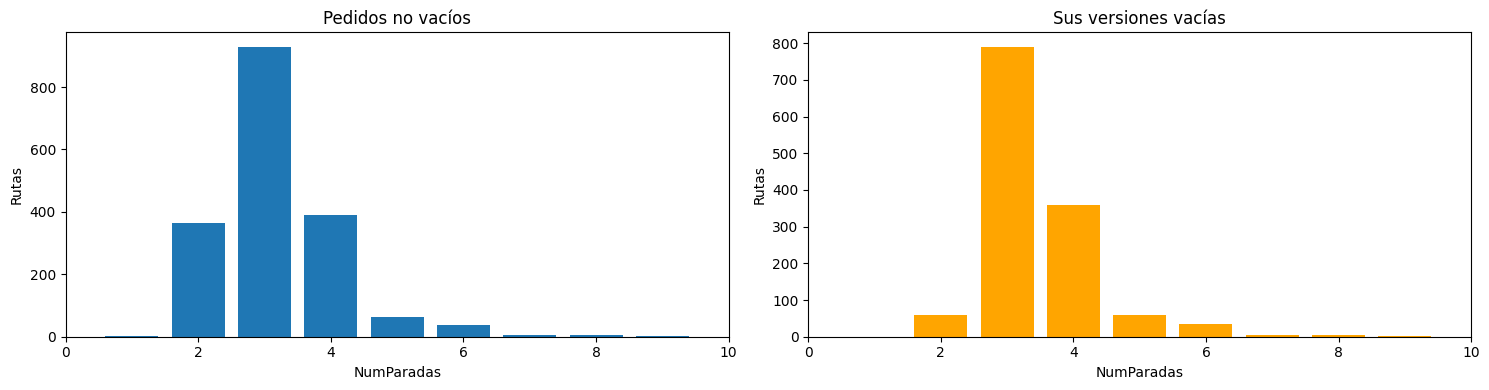

In [384]:
c1 = Counter(list(solo_version_no_vacio.drop_duplicates(subset='IdRuta')["NumParadas"]))
c2 = Counter(list(solo_vacios.drop_duplicates(subset='IdRuta')["NumParadas"]))
# Crear subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

ax[0].bar(c1.keys(), c1.values())
ax[0].set_title('Pedidos no vacíos')
ax[0].set_xlabel('NumParadas')
ax[0].set_ylabel('Rutas')
ax[0].set_xlim(0,10)

ax[1].bar(c2.keys(), c2.values(), color='orange')
ax[1].set_title('Sus versiones vacías')
ax[1].set_xlabel('NumParadas')
ax[1].set_ylabel('Rutas')
ax[1].set_xlim(0,10)

plt.tight_layout()
plt.show()

In [385]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 6))

# Primer boxplot: Pedidos vacíos
sns.boxplot(x=solo_vacios.drop_duplicates(subset='IdRuta')['DistanciaReal_km'], ax=ax1)
ax1.set_title("Longitudes distancias rutas (Km) (Pedidos vacíos)")
ax1.ticklabel_format(style='plain', axis='x')

# Segundo boxplot: Pedidos no vacíos
sns.boxplot(x=solo_version_no_vacio.drop_duplicates(subset='IdRuta')['DistanciaReal_km'], ax=ax2)
ax2.set_title("Longitudes distancias rutas (Km) (Pedidos no vacíos)")
ax2.ticklabel_format(style='plain', axis='x')

fig.tight_layout(pad=2)
plt.show()

In [386]:
diferencias_distancia = solo_vacios.drop_duplicates(subset='IdRuta')['DistanciaReal_km'] -  solo_version_no_vacio.drop_duplicates(subset='IdRuta')['DistanciaReal_km']
len(solo_vacios.drop_duplicates(subset='NPedido'))

1221

Se encuentra un ejemplo en el que el movimiento del pedido vacío se corresponde con uno del original. Por tanto, se verifica si se cumple para todos.

In [387]:
conjunto_parejas = pd.concat([solo_version_no_vacio, solo_vacios], ignore_index=True)


In [388]:
contador = 0
for pedido in set(solo_version_no_vacio["NPedido"]):
    filtro_no_vacios = solo_version_no_vacio[solo_version_no_vacio["NPedido"] == pedido]
    filtro_vacios = solo_vacios[solo_vacios["NPedido"].str.replace("_vacio1", "") == pedido]
    '''
    print(set(filtro_vacios["IdRuta"]))
    print(set(filtro_no_vacios["IdRuta"]))
    print("----------------------------------------------")
    '''
    if set(filtro_vacios["IdRuta"]) <= set(filtro_no_vacios["IdRuta"]):
        contador += 1
    else:
        print(set(filtro_vacios["IdRuta"]))
        print(set(filtro_no_vacios["IdRuta"]))
        print("----------------------------------------------")
    

{11084}
{10892}
----------------------------------------------
{10477, 10325}
{10316, 10325}
----------------------------------------------
{17794, 16797}
{17793, 17794, 17787, 17795}
----------------------------------------------
{12738, 12750}
{12738, 12634}
----------------------------------------------
{9076}
{9024}
----------------------------------------------
{15082}
{15084}
----------------------------------------------
{14537}
{14591}
----------------------------------------------
{20612, 20782}
{20612, 20197}
----------------------------------------------
{21220}
{21195}
----------------------------------------------
{19754, 19414}
{19414, 19295}
----------------------------------------------
{21289, 21533}
{21048}
----------------------------------------------
{19713}
{20060, 22348}
----------------------------------------------
{14371, 14661}
{14298, 14371}
----------------------------------------------
{12800}
{12535}
----------------------------------------------
{22113, 

In [389]:
print(contador)
contador * 100 / len(set(solo_version_no_vacio["NPedido"]))

1180


96.64209664209665

## Grafo de localidades

In [390]:
filtro = df.drop_duplicates(subset='IdRuta')
pesosAristas = filtro.groupby(['Origen', 'Destino']).size().reset_index(name='peso')
G = nx.DiGraph()

# El peso del nodo es el número de viajes que parten o van a la localidad
for node in set(pesosAristas['Origen']).union(set(pesosAristas['Destino'])):
    node_weight = filtro[(filtro['Origen'] == node) | (filtro['Destino'] == node)].shape[0]
    G.add_node(node, weight=node_weight)

# El peso de las aristas será el número de viajes de origen a destino
for _, row in pesosAristas.iterrows():
    G.add_edge(row['Origen'], row['Destino'], weight=row['peso'])
print(G.nodes(data=True))
print(G.edges(data=True))

[('RIJSENHOUT', {'weight': 1}), ('MARLE', {'weight': 3}), ('GUILLENA', {'weight': 4}), ('MARCILLA', {'weight': 2}), ('SENONCHES', {'weight': 1}), ('HASTINGUES', {'weight': 199}), ('AULNAY-SOUS-BOIS', {'weight': 100}), ('ALTZAGA', {'weight': 1}), ('ARRASATE/MONDRAGON', {'weight': 6}), ('BISIMBRE', {'weight': 2}), ('ANTONY', {'weight': 3}), ('WETTEREN', {'weight': 7}), ('MECHELEN', {'weight': 1}), ('DEROUA OULAD ZIANE', {'weight': 9}), ('SAUVIAN', {'weight': 1}), ('BEAUCHAMP', {'weight': 1}), ('DOKKUM', {'weight': 1}), ('MONTBARTIER', {'weight': 117}), ('OSS', {'weight': 3}), ('BARAKALDO', {'weight': 2}), ('DZ BERGAMBACHT', {'weight': 1}), ('PRESLES-EN-BRIE', {'weight': 1}), ('PALENCIA', {'weight': 6}), ('NIEUWKERKEN-WAAS', {'weight': 2}), ('SAINT-WITZ', {'weight': 3}), ('CUBELLES', {'weight': 1}), ('PALAISEAU', {'weight': 1}), ('LANÇON-PROVENCE', {'weight': 1}), ('MOISSY-CRAMAYEL', {'weight': 2}), ('BERCHEM-SAINTE-AGATHE', {'weight': 2}), ('BLANQUEFORT', {'weight': 3}), ('AALTER', {'wei

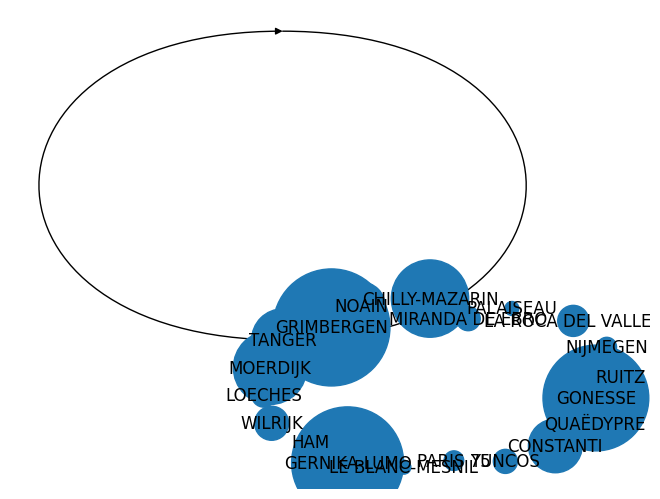

In [391]:
random_nodes = random.sample(sorted(G.nodes()), 20)
# Crear un subgrafo con los nodos aleatorios y los enlaces asociados
subgraph = G.subgraph(random_nodes)
# Obtener los pesos de los nodos
pesos = nx.get_node_attributes(subgraph, 'weight')

# cambia el tamaño según el peso 
node_size = [pesos[node] * 100 for node in subgraph.nodes()]

# Dibujar el grafo
pos = nx.spring_layout(subgraph) 
nx.draw(subgraph, pos, with_labels=True, node_size=node_size)

plt.show()

### Eligiendo clientes

In [392]:
filtro = df_con_clientes.drop_duplicates(subset='IdRuta')
print(set(filtro["NombreGrupoPedidos"]))
filtro = filtro[filtro["Id_GrupoPedidos"] == 71] # 71-inditex, 10-fashion logistics, 132-rlc sevilla, 130-aduanas alie
                                                    # 14-lodisna transport logistics, 192 8-xpo transport solutions
aristas = filtro.groupby(['Origen', 'Destino']).size().reset_index(name='peso')
GCliente = nx.DiGraph()

# El peso del nodo es el número de viajes que parten o van a la localidad
for node in set(filtro['Origen']).union(set(filtro['Destino'])):
    node_weight = filtro[(filtro['Origen'] == node) | (filtro['Destino'] == node)].shape[0]
    GCliente.add_node(node, weight=node_weight)

# Guardar coordenadas reales de los nodos para dibujarlos en su lugar real
posNodos = dict()

# El peso de la arista es la distancia en kilómetros entre las dos localidades (geográficamente)
# / Antiguo: El peso de las aristas será el número de viajes de origen a destino 
for _, row in filtro.iterrows():
    origen = row['Origen']
    destino = row['Destino']
    # Para que tenga sentido en el dibujo del grafo, hay que invertir latitud y longitud
    posNodos[origen] = (float(row["Long_origen"].replace(',', '.')), float(row["Lat_origen"].replace(',', '.')))
    posNodos[destino] = (float(row["Long_destino"].replace(',', '.')), float(row["Lat_destino"].replace(',', '.')))
    peso = geopy.distance.geodesic((row["Lat_origen"].replace(',', '.'), row["Long_origen"].replace(',', '.')),
                                   (row["Lat_destino"].replace(',', '.'), row["Long_destino"].replace(',', '.'))).km
    peso = 1 / np.log(peso + 1) * 10 if np.log(peso + 1) > 0 else 0 # PESOS EN ESCALA LOGARÍTMICA PARA NORMALIZAR TAMAÑOS Y USO EL INVERSO YA QUE EN EL LAYOUT
                                     # MAYOR PESO DE LA ARISTA ES MENOS DISTANCIA
    GCliente.add_edge(origen, destino, weight=peso)
print(GCliente.nodes(data=True))
print(GCliente.edges(data=True))

{'COUSO GAREA E HIJOS , S.L.', 'GRUPO LOGISTICO ARNEDO SLU', 'ALUCOIL S.A.', 'ELJO EXALTO TRANSPORT B.V.', 'TRANSANDALUS INTERNATIONAL LOG', 'TRACCION Y LOGISTICA SL', 'MESTRANS, S.L.', 'MONDIAL RELAY S.A.S.U. ES', 'CODOGNOTTO FRANCE SASU', 'PANTANY LOGISTIC, S.L.', 'DACHSER SPAIN, S.A.', 'JARATRANS S.L.U.', 'XPO TRANSPORT SOLUTIONS S.L.', 'C0000794', 'ADUANAS ALIE SA', 'INTERLOGIC B.V.', 'QUALITY FREIGHT LTD', 'CAMPILLO PALMERA, S.L.', 'SAS EIKON LOGISTICS', 'FASHION RETAIL, S.A.', 'PAN-EUROPA S.L', 'WILD CATRANS, SL', 'MTA', 'TRANSPORTES CALSINA Y CARRE, SL', 'SPEDITION LOGISTIK M2, S.L.', 'CHANNELFRET INTERNATIONAL, S.A', 'ROCKWOOL PENINSULAR, S.A.U.', 'HEPPNER', 'SACYTRANS S.L.', 'TRANSPORTES SARCEDA, S.L.', 'BALERO XXI SA (BAMESA)', 'LKW WALTER INTERNATIONALE', 'DISTRIBUCION LOGISTICA LOS ESPARTALES S.L', 'OROMAS,S.A.', 'FICALTRANS SL', 'INDITEX, S.A.', 'NORDEX ENERGY SPAIN, S.A. ', 'ABREU - CARGA E TRANSITOS LDA', 'IGOA Y PATXI, S.L.', 'LGL TRANSPORT SARL', 'TRANSEUROPE CJ', 'TAF

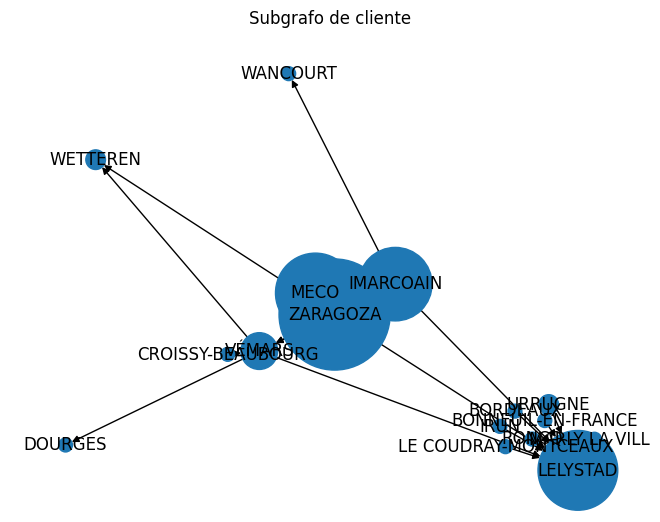

In [393]:
# Obtener los pesos de los nodos
pesos = nx.get_node_attributes(GCliente, 'weight')

# cambia el tamaño según el peso 
node_size = [pesos[node] * 100 for node in GCliente.nodes()]

# Dibujar el grafo
pos = nx.spring_layout(GCliente) 
nx.draw(GCliente, pos, with_labels=True, node_size=node_size)
plt.title("Subgrafo de cliente")
plt.show()

Normalizar posiciones al rango -1 1 (es opcional usarlo ya que los dibujos con las coordenadas reales se ven bien)

In [394]:
# Función para normalizar los valores
def normalize(value, min_val, max_val, new_min, new_max):
    return (value - min_val) / (max_val - min_val) * (new_max - new_min) + new_min

# Obtener los valores mínimos y máximos de las coordenadas actuales
min_x = min(posNodos.values(), key=lambda x: x[0])[0]
max_x = max(posNodos.values(), key=lambda x: x[0])[0]
min_y = min(posNodos.values(), key=lambda x: x[1])[1]
max_y = max(posNodos.values(), key=lambda x: x[1])[1]

# Normalizar posiciones al rango -1 a 1
pos_normalizadas = {}
for node, (x, y) in pos.items():
    norm_x = normalize(x, min_x, max_x, -1, 1)
    norm_y = normalize(y, min_y, max_y, -1, 1)
    pos_normalizadas[node] = (norm_x, norm_y)

In [395]:
# Asignar posiciones a los nodos
#pos = nx.spring_layout(GCliente)
for node in GCliente.nodes():
    GCliente.nodes[node]['pos'] = posNodos[node]
    #print(pos[node])

# Extraer coordenadas para aristas
edge_x = []
edge_y = []
annotations = []
for edge in GCliente.edges():
    x0, y0 = GCliente.nodes[edge[0]]['pos']
    x1, y1 = GCliente.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# Agregar direccionalidad de la arista
    annotations.append(
        dict(
            ax=x0, ay=y0,
            axref='x', ayref='y',
            x=x1, y=y1,
            xref='x', yref='y',
            showarrow=True,
            arrowhead=2,
            arrowsize=2,
            arrowwidth=1,
            arrowcolor='#888'
        )
    )

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='text',
    mode='lines')

# Extraer coordenadas y pesos para nodos
node_x = []
node_y = []
node_weights = []
node_text = []
for node in GCliente.nodes():
    x, y = GCliente.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    node_weights.append(GCliente.nodes[node]['weight'])
    node_text.append(f'Localidad: {node}, Peso: {GCliente.nodes[node]["weight"]}')

# Normalizar los tamaños de los nodos usando escala logarítmica
node_sizes = [np.log(weight + 1) * 10 for weight in node_weights]  # Sumar 1 para evitar log(0)


node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    text=node_text,
    marker=dict(
        showscale=True,  # Mostrar escala de colores
        colorscale='aggrnyl', # Escala de colores | viridis sunset blues ice aggrnyl
        color=node_weights,  # Asignar pesos como colores
        size=node_sizes,  # Tamaño relativo al peso
        line_width=2
    ))

# Crear la figura
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='<br>Grafo para cliente',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                    annotations=annotations,  # Agregar las direcciones
                    width=1600,  
                    height=850 
                    ))

fig.show()

In [396]:
posNodos

{'MECO': (-3.31991, 40.53035),
 'ZARAGOZA': (-1.01309, 41.62811),
 'BORDEAUX': (-0.553682, 44.8877),
 'LELYSTAD': (5.4856, 52.47439),
 'LE COUDRAY-MONTCEAUX': (2.46584, 48.56757),
 'IMARCOAIN': (-1.61407, 42.729),
 'MARLY LA VILLE': (2.521896, 49.09119),
 'IRUN': (-1.753123, 43.33797),
 'RONCQ': (3.134487, 50.75467),
 'VÉMARS': (2.550003, 49.07077),
 'WANCOURT': (2.865141, 50.26189),
 'URRUGNE': (-1.695572, 43.35976),
 'BONNEUIL-EN-FRANCE': (2.45515, 48.96014),
 'DOURGES': (2.995527, 50.4433),
 'CROISSY-BEAUBOURG': (2.63667, 48.82602),
 'WETTEREN': (3.841803, 50.9701)}

## Etiquetas

In [397]:
seleccion = ['NumParadas', 'NumPuntos', 'DistanciaReal_km', 'NumConductores', 'NumCargasRuta', 'NumDescargasRuta', 'Id_Conductor', 'Origen']
paraReglas = df.drop_duplicates(subset='IdRuta').dropna(subset="DistanciaReal_km")[seleccion]
#paraReglas = paraReglas.groupby('Id_Pedido').agg({'NumParadas': 'sum', 'NumPuntos': 'sum', 'DistanciaReal_km': 'first', 'NumConductores' : 'first'}).reset_index()
paraReglas

NumParadas  NumPuntos  DistanciaReal_km  NumConductores  NumCargasRuta  \
0             3.0        5.0           634.605             1.0            1.0   
5             2.0        6.0           828.002             2.0            0.0   
11            3.0        7.0           838.591             2.0            1.0   
18            3.0        6.0           820.086             1.0            0.0   
30            4.0        8.0           336.978             2.0            1.0   
...           ...        ...               ...             ...            ...   
52433         3.0        4.0          1073.840             2.0            1.0   
52437         2.0        6.0          1337.525             2.0            0.0   
52443         4.0        6.0          1325.497             2.0            0.0   
52455         2.0        6.0           813.011             2.0            1.0   
52461         4.0        7.0           854.874             2.0            1.0   

       NumDescargasRuta  Id_Conductor                    Origen  
0                   0.0          3903                  ZARAGOZA  
5                   1.0          4127                    CESTAS  
11                  1.0           576                    HARNES  
18                  1.0          3829                     RONCQ  
30                  2.0           323                    ENNERY  
...                 ...           ...                       ...  
52433               1.0          2885  SANTA PERPETUA DE MOGODA  
52437               1.0          4251                   URRUGNE  
52443               2.0          4128         TRITH-SAINT-LÉGER  
52455               1.0          4465        BONNEUIL-EN-FRANCE  
52461               1.0          3482                   URRUGNE  

[8691 rows x 8 columns]

In [398]:
def e_distanciaRuta(row):
    if row["DistanciaReal_km"] <= 630:
        return "DistanciaCorta"
    elif row["DistanciaReal_km"] <= 1375:
        return "DistanciaMedia"
    else:
        return "DistanciaLarga"

In [399]:
paraReglas["LongRuta"] = paraReglas.apply(lambda row: e_distanciaRuta(row), axis=1)
paraReglas

NumParadas  NumPuntos  DistanciaReal_km  NumConductores  NumCargasRuta  \
0             3.0        5.0           634.605             1.0            1.0   
5             2.0        6.0           828.002             2.0            0.0   
11            3.0        7.0           838.591             2.0            1.0   
18            3.0        6.0           820.086             1.0            0.0   
30            4.0        8.0           336.978             2.0            1.0   
...           ...        ...               ...             ...            ...   
52433         3.0        4.0          1073.840             2.0            1.0   
52437         2.0        6.0          1337.525             2.0            0.0   
52443         4.0        6.0          1325.497             2.0            0.0   
52455         2.0        6.0           813.011             2.0            1.0   
52461         4.0        7.0           854.874             2.0            1.0   

       NumDescargasRuta  Id_Conductor                    Origen  \
0                   0.0          3903                  ZARAGOZA   
5                   1.0          4127                    CESTAS   
11                  1.0           576                    HARNES   
18                  1.0          3829                     RONCQ   
30                  2.0           323                    ENNERY   
...                 ...           ...                       ...   
52433               1.0          2885  SANTA PERPETUA DE MOGODA   
52437               1.0          4251                   URRUGNE   
52443               2.0          4128         TRITH-SAINT-LÉGER   
52455               1.0          4465        BONNEUIL-EN-FRANCE   
52461               1.0          3482                   URRUGNE   

             LongRuta  
0      DistanciaMedia  
5      DistanciaMedia  
11     DistanciaMedia  
18     DistanciaMedia  
30     DistanciaCorta  
...               ...  
52433  DistanciaMedia  
52437  DistanciaMedia  
52443  DistanciaMedia  
52455  DistanciaMedia  
52461  DistanciaMedia  

[8691 rows x 9 columns]

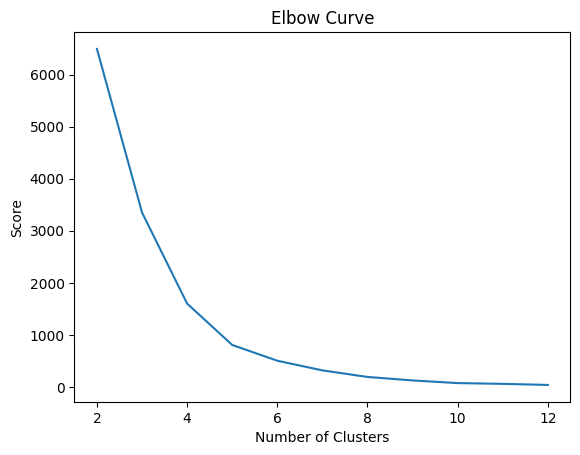

In [400]:
Nc = range(2, 13)
X = paraReglas['NumParadas']
X = X.dropna().values.reshape(-1, 1)
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [-kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [401]:
# Elijo usar 3 clusters
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[3.32467271]
 [9.29813665]
 [1.99775596]]


Text(0, 0.5, 'NumParadas')

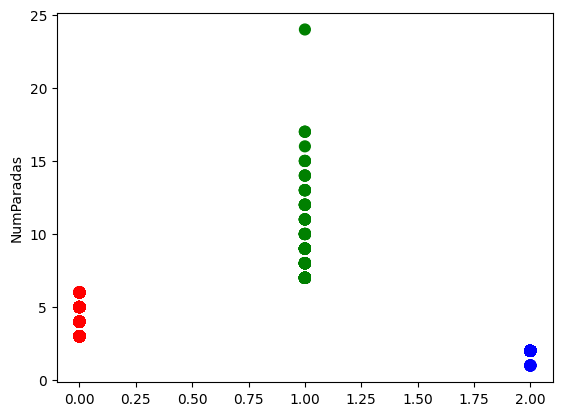

In [402]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig,ax =  plt.subplots()
ax.scatter(labels, X[:, 0], c=asignar,s=60)
ax.set_ylabel('NumParadas')

In [403]:
def e_numParadas(row):
    if not row["NumParadas"]:
        return None
    elif row["NumParadas"] <= 3:
        return "PocasParadas"
    elif row["NumParadas"] <= 8:
        return "BastantesParadas"
    else:
        return "GranNumParadas"

In [404]:
paraReglas["NumParadasE"] = df.apply(lambda row: e_numParadas(row), axis=1)
paraReglas

NumParadas  NumPuntos  DistanciaReal_km  NumConductores  NumCargasRuta  \
0             3.0        5.0           634.605             1.0            1.0   
5             2.0        6.0           828.002             2.0            0.0   
11            3.0        7.0           838.591             2.0            1.0   
18            3.0        6.0           820.086             1.0            0.0   
30            4.0        8.0           336.978             2.0            1.0   
...           ...        ...               ...             ...            ...   
52433         3.0        4.0          1073.840             2.0            1.0   
52437         2.0        6.0          1337.525             2.0            0.0   
52443         4.0        6.0          1325.497             2.0            0.0   
52455         2.0        6.0           813.011             2.0            1.0   
52461         4.0        7.0           854.874             2.0            1.0   

       NumDescargasRuta  Id_Conductor                    Origen  \
0                   0.0          3903                  ZARAGOZA   
5                   1.0          4127                    CESTAS   
11                  1.0           576                    HARNES   
18                  1.0          3829                     RONCQ   
30                  2.0           323                    ENNERY   
...                 ...           ...                       ...   
52433               1.0          2885  SANTA PERPETUA DE MOGODA   
52437               1.0          4251                   URRUGNE   
52443               2.0          4128         TRITH-SAINT-LÉGER   
52455               1.0          4465        BONNEUIL-EN-FRANCE   
52461               1.0          3482                   URRUGNE   

             LongRuta       NumParadasE  
0      DistanciaMedia      PocasParadas  
5      DistanciaMedia      PocasParadas  
11     DistanciaMedia      PocasParadas  
18     DistanciaMedia      PocasParadas  
30     DistanciaCorta  BastantesParadas  
...               ...               ...  
52433  DistanciaMedia      PocasParadas  
52437  DistanciaMedia      PocasParadas  
52443  DistanciaMedia  BastantesParadas  
52455  DistanciaMedia      PocasParadas  
52461  DistanciaMedia  BastantesParadas  

[8691 rows x 10 columns]

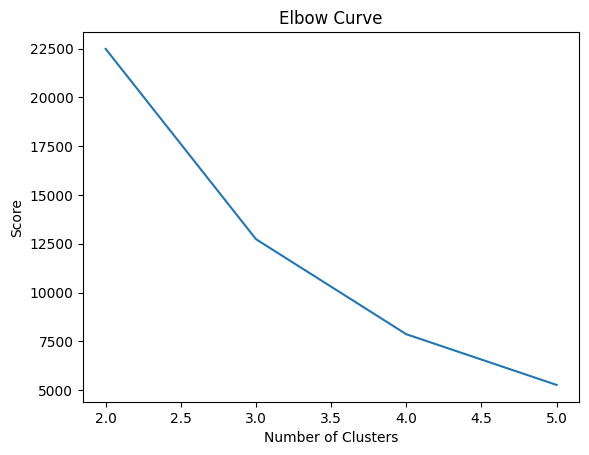

In [405]:
Nc = range(2, 6)
X = paraReglas['NumPuntos']
X = X.dropna().values.reshape(-1, 1)
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [-kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [406]:
# Elijo usar 3 clusters
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[5.36274908]
 [9.71126761]
 [2.57675351]]


Text(0, 0.5, 'NumPuntos')

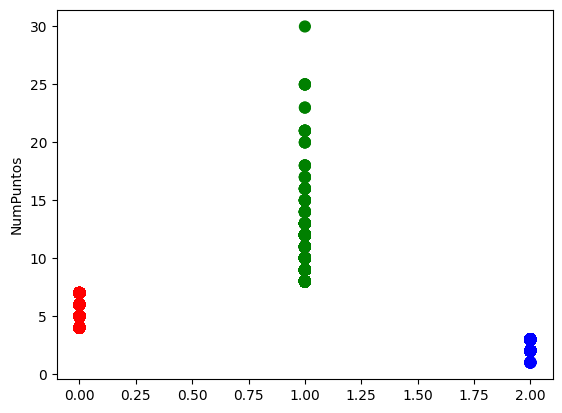

In [407]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig,ax =  plt.subplots()
ax.scatter(labels, X[:, 0], c=asignar,s=60)
ax.set_ylabel('NumPuntos')

In [408]:
def e_numPuntos(row):
    if row["NumPuntos"] <= 4:
        return "PocosPuntos"
    elif row["NumPuntos"] <= 9:
        return "BastantesPuntos"
    else:
        return "GranNumPuntos"

In [409]:
paraReglas["NumPuntosE"] = df.apply(lambda row: e_numPuntos(row), axis=1)
paraReglas

NumParadas  NumPuntos  DistanciaReal_km  NumConductores  NumCargasRuta  \
0             3.0        5.0           634.605             1.0            1.0   
5             2.0        6.0           828.002             2.0            0.0   
11            3.0        7.0           838.591             2.0            1.0   
18            3.0        6.0           820.086             1.0            0.0   
30            4.0        8.0           336.978             2.0            1.0   
...           ...        ...               ...             ...            ...   
52433         3.0        4.0          1073.840             2.0            1.0   
52437         2.0        6.0          1337.525             2.0            0.0   
52443         4.0        6.0          1325.497             2.0            0.0   
52455         2.0        6.0           813.011             2.0            1.0   
52461         4.0        7.0           854.874             2.0            1.0   

       NumDescargasRuta  Id_Conductor                    Origen  \
0                   0.0          3903                  ZARAGOZA   
5                   1.0          4127                    CESTAS   
11                  1.0           576                    HARNES   
18                  1.0          3829                     RONCQ   
30                  2.0           323                    ENNERY   
...                 ...           ...                       ...   
52433               1.0          2885  SANTA PERPETUA DE MOGODA   
52437               1.0          4251                   URRUGNE   
52443               2.0          4128         TRITH-SAINT-LÉGER   
52455               1.0          4465        BONNEUIL-EN-FRANCE   
52461               1.0          3482                   URRUGNE   

             LongRuta       NumParadasE       NumPuntosE  
0      DistanciaMedia      PocasParadas  BastantesPuntos  
5      DistanciaMedia      PocasParadas  BastantesPuntos  
11     DistanciaMedia      PocasParadas  BastantesPuntos  
18     DistanciaMedia      PocasParadas  BastantesPuntos  
30     DistanciaCorta  BastantesParadas  BastantesPuntos  
...               ...               ...              ...  
52433  DistanciaMedia      PocasParadas      PocosPuntos  
52437  DistanciaMedia      PocasParadas  BastantesPuntos  
52443  DistanciaMedia  BastantesParadas  BastantesPuntos  
52455  DistanciaMedia      PocasParadas  BastantesPuntos  
52461  DistanciaMedia  BastantesParadas  BastantesPuntos  

[8691 rows x 11 columns]

In [410]:
def e_conductores(row):
    if row["NumConductores"] == 1:
        return "UnConductor"
    else:
        return "DosConductores"

In [411]:
paraReglas["NumConductoresE"] = df.apply(lambda row: e_conductores(row), axis=1)
paraReglas

NumParadas  NumPuntos  DistanciaReal_km  NumConductores  NumCargasRuta  \
0             3.0        5.0           634.605             1.0            1.0   
5             2.0        6.0           828.002             2.0            0.0   
11            3.0        7.0           838.591             2.0            1.0   
18            3.0        6.0           820.086             1.0            0.0   
30            4.0        8.0           336.978             2.0            1.0   
...           ...        ...               ...             ...            ...   
52433         3.0        4.0          1073.840             2.0            1.0   
52437         2.0        6.0          1337.525             2.0            0.0   
52443         4.0        6.0          1325.497             2.0            0.0   
52455         2.0        6.0           813.011             2.0            1.0   
52461         4.0        7.0           854.874             2.0            1.0   

       NumDescargasRuta  Id_Conductor                    Origen  \
0                   0.0          3903                  ZARAGOZA   
5                   1.0          4127                    CESTAS   
11                  1.0           576                    HARNES   
18                  1.0          3829                     RONCQ   
30                  2.0           323                    ENNERY   
...                 ...           ...                       ...   
52433               1.0          2885  SANTA PERPETUA DE MOGODA   
52437               1.0          4251                   URRUGNE   
52443               2.0          4128         TRITH-SAINT-LÉGER   
52455               1.0          4465        BONNEUIL-EN-FRANCE   
52461               1.0          3482                   URRUGNE   

             LongRuta       NumParadasE       NumPuntosE NumConductoresE  
0      DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor  
5      DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores  
11     DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores  
18     DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor  
30     DistanciaCorta  BastantesParadas  BastantesPuntos  DosConductores  
...               ...               ...              ...             ...  
52433  DistanciaMedia      PocasParadas      PocosPuntos  DosConductores  
52437  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores  
52443  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores  
52455  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores  
52461  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores  

[8691 rows x 12 columns]

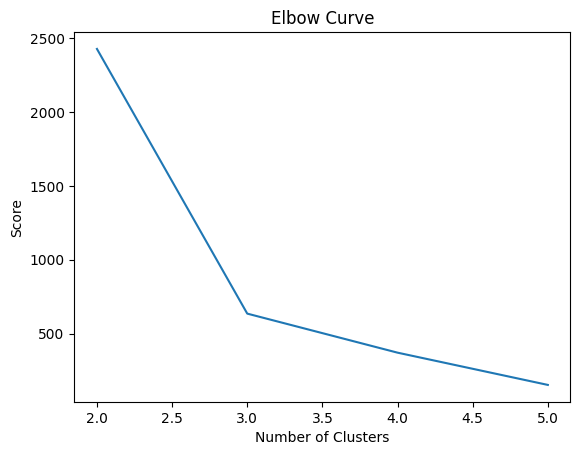

In [412]:
Nc = range(2, 6)
X = paraReglas['NumCargasRuta']
X = X.dropna().values.reshape(-1, 1)
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [-kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [413]:
# Elijo usar 3 clusters
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[5.00943396e+00]
 [6.77236045e-15]
 [1.09127714e+00]]


Text(0, 0.5, 'NumCargasRuta')

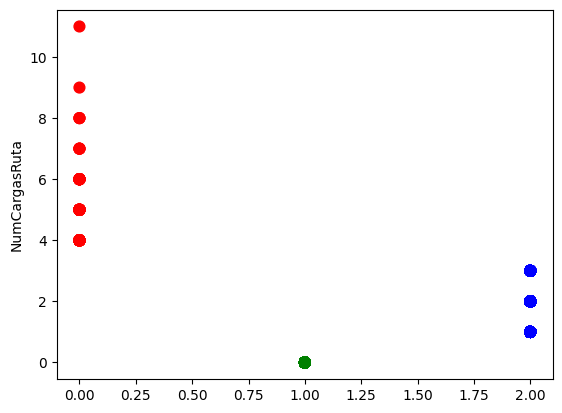

In [414]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig,ax =  plt.subplots()
ax.scatter(labels, X[:, 0], c=asignar,s=60)
ax.set_ylabel('NumCargasRuta')

In [415]:
def e_numCargas(row):
    if row["NumCargasRuta"] == 0:
        return "SinCargas"
    elif row["NumCargasRuta"] <= 2:
        return "PocasCargas"
    else:
        return "BastantesCargas"

In [416]:
paraReglas["NumCargasRutaE"] = df.apply(lambda row: e_numCargas(row), axis=1)
paraReglas

NumParadas  NumPuntos  DistanciaReal_km  NumConductores  NumCargasRuta  \
0             3.0        5.0           634.605             1.0            1.0   
5             2.0        6.0           828.002             2.0            0.0   
11            3.0        7.0           838.591             2.0            1.0   
18            3.0        6.0           820.086             1.0            0.0   
30            4.0        8.0           336.978             2.0            1.0   
...           ...        ...               ...             ...            ...   
52433         3.0        4.0          1073.840             2.0            1.0   
52437         2.0        6.0          1337.525             2.0            0.0   
52443         4.0        6.0          1325.497             2.0            0.0   
52455         2.0        6.0           813.011             2.0            1.0   
52461         4.0        7.0           854.874             2.0            1.0   

       NumDescargasRuta  Id_Conductor                    Origen  \
0                   0.0          3903                  ZARAGOZA   
5                   1.0          4127                    CESTAS   
11                  1.0           576                    HARNES   
18                  1.0          3829                     RONCQ   
30                  2.0           323                    ENNERY   
...                 ...           ...                       ...   
52433               1.0          2885  SANTA PERPETUA DE MOGODA   
52437               1.0          4251                   URRUGNE   
52443               2.0          4128         TRITH-SAINT-LÉGER   
52455               1.0          4465        BONNEUIL-EN-FRANCE   
52461               1.0          3482                   URRUGNE   

             LongRuta       NumParadasE       NumPuntosE NumConductoresE  \
0      DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor   
5      DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
11     DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
18     DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor   
30     DistanciaCorta  BastantesParadas  BastantesPuntos  DosConductores   
...               ...               ...              ...             ...   
52433  DistanciaMedia      PocasParadas      PocosPuntos  DosConductores   
52437  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
52443  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores   
52455  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
52461  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores   

      NumCargasRutaE  
0        PocasCargas  
5          SinCargas  
11       PocasCargas  
18         SinCargas  
30       PocasCargas  
...              ...  
52433    PocasCargas  
52437      SinCargas  
52443      SinCargas  
52455    PocasCargas  
52461    PocasCargas  

[8691 rows x 13 columns]

c:\Users\migue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning:

Number of distinct clusters (11) found smaller than n_clusters (12). Possibly due to duplicate points in X.

c:\Users\migue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning:

Number of distinct clusters (11) found smaller than n_clusters (13). Possibly due to duplicate points in X.

c:\Users\migue\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning:

Number of distinct clusters (11) found smaller than n_clusters (14). Possibly due to duplicate points in X.



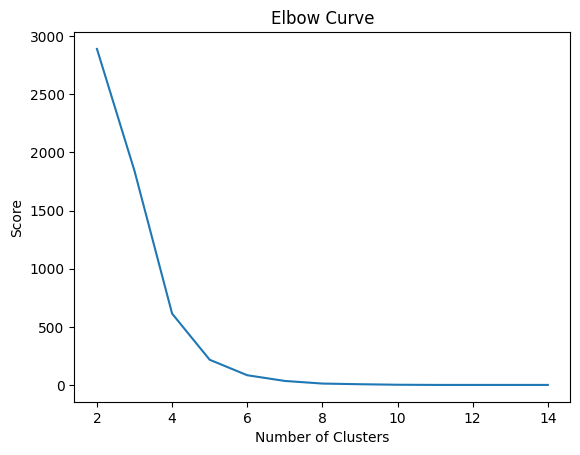

In [417]:
Nc = range(2, 15)
X = paraReglas['NumDescargasRuta']
X = X.dropna().values.reshape(-1, 1)
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [-kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [418]:
# Elijo usar 3 clusters
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[2.55461473e+00]
 [1.00000000e+00]
 [1.06581410e-14]]


Text(0, 0.5, 'NumDescargasRuta')

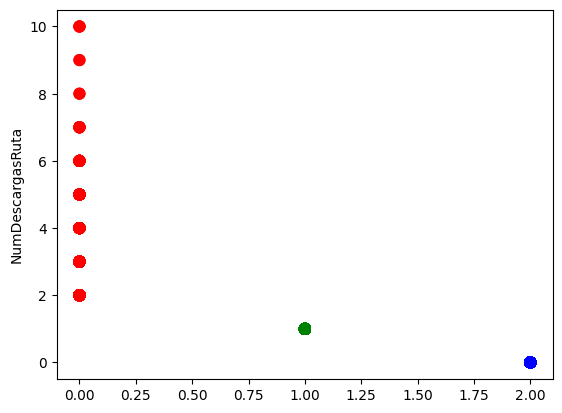

In [419]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig,ax =  plt.subplots()
ax.scatter(labels, X[:, 0], c=asignar,s=60)
ax.set_ylabel('NumDescargasRuta')

In [420]:
def e_numDescargas(row):
    if row["NumDescargasRuta"] == 0:
        return "SinDescargas"
    elif row["NumDescargasRuta"] <= 2:
        return "PocasDescargas"
    else:
        return "BastantesDescargas"

In [421]:
paraReglas["NumDescargasRutaE"] = df.apply(lambda row: e_numDescargas(row), axis=1)
paraReglas

NumParadas  NumPuntos  DistanciaReal_km  NumConductores  NumCargasRuta  \
0             3.0        5.0           634.605             1.0            1.0   
5             2.0        6.0           828.002             2.0            0.0   
11            3.0        7.0           838.591             2.0            1.0   
18            3.0        6.0           820.086             1.0            0.0   
30            4.0        8.0           336.978             2.0            1.0   
...           ...        ...               ...             ...            ...   
52433         3.0        4.0          1073.840             2.0            1.0   
52437         2.0        6.0          1337.525             2.0            0.0   
52443         4.0        6.0          1325.497             2.0            0.0   
52455         2.0        6.0           813.011             2.0            1.0   
52461         4.0        7.0           854.874             2.0            1.0   

       NumDescargasRuta  Id_Conductor                    Origen  \
0                   0.0          3903                  ZARAGOZA   
5                   1.0          4127                    CESTAS   
11                  1.0           576                    HARNES   
18                  1.0          3829                     RONCQ   
30                  2.0           323                    ENNERY   
...                 ...           ...                       ...   
52433               1.0          2885  SANTA PERPETUA DE MOGODA   
52437               1.0          4251                   URRUGNE   
52443               2.0          4128         TRITH-SAINT-LÉGER   
52455               1.0          4465        BONNEUIL-EN-FRANCE   
52461               1.0          3482                   URRUGNE   

             LongRuta       NumParadasE       NumPuntosE NumConductoresE  \
0      DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor   
5      DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
11     DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
18     DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor   
30     DistanciaCorta  BastantesParadas  BastantesPuntos  DosConductores   
...               ...               ...              ...             ...   
52433  DistanciaMedia      PocasParadas      PocosPuntos  DosConductores   
52437  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
52443  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores   
52455  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
52461  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores   

      NumCargasRutaE NumDescargasRutaE  
0        PocasCargas      SinDescargas  
5          SinCargas    PocasDescargas  
11       PocasCargas    PocasDescargas  
18         SinCargas    PocasDescargas  
30       PocasCargas    PocasDescargas  
...              ...               ...  
52433    PocasCargas    PocasDescargas  
52437      SinCargas    PocasDescargas  
52443      SinCargas    PocasDescargas  
52455    PocasCargas    PocasDescargas  
52461    PocasCargas    PocasDescargas  

[8691 rows x 14 columns]

In [422]:
def e_frecuenciaConductor(row):
    frecuencia = fLocalidadConductores[row["Origen"]]
    conductor1 = row["Id_Conductor"]
    if conductor1 is None or conductor1 == -1:
        return "ConductorExterno"
    if len(frecuencia) == 1 or row["Origen"] is None:
        return "UnicoConductor"
    elif conductor1 in max(frecuencia.items(), key=lambda x: x[0])[1]:
        return "ConductorMuyFrecuenteEntreVarios"
    elif conductor1 in min(frecuencia.items(), key=lambda x: x[0])[1]:
        return "ConductorPocoFrecuente"
    else:
        return "ConductorHabitual"

In [423]:
paraReglas["FrecuenciaConductor"] = df.apply(lambda row: e_frecuenciaConductor(row), axis=1)
paraReglas

NumParadas  NumPuntos  DistanciaReal_km  NumConductores  NumCargasRuta  \
0             3.0        5.0           634.605             1.0            1.0   
5             2.0        6.0           828.002             2.0            0.0   
11            3.0        7.0           838.591             2.0            1.0   
18            3.0        6.0           820.086             1.0            0.0   
30            4.0        8.0           336.978             2.0            1.0   
...           ...        ...               ...             ...            ...   
52433         3.0        4.0          1073.840             2.0            1.0   
52437         2.0        6.0          1337.525             2.0            0.0   
52443         4.0        6.0          1325.497             2.0            0.0   
52455         2.0        6.0           813.011             2.0            1.0   
52461         4.0        7.0           854.874             2.0            1.0   

       NumDescargasRuta  Id_Conductor                    Origen  \
0                   0.0          3903                  ZARAGOZA   
5                   1.0          4127                    CESTAS   
11                  1.0           576                    HARNES   
18                  1.0          3829                     RONCQ   
30                  2.0           323                    ENNERY   
...                 ...           ...                       ...   
52433               1.0          2885  SANTA PERPETUA DE MOGODA   
52437               1.0          4251                   URRUGNE   
52443               2.0          4128         TRITH-SAINT-LÉGER   
52455               1.0          4465        BONNEUIL-EN-FRANCE   
52461               1.0          3482                   URRUGNE   

             LongRuta       NumParadasE       NumPuntosE NumConductoresE  \
0      DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor   
5      DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
11     DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
18     DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor   
30     DistanciaCorta  BastantesParadas  BastantesPuntos  DosConductores   
...               ...               ...              ...             ...   
52433  DistanciaMedia      PocasParadas      PocosPuntos  DosConductores   
52437  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
52443  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores   
52455  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
52461  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores   

      NumCargasRutaE NumDescargasRutaE     FrecuenciaConductor  
0        PocasCargas      SinDescargas  ConductorPocoFrecuente  
5          SinCargas    PocasDescargas  ConductorPocoFrecuente  
11       PocasCargas    PocasDescargas       ConductorHabitual  
18         SinCargas    PocasDescargas  ConductorPocoFrecuente  
30       PocasCargas    PocasDescargas  ConductorPocoFrecuente  
...              ...               ...                     ...  
52433    PocasCargas    PocasDescargas  ConductorPocoFrecuente  
52437      SinCargas    PocasDescargas       ConductorHabitual  
52443      SinCargas    PocasDescargas  ConductorPocoFrecuente  
52455    PocasCargas    PocasDescargas  ConductorPocoFrecuente  
52461    PocasCargas    PocasDescargas       ConductorHabitual  

[8691 rows x 15 columns]

In [424]:
paraReglas = paraReglas.drop(columns=['NumParadas', 'NumPuntos', 'DistanciaReal_km', 'NumConductores', 'NumCargasRuta', 'NumDescargasRuta', 'Origen', 'Id_Conductor'])
paraReglas

LongRuta       NumParadasE       NumPuntosE NumConductoresE  \
0      DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor   
5      DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
11     DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
18     DistanciaMedia      PocasParadas  BastantesPuntos     UnConductor   
30     DistanciaCorta  BastantesParadas  BastantesPuntos  DosConductores   
...               ...               ...              ...             ...   
52433  DistanciaMedia      PocasParadas      PocosPuntos  DosConductores   
52437  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
52443  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores   
52455  DistanciaMedia      PocasParadas  BastantesPuntos  DosConductores   
52461  DistanciaMedia  BastantesParadas  BastantesPuntos  DosConductores   

      NumCargasRutaE NumDescargasRutaE     FrecuenciaConductor  
0        PocasCargas      SinDescargas  ConductorPocoFrecuente  
5          SinCargas    PocasDescargas  ConductorPocoFrecuente  
11       PocasCargas    PocasDescargas       ConductorHabitual  
18         SinCargas    PocasDescargas  ConductorPocoFrecuente  
30       PocasCargas    PocasDescargas  ConductorPocoFrecuente  
...              ...               ...                     ...  
52433    PocasCargas    PocasDescargas  ConductorPocoFrecuente  
52437      SinCargas    PocasDescargas       ConductorHabitual  
52443      SinCargas    PocasDescargas  ConductorPocoFrecuente  
52455    PocasCargas    PocasDescargas  ConductorPocoFrecuente  
52461    PocasCargas    PocasDescargas       ConductorHabitual  

[8691 rows x 7 columns]

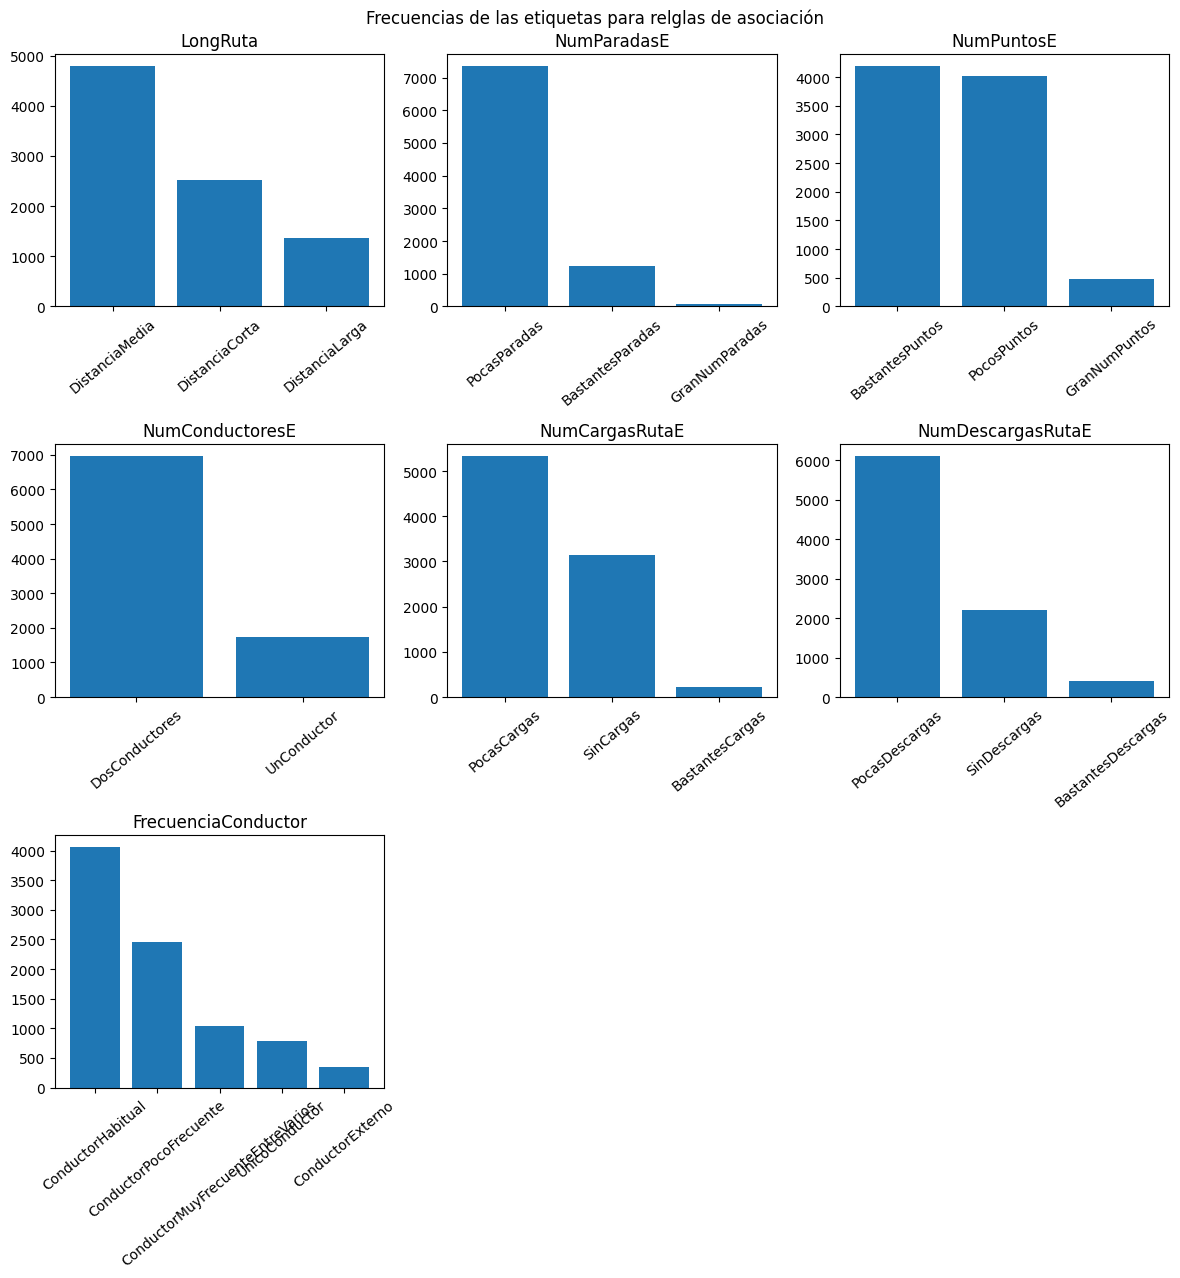

In [425]:
frequencies_df = pd.DataFrame(index=paraReglas.columns, columns=['Value', 'Frequency'])

# Iterar sobre cada columna y contar la frecuencia de cada valor
for column in paraReglas.columns:
    value_counts = paraReglas[column].value_counts()
    frequencies_df.loc[column, 'Value'] = value_counts.index
    frequencies_df.loc[column, 'Frequency'] = value_counts.values

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 13))

# Iterar sobre cada columna y crear un gráfico de barras
for i, column in enumerate(paraReglas.columns):
    plt.subplot(3, 3, i+1)
    plt.bar(frequencies_df.loc[column, 'Value'], frequencies_df.loc[column, 'Frequency'])
    plt.title(column)
    plt.xticks(rotation=40)

plt.suptitle("Frecuencias de las etiquetas para relglas de asociación")
plt.tight_layout()
plt.show()

## Reglas de asociación

In [426]:
te = TransactionEncoder()
te_array = te.fit(paraReglas.values).transform(paraReglas.values)
reglas = pd.DataFrame(te_array, columns=te.columns_)
reglas

BastantesCargas  BastantesDescargas  BastantesParadas  BastantesPuntos  \
0               False               False             False             True   
1               False               False             False             True   
2               False               False             False             True   
3               False               False             False             True   
4               False               False              True             True   
...               ...                 ...               ...              ...   
8686            False               False             False            False   
8687            False               False             False             True   
8688            False               False              True             True   
8689            False               False             False             True   
8690            False               False              True             True   

      ConductorExterno  ConductorHabitual  ConductorMuyFrecuenteEntreVarios  \
0                False              False                             False   
1                False              False                             False   
2                False               True                             False   
3                False              False                             False   
4                False              False                             False   
...                ...                ...                               ...   
8686             False              False                             False   
8687             False               True                             False   
8688             False              False                             False   
8689             False              False                             False   
8690             False               True                             False   

      ConductorPocoFrecuente  DistanciaCorta  DistanciaLarga  ...  \
0                       True           False           False  ...   
1                       True           False           False  ...   
2                      False           False           False  ...   
3                       True           False           False  ...   
4                       True            True           False  ...   
...                      ...             ...             ...  ...   
8686                    True           False           False  ...   
8687                   False           False           False  ...   
8688                    True           False           False  ...   
8689                    True           False           False  ...   
8690                   False           False           False  ...   

      GranNumParadas  GranNumPuntos  PocasCargas  PocasDescargas  \
0              False          False         True           False   
1              False          False        False            True   
2              False          False         True            True   
3              False          False        False            True   
4              False          False         True            True   
...              ...            ...          ...             ...   
8686           False          False         True            True   
8687           False          False        False            True   
8688           False          False        False            True   
8689           False          False         True            True   
8690           False          False         True            True   

      PocasParadas  PocosPuntos  SinCargas  SinDescargas  UnConductor  \
0             True        False      False          True         True   
1             True        False       True         False        False   
2             True        False      False         False        False   
3             True        False       True         False         True   
4            False        False      False         False        False   
...         

In [427]:
frequent_itemsets_ap = apriori(reglas, min_support=0.1, use_colnames=True)
frequent_itemsets_ap.to_csv('ItemsetsFrecuentes.csv', index=False, sep=';') 
frequent_itemsets_ap

support                                           itemsets
0    0.143942                                 (BastantesParadas)
1    0.482913                                  (BastantesPuntos)
2    0.467265                                (ConductorHabitual)
3    0.118859                 (ConductorMuyFrecuenteEntreVarios)
4    0.282821                           (ConductorPocoFrecuente)
..        ...                                                ...
304  0.128984  (PocasParadas, PocasDescargas, DosConductores,...
305  0.107928  (PocasParadas, PocasCargas, PocasDescargas, Po...
306  0.109769  (PocasParadas, PocasDescargas, PocosPuntos, Do...
307  0.108848  (PocasParadas, PocasDescargas, BastantesPuntos...
308  0.130020  (PocasParadas, PocasCargas, PocasDescargas, Ba...

[309 rows x 2 columns]

In [428]:

rules_ap = association_rules(frequent_itemsets_ap, metric="confidence", min_threshold=0.8)
rules_ap['Regla'] = rules_ap.apply(lambda row: f"{list(row['antecedents'])} => {list(row['consequents'])}", axis=1)
rules_ap.insert(0, rules_ap.columns[-1], rules_ap.pop(rules_ap.columns[-1]))
rules_ap.to_csv('ReglasRutas.csv', index=False, sep=';', decimal='.', float_format='%.4f')
rules_ap

Regla  \
0           ['BastantesParadas'] => ['DosConductores']   
1            ['BastantesPuntos'] => ['DosConductores']   
2              ['BastantesPuntos'] => ['PocasParadas']   
3            ['ConductorHabitual'] => ['PocasParadas']   
4    ['ConductorMuyFrecuenteEntreVarios'] => ['Poca...   
..                                                 ...   
322  ['SinCargas', 'PocosPuntos', 'DosConductores']...   
323  ['PocasParadas', 'PocasDescargas', 'BastantesP...   
324  ['PocasDescargas', 'BastantesPuntos', 'Conduct...   
325  ['PocasParadas', 'PocasCargas', 'PocasDescarga...   
326  ['PocasCargas', 'PocasDescargas', 'BastantesPu...   

                                           antecedents  \
0                                   (BastantesParadas)   
1                                    (BastantesPuntos)   
2                                    (BastantesPuntos)   
3                                  (ConductorHabitual)   
4                   (ConductorMuyFrecuenteEntreVarios)   
..                                                 ...   
322           (SinCargas, PocosPuntos, DosConductores)   
323  (PocasParadas, PocasDescargas, BastantesPuntos...   
324  (PocasDescargas, BastantesPuntos, ConductorHab...   
325  (PocasParadas, PocasCargas, PocasDescargas, Ba...   
326  (PocasCargas, PocasDescargas, BastantesPuntos,...   

                        consequents  antecedent support  consequent support  \
0                  (DosConductores)            0.143942            0.800253   
1                  (DosConductores)            0.482913            0.800253   
2                    (PocasParadas)            0.482913            0.846738   
3                    (PocasParadas)            0.467265            0.846738   
4                    (PocasParadas)            0.118859            0.846738   
..                              ...                 ...                 ...   
322  (PocasParadas, PocasDescargas)            0.137038            0.621678   
323                (DosConductores)            0.124151            0.800253   
324                  (PocasParadas)            0.120124            0.846738   
325                (DosConductores)            0.136463            0.800253   
326                  (PocasParadas)            0.153377            0.846738   

      support  confidence      lift  leverage  conviction  zhangs_metric  
0    0.116787    0.811351  1.013868  0.001597    1.058828       0.015978  
1    0.421125    0.872051  1.089720  0.034672    1.561150       0.159224  
2    0.392130    0.812009  0.958984 -0.016771    0.815261      -0.076394  
3    0.403866    0.864319  1.020763  0.008215    1.129577       0.038182  
4    0.100334    0.844143  0.996936 -0.000308    0.983352      -0.003476  
..        ...         ...       ...       ...         ...            ...  
322  0.109769    0.801008  1.288461  0.024575    1.901190       0.259433  
323  0.108848    0.876738  1.095575  0.009496    1.620503       0.099604  
324  0.108848    0.906130  1.070142  0.007134    1.632709       0.074493  
325  0.130020    0.952782  1.190601  0.020815    4.230353       0.185387  
326  0.130020    0.847712  1.001150  0.000149    1.006395       0.001357  

[327 rows x 11 columns]

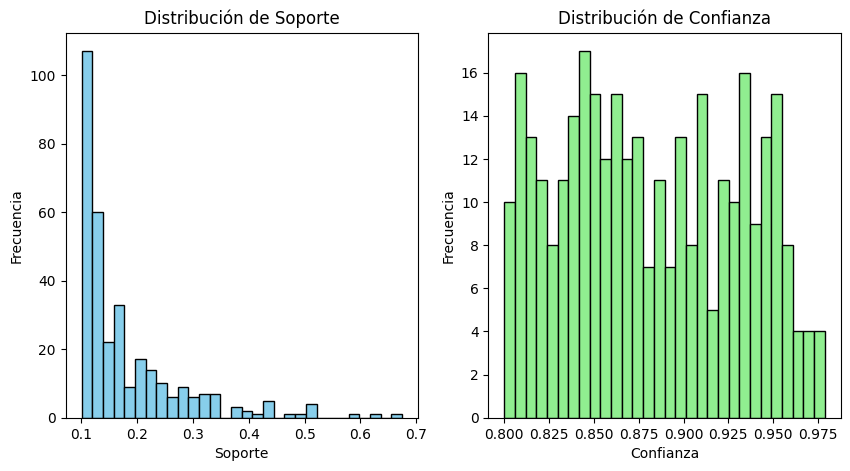

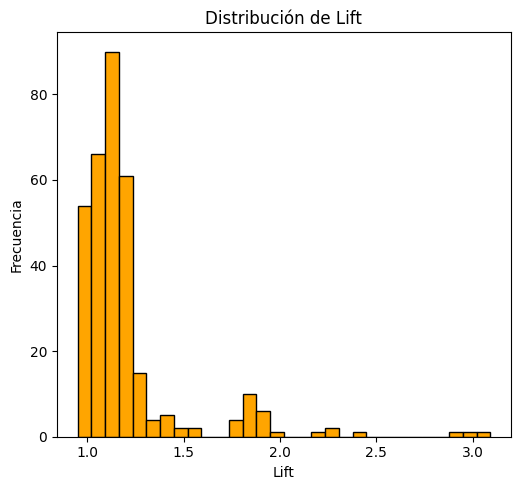

In [429]:
# Crear un histograma de soporte
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(rules_ap['support'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Soporte')
plt.xlabel('Soporte')
plt.ylabel('Frecuencia')

# Crear un histograma de confianza
plt.subplot(1, 2, 2)
plt.hist(rules_ap['confidence'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribución de Confianza')
plt.xlabel('Confianza')
plt.ylabel('Frecuencia')

# Crear un histograma de lift
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.hist(rules_ap['lift'], bins=30, color='orange', edgecolor='black')
plt.title('Distribución de Lift')
plt.xlabel('Lift')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


### Reglas para estudiar qué influye en que se introduzcan mal los tiempos de las rutas o no sigan las indicaciones iniciales

In [430]:
seleccion = ['IdRuta','DistanciaReal_km', 'Id_Conductor', 'Origen']
patronTiempo = df.drop_duplicates(subset='IdRuta').dropna(subset=["DistanciaReal_km", "Origen"])[seleccion]
patronTiempo["LongRuta"] = patronTiempo.apply(lambda row: e_distanciaRuta(row), axis=1)

In [431]:
filtro = rc_av[rc_av["IdRuta"].isin(set(patronTiempo["IdRuta"]))]
def e_cumple_plan(row):
    formato = "%Y-%m-%d %H:%M:%S.%f"
    ruta = row["IdRuta"]
    filaRCAV = rc_av[rc_av["IdRuta"] == ruta].iloc[0]
    fechaIniReal = datetime.strptime(filaRCAV["Fecha_Inicio_Real"], formato) if not pd.isna(filaRCAV["Fecha_Inicio_Real"]) else None
    fechaFinReal = datetime.strptime(filaRCAV["Fecha_Final_Real"], formato) if not pd.isna(filaRCAV["Fecha_Final_Real"]) else None
    fechaIniEstimadaPersona = datetime.strptime(filaRCAV["fecha_desde"], formato) 
    fechaFinEstimadaPersona = datetime.strptime(filaRCAV["fecha_hasta"], formato)
    
    if fechaIniReal is None or fechaFinReal is None or fechaIniReal == fechaFinReal or (fechaIniReal - fechaIniEstimadaPersona).days >= 1 or (fechaIniReal == fechaIniEstimadaPersona and fechaFinReal == fechaFinEstimadaPersona):
        return "NoCumple"
    else:
        return "Cumple"
patronTiempo["CumplePlan"] = patronTiempo.apply(lambda row: e_cumple_plan(row), axis=1)

In [432]:
patronTiempo = patronTiempo.drop(columns=['IdRuta', 'DistanciaReal_km'])

In [433]:
patronTiempo["Id_Conductor"] = patronTiempo["Id_Conductor"].astype(str)
patronTiempo

Id_Conductor                    Origen        LongRuta CumplePlan
0             3903                  ZARAGOZA  DistanciaMedia   NoCumple
5             4127                    CESTAS  DistanciaMedia   NoCumple
11             576                    HARNES  DistanciaMedia     Cumple
18            3829                     RONCQ  DistanciaMedia     Cumple
30             323                    ENNERY  DistanciaCorta     Cumple
...            ...                       ...             ...        ...
52433         2885  SANTA PERPETUA DE MOGODA  DistanciaMedia   NoCumple
52437         4251                   URRUGNE  DistanciaMedia   NoCumple
52443         4128         TRITH-SAINT-LÉGER  DistanciaMedia   NoCumple
52455         4465        BONNEUIL-EN-FRANCE  DistanciaMedia   NoCumple
52461         3482                   URRUGNE  DistanciaMedia   NoCumple

[8687 rows x 4 columns]

In [434]:
te = TransactionEncoder()
te_array = te.fit(patronTiempo.values).transform(patronTiempo.values)
reglas = pd.DataFrame(te_array, columns=te.columns_)
frequent_itemsets_ap = apriori(reglas, min_support=0.001, use_colnames=True)
rules_ap = association_rules(frequent_itemsets_ap, metric="confidence", min_threshold=0.8)
rules_ap['Regla'] = rules_ap.apply(lambda row: f"{list(row['antecedents'])} => {list(row['consequents'])}", axis=1)
rules_ap.insert(0, rules_ap.columns[-1], rules_ap.pop(rules_ap.columns[-1]))
rules_ap.to_csv('ReglasActuacionConductor.csv', index=False, sep=';', decimal='.', float_format='%.4f')
rules_ap

Regla  \
0                              ['ALGECIRAS'] => ['-1']   
1                      ['BAHRAOUIYNE TANJA'] => ['-1']   
2                             ['CASABLANCA'] => ['-1']   
3                                ['GZENAYA'] => ['-1']   
4                                 ['TANGER'] => ['-1']   
..                                                 ...   
748  ['DistanciaMedia', 'VARENNES-VAUZELLES', '539'...   
749  ['Cumple', 'VARENNES-VAUZELLES', '539'] => ['D...   
750  ['VARENNES-VAUZELLES', '539'] => ['DistanciaMe...   
751  ['IMARCOAIN', 'Cumple', '657'] => ['DistanciaC...   
752  ['IMARCOAIN', 'NoCumple', '657'] => ['Distanci...   

                                   antecedents               consequents  \
0                                  (ALGECIRAS)                      (-1)   
1                          (BAHRAOUIYNE TANJA)                      (-1)   
2                                 (CASABLANCA)                      (-1)   
3                                    (GZENAYA)                      (-1)   
4                                     (TANGER)                      (-1)   
..                                         ...                       ...   
748  (DistanciaMedia, VARENNES-VAUZELLES, 539)                  (Cumple)   
749          (Cumple, VARENNES-VAUZELLES, 539)          (DistanciaMedia)   
750                  (VARENNES-VAUZELLES, 539)  (DistanciaMedia, Cumple)   
751                   (IMARCOAIN, Cumple, 657)          (DistanciaCorta)   
752                 (IMARCOAIN, NoCumple, 657)          (DistanciaCorta)   

     antecedent support  consequent support   support  confidence       lift  \
0              0.010821            0.039715  0.009555    0.882979  22.233148   
1              0.009900            0.039715  0.009900    1.000000  25.179710   
2              0.001496            0.039715  0.001496    1.000000  25.179710   
3              0.001842            0.039715  0.001842    1.000000  25.179710   
4              0.001036            0.039715  0.001036    1.000000  25.179710   
..                  ...                 ...       ...         ...        ...   
748            0.001036            0.686543  0.001036    1.000000   1.456573   
749            0.001266            0.551859  0.001036    0.818182   1.482592   
750            0.001266            0.404397  0.001036    0.818182   2.023212   
751            0.001496            0.290549  0.001496    1.000000   3.441759   
752            0.001266            0.290549  0.001266    1.000000   3.441759   

     leverage  conviction  zhangs_metric  
0    0.009125    8.206076       0.965469  
1    0.009507         inf       0.969887  
2    0.001437         inf       0.961725  
3    0.001769         inf       0.962057  
4    0.000995         inf       0.961281  
..        ...         ...            ...  
748  0.000325         inf       0.313782  
749  0.000337    2.464775       0.325918  
750  0.000524    3.275814       0.506378  
751  0.001062         inf       0.710514  
752  0.000898         inf       0.710350  

[753 rows x 11 columns]

### Categorización de conductores

In [435]:
conductores = pd.read_csv("Conductores.csv", delimiter=';', encoding='cp1252')
conductores = conductores[conductores["Id_Conductor"].isin(set(df["Id_Conductor"]).union(set(df["Id_Conductor2"])))]
conductores = conductores[["Id_Conductor","Nombre","Apellido1","Apellido2","Fecha_Alta"]]
conductores

Id_Conductor           Nombre        Apellido1 Apellido2  \
90              91  DO COBO NOGUERA      LUIS MANUEL  54400067   
219            220         MUNTEANU          TUDOREL  54400073   
322            323    00000000041L1              NaN       NaN   
416            417         Magurean              NaN  54400111   
457            458         Valerica          Dobinda  54400485   
...            ...              ...              ...       ...   
4592          4593     Marius Danut        Corboianu       NaN   
4593          4594           COSTEL             NOUR       NaN   
4594          4595         Valentin            Marin       NaN   
4595          4596       ISACC ISSA  MAMANI CARBAJAL       NaN   
4596          4597           Daniel          Chiriac       NaN   

                   Fecha_Alta  
90    2012-07-30 22:49:58.470  
219   2012-09-03 18:08:54.200  
322   2013-01-16 12:34:47.167  
416   2013-06-21 19:08:14.503  
457   2013-08-18 15:02:02.250  
...                       ...  
4592  2024-03-28 14:07:58.597  
4593  2024-03-29 08:38:51.160  
4594  2024-03-29 09:00:17.693  
4595  2024-04-01 21:34:13.013  
4596  2024-04-03 22:01:24.690  

[583 rows x 5 columns]

#### Definición etiquetas

In [436]:
formato = "%Y-%m-%d %H:%M:%S.%f"
def conductorAntiguo(row):
    diff = datetime.now() - datetime.strptime(row["Fecha_Alta"], formato)
    return diff.days
filtro = df.drop_duplicates(subset="IdRuta")
filtroRCAV = pd.merge(rc_av,filtro, on="IdRuta")
filtroRCAV['Fecha_Inicio_Real'] = pd.to_datetime(filtroRCAV['Fecha_Inicio_Real'], errors='coerce')
filtroRCAV['fecha_desde'] = pd.to_datetime(filtroRCAV['fecha_desde'], errors='coerce')

def numRutasConductores(row):
    incluyeConductor = (filtro["Id_Conductor"] == row["Id_Conductor"]) | (filtro["Id_Conductor2"] == row["Id_Conductor"])
    return len(filtro.loc[incluyeConductor])
def distanciaMediaConductores(row):
    incluyeConductor = (filtro["Id_Conductor"] == row["Id_Conductor"]) | (filtro["Id_Conductor2"] == row["Id_Conductor"])
    return filtro.loc[incluyeConductor]["DistanciaReal_km"].mean()
def frecuenciaConductor(row):
    incluyeConductor = (filtroRCAV["Id_Conductor"] == row["Id_Conductor"]) | (filtroRCAV["Id_Conductor2"] == row["Id_Conductor"])
    seleccion = filtroRCAV.loc[incluyeConductor]
    if len(seleccion) == 1:
        return None
    else:
        seleccion["diferencia"] = seleccion["Fecha_Inicio_Real"].combine_first(seleccion["fecha_desde"]).diff()
        return seleccion["diferencia"].iloc[1:].mean().days
            
        
conductores["Antigüedad"] = conductores.apply(lambda row: conductorAntiguo(row), axis=1)
conductores["NumRutas"] = conductores.apply(lambda row: numRutasConductores(row), axis=1)
conductores["DistanciaRutas"] = conductores.apply(lambda row: distanciaMediaConductores(row), axis=1)
conductores["FrecuenciaTiempo"] = conductores.apply(lambda row: frecuenciaConductor(row), axis=1)
conductores

Id_Conductor           Nombre        Apellido1 Apellido2  \
90              91  DO COBO NOGUERA      LUIS MANUEL  54400067   
219            220         MUNTEANU          TUDOREL  54400073   
322            323    00000000041L1              NaN       NaN   
416            417         Magurean              NaN  54400111   
457            458         Valerica          Dobinda  54400485   
...            ...              ...              ...       ...   
4592          4593     Marius Danut        Corboianu       NaN   
4593          4594           COSTEL             NOUR       NaN   
4594          4595         Valentin            Marin       NaN   
4595          4596       ISACC ISSA  MAMANI CARBAJAL       NaN   
4596          4597           Daniel          Chiriac       NaN   

                   Fecha_Alta  Antigüedad  NumRutas  DistanciaRutas  \
90    2012-07-30 22:49:58.470        4420        14     2439.684286   
219   2012-09-03 18:08:54.200        4385        50      412.059820   
322   2013-01-16 12:34:47.167        4250        21      869.509190   
416   2013-06-21 19:08:14.503        4094         4     2969.725250   
457   2013-08-18 15:02:02.250        4036        40      964.798150   
...                       ...         ...       ...             ...   
4592  2024-03-28 14:07:58.597         161         3     1311.767333   
4593  2024-03-29 08:38:51.160         161         1     2185.498000   
4594  2024-03-29 09:00:17.693         161         2      658.803500   
4595  2024-04-01 21:34:13.013         157         1      802.515000   
4596  2024-04-03 22:01:24.690         155         1      818.891000   

      FrecuenciaTiempo  
90                 4.0  
219                2.0  
322               15.0  
416               18.0  
457                1.0  
...                ...  
4592               1.0  
4593               NaN  
4594               2.0  
4595               NaN  
4596               NaN  

[583 rows x 9 columns]

In [437]:
def e_distanciaRutasConductor(row):
    if row["DistanciaRutas"] <= 630:
        return "DistanciaCorta"
    elif row["DistanciaRutas"] <= 1375:
        return "DistanciaMedia"
    else:
        return "DistanciaLarga"
conductores["DistanciaRutasE"] = conductores.apply(lambda row: e_distanciaRutasConductor(row), axis=1)

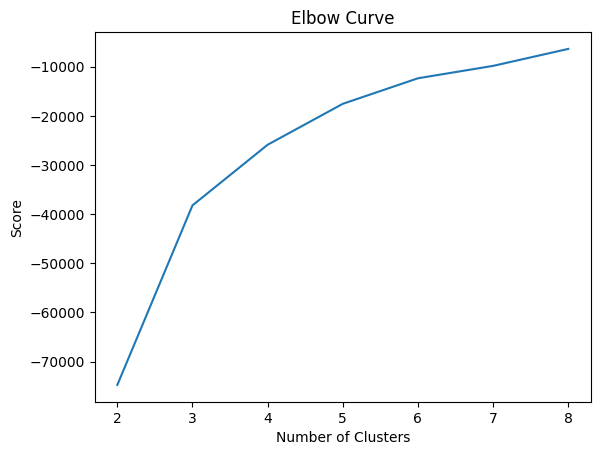

In [438]:
Nc = range(2, 9)
X = list(dictNumLocalidadesConductor.values())
X = np.reshape(X,(-1, 1))
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [439]:
# Elijo usar 3 clusters
kmeans = KMeans(n_clusters=4, n_init="auto").fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[27.62328767]
 [ 6.90625   ]
 [65.43298969]
 [46.98351648]]


Text(0, 0.5, 'Localidades que visita conductor')

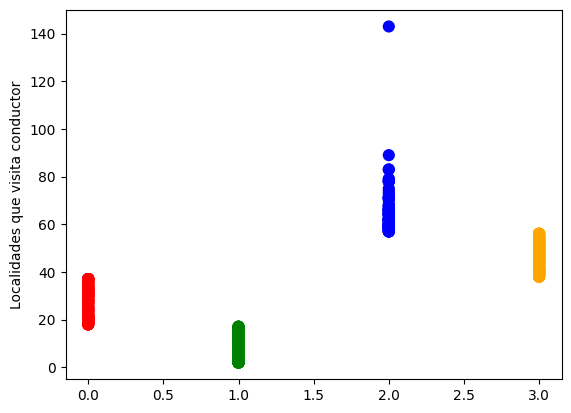

In [440]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','orange']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig,ax =  plt.subplots()
ax.scatter(labels, X[:, 0], c=asignar,s=60)
ax.set_ylabel('Localidades que visita conductor')

In [441]:
def e_localidadesConductor(row):
    numLocalidades = dictNumLocalidadesConductor[row["Id_Conductor"]]
    if numLocalidades < 20:
        return "MenosDe20Localiades"
    elif numLocalidades <= 40:
        return "MenosDe40Localiades"
    elif numLocalidades <= 60:
        return "MenosDe60Localiades"
    else:
        return "MuchasLocalidades"

In [442]:
conductores["NumLocalidades"] = conductores.apply(lambda row: e_localidadesConductor(row), axis=1)
conductores

Id_Conductor           Nombre        Apellido1 Apellido2  \
90              91  DO COBO NOGUERA      LUIS MANUEL  54400067   
219            220         MUNTEANU          TUDOREL  54400073   
322            323    00000000041L1              NaN       NaN   
416            417         Magurean              NaN  54400111   
457            458         Valerica          Dobinda  54400485   
...            ...              ...              ...       ...   
4592          4593     Marius Danut        Corboianu       NaN   
4593          4594           COSTEL             NOUR       NaN   
4594          4595         Valentin            Marin       NaN   
4595          4596       ISACC ISSA  MAMANI CARBAJAL       NaN   
4596          4597           Daniel          Chiriac       NaN   

                   Fecha_Alta  Antigüedad  NumRutas  DistanciaRutas  \
90    2012-07-30 22:49:58.470        4420        14     2439.684286   
219   2012-09-03 18:08:54.200        4385        50      412.059820   
322   2013-01-16 12:34:47.167        4250        21      869.509190   
416   2013-06-21 19:08:14.503        4094         4     2969.725250   
457   2013-08-18 15:02:02.250        4036        40      964.798150   
...                       ...         ...       ...             ...   
4592  2024-03-28 14:07:58.597         161         3     1311.767333   
4593  2024-03-29 08:38:51.160         161         1     2185.498000   
4594  2024-03-29 09:00:17.693         161         2      658.803500   
4595  2024-04-01 21:34:13.013         157         1      802.515000   
4596  2024-04-03 22:01:24.690         155         1      818.891000   

      FrecuenciaTiempo DistanciaRutasE       NumLocalidades  
90                 4.0  DistanciaLarga  MenosDe20Localiades  
219                2.0  DistanciaCorta  MenosDe40Localiades  
322               15.0  DistanciaMedia  MenosDe40Localiades  
416               18.0  DistanciaLarga  MenosDe20Localiades  
457                1.0  DistanciaMedia  MenosDe60Localiades  
...                ...             ...                  ...  
4592               1.0  DistanciaMedia  MenosDe20Localiades  
4593               NaN  DistanciaLarga  MenosDe20Localiades  
4594               2.0  DistanciaMedia  MenosDe20Localiades  
4595               NaN  DistanciaMedia  MenosDe20Localiades  
4596               NaN  DistanciaMedia  MenosDe20Localiades  

[583 rows x 11 columns]

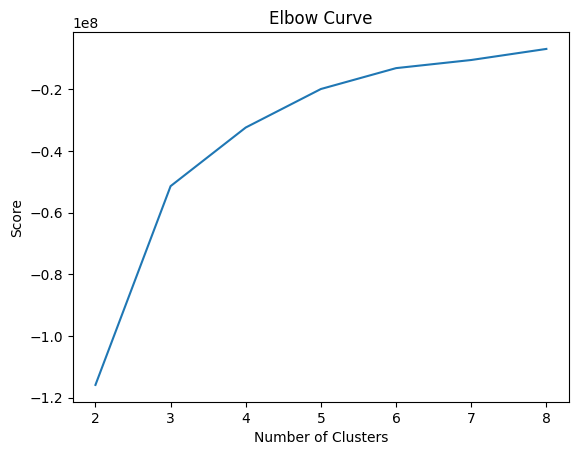

In [443]:
Nc = range(2, 9)
X = conductores["Antigüedad"]
X = np.reshape(X,(-1, 1))
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [444]:
# Elijo usar 3 clusters
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 436.0078329 ]
 [2889.88888889]
 [1426.39041096]]


Text(0, 0.5, 'Antigüedad de conductor en días')

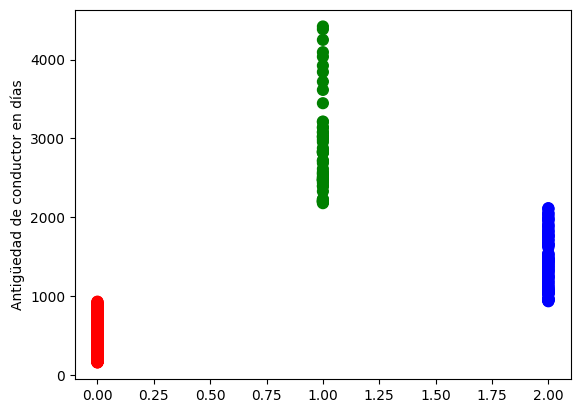

In [445]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig,ax =  plt.subplots()
ax.scatter(labels, X[:, 0], c=asignar,s=60)
ax.set_ylabel('Antigüedad de conductor en días')

In [446]:
def e_antiguedadConductor(row):
    antiguedad = row["Antigüedad"]
    if antiguedad < 1095:
        return "MenosDe3Anhos"
    elif antiguedad <= 1825:
        return "Entre3y5Anhos"
    else:
        return "MasDe5Anhos"

In [447]:
conductores["AntigüedadE"] = conductores.apply(lambda row: e_antiguedadConductor(row), axis=1)
conductores

Id_Conductor           Nombre        Apellido1 Apellido2  \
90              91  DO COBO NOGUERA      LUIS MANUEL  54400067   
219            220         MUNTEANU          TUDOREL  54400073   
322            323    00000000041L1              NaN       NaN   
416            417         Magurean              NaN  54400111   
457            458         Valerica          Dobinda  54400485   
...            ...              ...              ...       ...   
4592          4593     Marius Danut        Corboianu       NaN   
4593          4594           COSTEL             NOUR       NaN   
4594          4595         Valentin            Marin       NaN   
4595          4596       ISACC ISSA  MAMANI CARBAJAL       NaN   
4596          4597           Daniel          Chiriac       NaN   

                   Fecha_Alta  Antigüedad  NumRutas  DistanciaRutas  \
90    2012-07-30 22:49:58.470        4420        14     2439.684286   
219   2012-09-03 18:08:54.200        4385        50      412.059820   
322   2013-01-16 12:34:47.167        4250        21      869.509190   
416   2013-06-21 19:08:14.503        4094         4     2969.725250   
457   2013-08-18 15:02:02.250        4036        40      964.798150   
...                       ...         ...       ...             ...   
4592  2024-03-28 14:07:58.597         161         3     1311.767333   
4593  2024-03-29 08:38:51.160         161         1     2185.498000   
4594  2024-03-29 09:00:17.693         161         2      658.803500   
4595  2024-04-01 21:34:13.013         157         1      802.515000   
4596  2024-04-03 22:01:24.690         155         1      818.891000   

      FrecuenciaTiempo DistanciaRutasE       NumLocalidades    AntigüedadE  
90                 4.0  DistanciaLarga  MenosDe20Localiades    MasDe5Anhos  
219                2.0  DistanciaCorta  MenosDe40Localiades    MasDe5Anhos  
322               15.0  DistanciaMedia  MenosDe40Localiades    MasDe5Anhos  
416               18.0  DistanciaLarga  MenosDe20Localiades    MasDe5Anhos  
457                1.0  DistanciaMedia  MenosDe60Localiades    MasDe5Anhos  
...                ...             ...                  ...            ...  
4592               1.0  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos  
4593               NaN  DistanciaLarga  MenosDe20Localiades  MenosDe3Anhos  
4594               2.0  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos  
4595               NaN  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos  
4596               NaN  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos  

[583 rows x 12 columns]

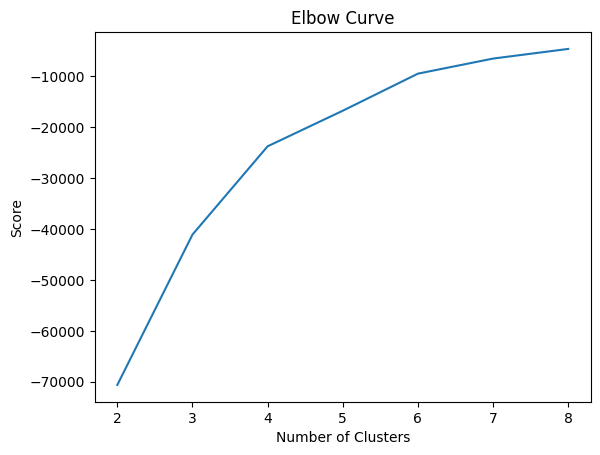

In [448]:
Nc = range(2, 9)
X = conductores["NumRutas"]
X = np.reshape(X,(-1, 1))
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [449]:
# Elijo usar 3 clusters
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[49.97385621]
 [ 6.31472081]
 [27.51072961]]


Text(0, 0.5, 'Número de rutas que ha hecho el conductor')

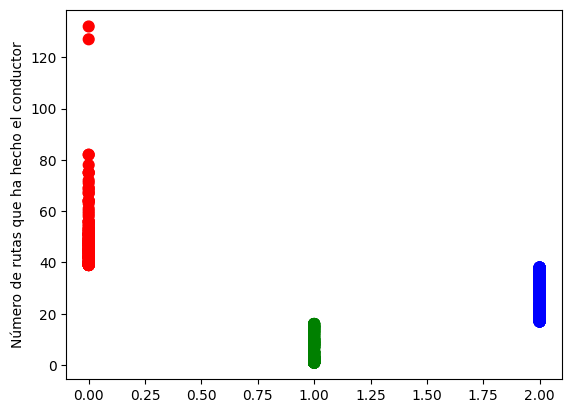

In [450]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig,ax =  plt.subplots()
ax.scatter(labels, X[:, 0], c=asignar,s=60)
ax.set_ylabel('Número de rutas que ha hecho el conductor')

In [451]:
def e_numRutasConductor(row):
    numRutas = row["NumRutas"]
    if numRutas <= 18:
        return "PocasRutas"
    elif numRutas <= 40:
        return "BastantesRutas"
    else:
        return "MuchasRutas"

In [452]:
conductores["NumRutasE"] = conductores.apply(lambda row: e_numRutasConductor(row), axis=1)
conductores

Id_Conductor           Nombre        Apellido1 Apellido2  \
90              91  DO COBO NOGUERA      LUIS MANUEL  54400067   
219            220         MUNTEANU          TUDOREL  54400073   
322            323    00000000041L1              NaN       NaN   
416            417         Magurean              NaN  54400111   
457            458         Valerica          Dobinda  54400485   
...            ...              ...              ...       ...   
4592          4593     Marius Danut        Corboianu       NaN   
4593          4594           COSTEL             NOUR       NaN   
4594          4595         Valentin            Marin       NaN   
4595          4596       ISACC ISSA  MAMANI CARBAJAL       NaN   
4596          4597           Daniel          Chiriac       NaN   

                   Fecha_Alta  Antigüedad  NumRutas  DistanciaRutas  \
90    2012-07-30 22:49:58.470        4420        14     2439.684286   
219   2012-09-03 18:08:54.200        4385        50      412.059820   
322   2013-01-16 12:34:47.167        4250        21      869.509190   
416   2013-06-21 19:08:14.503        4094         4     2969.725250   
457   2013-08-18 15:02:02.250        4036        40      964.798150   
...                       ...         ...       ...             ...   
4592  2024-03-28 14:07:58.597         161         3     1311.767333   
4593  2024-03-29 08:38:51.160         161         1     2185.498000   
4594  2024-03-29 09:00:17.693         161         2      658.803500   
4595  2024-04-01 21:34:13.013         157         1      802.515000   
4596  2024-04-03 22:01:24.690         155         1      818.891000   

      FrecuenciaTiempo DistanciaRutasE       NumLocalidades    AntigüedadE  \
90                 4.0  DistanciaLarga  MenosDe20Localiades    MasDe5Anhos   
219                2.0  DistanciaCorta  MenosDe40Localiades    MasDe5Anhos   
322               15.0  DistanciaMedia  MenosDe40Localiades    MasDe5Anhos   
416               18.0  DistanciaLarga  MenosDe20Localiades    MasDe5Anhos   
457                1.0  DistanciaMedia  MenosDe60Localiades    MasDe5Anhos   
...                ...             ...                  ...            ...   
4592               1.0  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos   
4593               NaN  DistanciaLarga  MenosDe20Localiades  MenosDe3Anhos   
4594               2.0  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos   
4595               NaN  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos   
4596               NaN  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos   

           NumRutasE  
90        PocasRutas  
219      MuchasRutas  
322   BastantesRutas  
416       PocasRutas  
457   BastantesRutas  
...              ...  
4592      PocasRutas  
4593      PocasRutas  
4594      PocasRutas  
4595      PocasRutas  
4596      PocasRutas  

[583 rows x 13 columns]

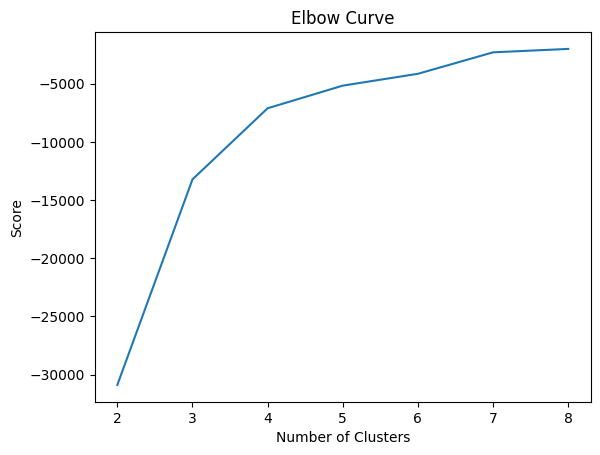

In [453]:
Nc = range(2, 9)
X = conductores["FrecuenciaTiempo"]
X = X.dropna().values.reshape(-1, 1)
kmeans = [KMeans(n_clusters=i, n_init="auto") for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [454]:
# Elijo usar 3 clusters
kmeans = KMeans(n_clusters=3, n_init="auto").fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[  4.45129225]
 [114.8       ]
 [ 35.63333333]]


Text(0, 0.5, 'Frecuencia (días) en que un conductor hace ruta')

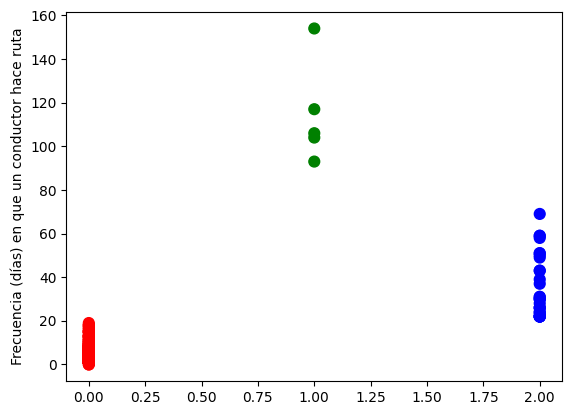

In [455]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue']
asignar=[]
for row in labels:
    asignar.append(colores[row])
 
fig,ax =  plt.subplots()
ax.scatter(labels, X[:, 0], c=asignar,s=60)
ax.set_ylabel('Frecuencia (días) en que un conductor hace ruta')

In [456]:
def e_frecuenciaConductor(row):
    frecuencia = row["FrecuenciaTiempo"]
    if frecuencia <= 10:
        return "FrecuenciaSemanal"
    if frecuencia <= 20:
        return "FrecuenteMensual"
    elif frecuencia <= 70:
        return "PocoFrecuente"
    elif pd.isna(frecuencia):
        return "SoloHizoUnaRuta"
    else:
        return "RaramenteHaceRuta"

In [457]:
conductores["FrecuenciaTiempoE"] = conductores.apply(lambda row: e_frecuenciaConductor(row), axis=1)
conductores

Id_Conductor           Nombre        Apellido1 Apellido2  \
90              91  DO COBO NOGUERA      LUIS MANUEL  54400067   
219            220         MUNTEANU          TUDOREL  54400073   
322            323    00000000041L1              NaN       NaN   
416            417         Magurean              NaN  54400111   
457            458         Valerica          Dobinda  54400485   
...            ...              ...              ...       ...   
4592          4593     Marius Danut        Corboianu       NaN   
4593          4594           COSTEL             NOUR       NaN   
4594          4595         Valentin            Marin       NaN   
4595          4596       ISACC ISSA  MAMANI CARBAJAL       NaN   
4596          4597           Daniel          Chiriac       NaN   

                   Fecha_Alta  Antigüedad  NumRutas  DistanciaRutas  \
90    2012-07-30 22:49:58.470        4420        14     2439.684286   
219   2012-09-03 18:08:54.200        4385        50      412.059820   
322   2013-01-16 12:34:47.167        4250        21      869.509190   
416   2013-06-21 19:08:14.503        4094         4     2969.725250   
457   2013-08-18 15:02:02.250        4036        40      964.798150   
...                       ...         ...       ...             ...   
4592  2024-03-28 14:07:58.597         161         3     1311.767333   
4593  2024-03-29 08:38:51.160         161         1     2185.498000   
4594  2024-03-29 09:00:17.693         161         2      658.803500   
4595  2024-04-01 21:34:13.013         157         1      802.515000   
4596  2024-04-03 22:01:24.690         155         1      818.891000   

      FrecuenciaTiempo DistanciaRutasE       NumLocalidades    AntigüedadE  \
90                 4.0  DistanciaLarga  MenosDe20Localiades    MasDe5Anhos   
219                2.0  DistanciaCorta  MenosDe40Localiades    MasDe5Anhos   
322               15.0  DistanciaMedia  MenosDe40Localiades    MasDe5Anhos   
416               18.0  DistanciaLarga  MenosDe20Localiades    MasDe5Anhos   
457                1.0  DistanciaMedia  MenosDe60Localiades    MasDe5Anhos   
...                ...             ...                  ...            ...   
4592               1.0  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos   
4593               NaN  DistanciaLarga  MenosDe20Localiades  MenosDe3Anhos   
4594               2.0  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos   
4595               NaN  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos   
4596               NaN  DistanciaMedia  MenosDe20Localiades  MenosDe3Anhos   

           NumRutasE  FrecuenciaTiempoE  
90        PocasRutas  FrecuenciaSemanal  
219      MuchasRutas  FrecuenciaSemanal  
322   BastantesRutas   FrecuenteMensual  
416       PocasRutas   FrecuenteMensual  
457   BastantesRutas  FrecuenciaSemanal  
...              ...                ...  
4592      PocasRutas  FrecuenciaSemanal  
4593      PocasRutas    SoloHizoUnaRuta  
4594      PocasRutas  FrecuenciaSemanal  
4595      PocasRutas    SoloHizoUnaRuta  
4596      PocasRutas    SoloHizoUnaRuta  

[583 rows x 14 columns]

In [458]:
fig = px.bar(conductores, x='Id_Conductor', y='FrecuenciaTiempo', title='Media de días que tardan  conductores en volver a hacer una ruta')

fig.show()

Text(0.5, 1.0, 'Gráfico de frecuencia de días de comienzos de rutas')

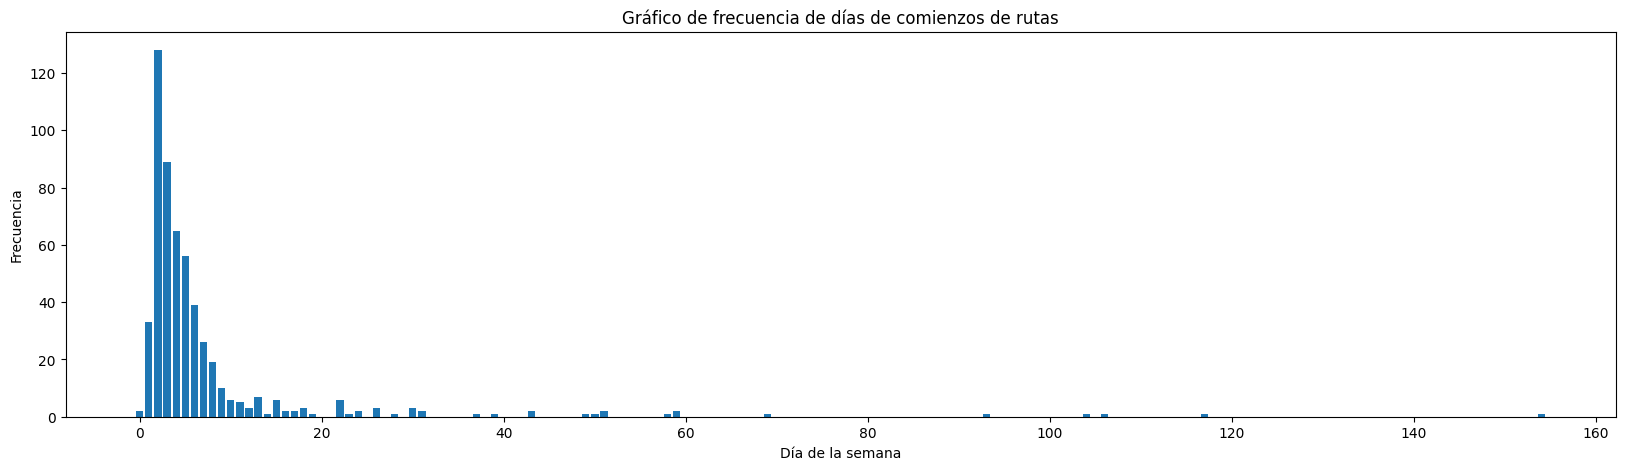

In [459]:
frecuencia = conductores["FrecuenciaTiempo"]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20,5))
frecuencias = frecuencia.value_counts()
ax.bar(frecuencias.index, frecuencias.values)
ax.set_xlabel('Día de la semana')
ax.set_ylabel('Frecuencia')
ax.set_title('Gráfico de frecuencia de días de comienzos de rutas')

In [460]:
fig = px.bar(conductores, x='Id_Conductor', y='Antigüedad', title='Antigüedad de los conductores en días')
fig.update_traces(marker_color='black')
fig.show()

#### Obtener reglas

In [461]:
conductoresReglas = conductores.drop(columns=["Id_Conductor", "Nombre", "Apellido1", "Apellido2", "Fecha_Alta",	"Antigüedad",	"NumRutas",	"DistanciaRutas",	"FrecuenciaTiempo"])

In [462]:
te = TransactionEncoder()
te_array = te.fit(conductoresReglas.values).transform(conductoresReglas.values)
reglas = pd.DataFrame(te_array, columns=te.columns_)
reglas

BastantesRutas  DistanciaCorta  DistanciaLarga  DistanciaMedia  \
0             False           False            True           False   
1             False            True           False           False   
2              True           False           False            True   
3             False           False            True           False   
4              True           False           False            True   
..              ...             ...             ...             ...   
578           False           False           False            True   
579           False           False            True           False   
580           False           False           False            True   
581           False           False           False            True   
582           False           False           False            True   

     Entre3y5Anhos  FrecuenciaSemanal  FrecuenteMensual  MasDe5Anhos  \
0            False               True             False         True   
1            False               True             False         True   
2            False              False              True         True   
3            False              False              True         True   
4            False               True             False         True   
..             ...                ...               ...          ...   
578          False               True             False        False   
579          False              False             False        False   
580          False               True             False        False   
581          False              False             False        False   
582          False              False             False        False   

     MenosDe20Localiades  MenosDe3Anhos  MenosDe40Localiades  \
0                   True          False                False   
1                  False          False                 True   
2                  False          False                 True   
3                   True          False                False   
4                  False          False                False   
..                   ...            ...                  ...   
578                 True           True                False   
579                 True           True                False   
580                 True           True                False   
581                 True           True                False   
582                 True           True                False   

     MenosDe60Localiades  MuchasLocalidades  MuchasRutas  PocasRutas  \
0                  False              False        False        True   
1                  False              False         True       False   
2                  False              False        False       False   
3                  False              False        False        True   
4                   True              False        False       False   
..                   ...                ...          ...         ...   
578                False              False        False        True   
579                False              False        False        True   
580                False              False        False        True   
581                False              False        False        True   
582                False              False        False        True   

     PocoFrecuente  RaramenteHaceRuta  SoloHizoUnaRuta  
0            False              False            False  
1            False              False            False  
2            False              False            False  
3            False              False            False  
4            False              False            False  
..             ...                ...              ...  
578          False              False            False  
579          False              False             True  
580          False              False            False  
581          False              False             True  
582          False        

In [463]:

frequent_itemsets_ap = apriori(reglas, min_support=0.1, use_colnames=True)
frequent_itemsets_ap.to_csv('ItemsetsFrecuentes.csv', index=False, sep=';') 
frequent_itemsets_ap

support                                           itemsets
0   0.409949                                   (BastantesRutas)
1   0.864494                                   (DistanciaMedia)
2   0.159520                                    (Entre3y5Anhos)
3   0.811321                                (FrecuenciaSemanal)
4   0.128645                                      (MasDe5Anhos)
..       ...                                                ...
76  0.217839  (DistanciaMedia, MenosDe3Anhos, MenosDe60Local...
77  0.102916  (DistanciaMedia, MuchasRutas, MenosDe3Anhos, F...
78  0.152659  (DistanciaMedia, MenosDe3Anhos, FrecuenciaSema...
79  0.162950  (DistanciaMedia, MenosDe20Localiades, MenosDe3...
80  0.168096  (MenosDe3Anhos, MenosDe60Localiades, Distancia...

[81 rows x 2 columns]

In [464]:

rules_ap = association_rules(frequent_itemsets_ap, metric="confidence", min_threshold=0.7)
rules_ap['Regla'] = rules_ap.apply(lambda row: f"{list(row['antecedents'])} => {list(row['consequents'])}", axis=1)
rules_ap.insert(0, rules_ap.columns[-1], rules_ap.pop(rules_ap.columns[-1]))
rules_ap.to_csv('ReglasConductores.csv', index=False, sep=';', decimal='.', float_format='%.4f')
rules_ap

Regla  \
0             ['BastantesRutas'] => ['DistanciaMedia']   
1          ['BastantesRutas'] => ['FrecuenciaSemanal']   
2              ['BastantesRutas'] => ['MenosDe3Anhos']   
3        ['MenosDe60Localiades'] => ['BastantesRutas']   
4              ['Entre3y5Anhos'] => ['DistanciaMedia']   
..                                                 ...   
134  ['MenosDe3Anhos', 'MenosDe60Localiades', 'Bast...   
135  ['MenosDe3Anhos', 'MenosDe60Localiades', 'Frec...   
136  ['DistanciaMedia', 'BastantesRutas', 'MenosDe6...   
137  ['BastantesRutas', 'MenosDe60Localiades', 'Fre...   
138  ['MenosDe3Anhos', 'MenosDe60Localiades'] => ['...   

                                           antecedents  \
0                                     (BastantesRutas)   
1                                     (BastantesRutas)   
2                                     (BastantesRutas)   
3                                (MenosDe60Localiades)   
4                                      (Entre3y5Anhos)   
..                                                 ...   
134  (MenosDe3Anhos, MenosDe60Localiades, Bastantes...   
135  (MenosDe3Anhos, MenosDe60Localiades, Frecuenci...   
136  (DistanciaMedia, BastantesRutas, MenosDe60Loca...   
137  (BastantesRutas, MenosDe60Localiades, Frecuenc...   
138               (MenosDe3Anhos, MenosDe60Localiades)   

                                           consequents  antecedent support  \
0                                     (DistanciaMedia)            0.409949   
1                                  (FrecuenciaSemanal)            0.409949   
2                                      (MenosDe3Anhos)            0.409949   
3                                     (BastantesRutas)            0.324185   
4                                     (DistanciaMedia)            0.159520   
..                                                 ...                 ...   
134                (DistanciaMedia, FrecuenciaSemanal)            0.174957   
135                   (DistanciaMedia, BastantesRutas)            0.226415   
136                 (MenosDe3Anhos, FrecuenciaSemanal)            0.222985   
137                    (DistanciaMedia, MenosDe3Anhos)            0.236707   
138  (DistanciaMedia, BastantesRutas, FrecuenciaSem...            0.228130   

     consequent support   support  confidence      lift  leverage  conviction  \
0              0.864494  0.375643    0.916318  1.059947  0.021245    1.619297   
1              0.811321  0.392796    0.958159  1.180987  0.060196    4.509434   
2              0.711835  0.298456    0.728033  1.022755  0.006640    1.059559   
3              0.409949  0.243568    0.751323  1.832725  0.110668    2.372760   
4              0.864494  0.126930    0.795699  0.920422 -0.010974    0.663266   
..                  ...       ...         ...       ...       ...         ...   
134            0.718696  0.168096    0.960784  1.336843  0.042355    7.173242   
135            0.375643  0.168096    0.742424  1.976408  0.083045    2.423973   
136            0.571184  0.168096    0.753846  1.319797  0.040731    1.742067   
137            0.650086  0.168096    0.710145  1.092387  0.014216    1.207204   
138            0.360206  0.168096    0.736842  2.045614  0.085922    2.431218   

     zhangs_metric  
0         0.095851  
1         0.259724  
2         0.037707  
3         0.672321  
4        -0.093273  
..             ...  
134       0.305401  
135       0.638626  
136       0.311844  
137       0.110800  
138       0.662222  

[139 rows x 11 columns]

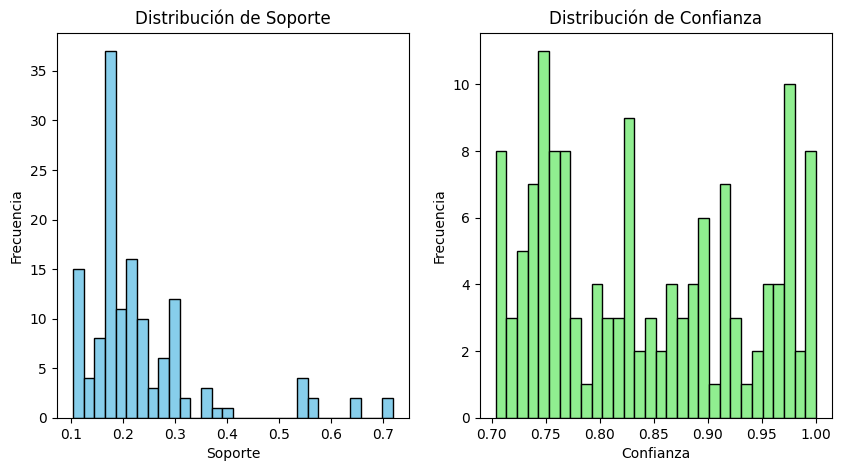

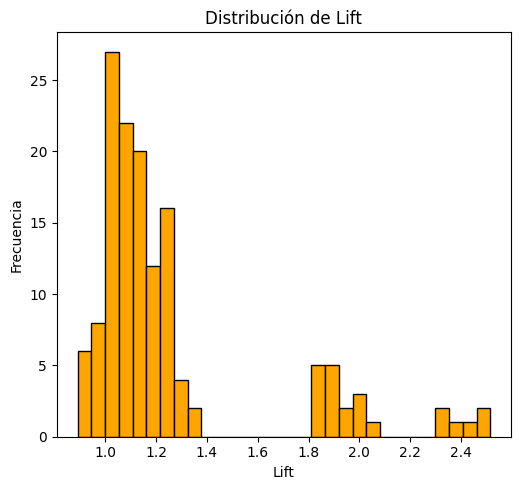

In [465]:
# Crear un histograma de soporte
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(rules_ap['support'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución de Soporte')
plt.xlabel('Soporte')
plt.ylabel('Frecuencia')

# Crear un histograma de confianza
plt.subplot(1, 2, 2)
plt.hist(rules_ap['confidence'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribución de Confianza')
plt.xlabel('Confianza')
plt.ylabel('Frecuencia')

# Crear un histograma de lift
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.hist(rules_ap['lift'], bins=30, color='orange', edgecolor='black')
plt.title('Distribución de Lift')
plt.xlabel('Lift')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


## Árbol de decisión

In [466]:
seleccion = ['DistanciaReal_km', 'TiempoEstimadoSis_h', 'TiempoEstimadoPersona_h', 'TiempoReal_h', 'NumConductores']
paraArbol = df.drop_duplicates(subset='IdRuta')[seleccion].dropna()
paraArbol["NumConductores"] = paraArbol.apply(lambda row: e_conductores(row), axis=1)
paraArbol

DistanciaReal_km  TiempoEstimadoSis_h  TiempoEstimadoPersona_h  \
0               634.605                24.00                    24.00   
11              838.591                15.00                    15.00   
18              820.086                11.00                    11.00   
30              336.978                14.00                    14.00   
38              619.007                35.00                    35.00   
...                 ...                  ...                      ...   
52366           880.224                49.75                    49.75   
52378          1206.133                47.00                    47.00   
52398           870.473                15.75                    15.75   
52404            27.213                15.75                    15.75   
52430           468.954                38.00                    38.00   

       TiempoReal_h  NumConductores  
0              0.00     UnConductor  
11            12.14  DosConductores  
18            10.48     UnConductor  
30             8.32  DosConductores  
38            18.58  DosConductores  
...             ...             ...  
52366         29.39  DosConductores  
52378         55.34  DosConductores  
52398         11.91  DosConductores  
52404          0.10  DosConductores  
52430          8.56  DosConductores  

[6839 rows x 5 columns]

In [467]:
X = paraArbol.drop(columns=['NumConductores'])  # Características
y = paraArbol['NumConductores']  # Variable objetivo que quieres predecir

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Creación del modelo
# ------------------------------------------------------------------------------
modelo = DecisionTreeClassifier(
            max_depth         = 4,
            random_state      = 123
          )

# Entrenamiento del modelo
# ------------------------------------------------------------------------------
modelo.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=123)

Profundidad del árbol: 4
Número de nodos terminales: 16


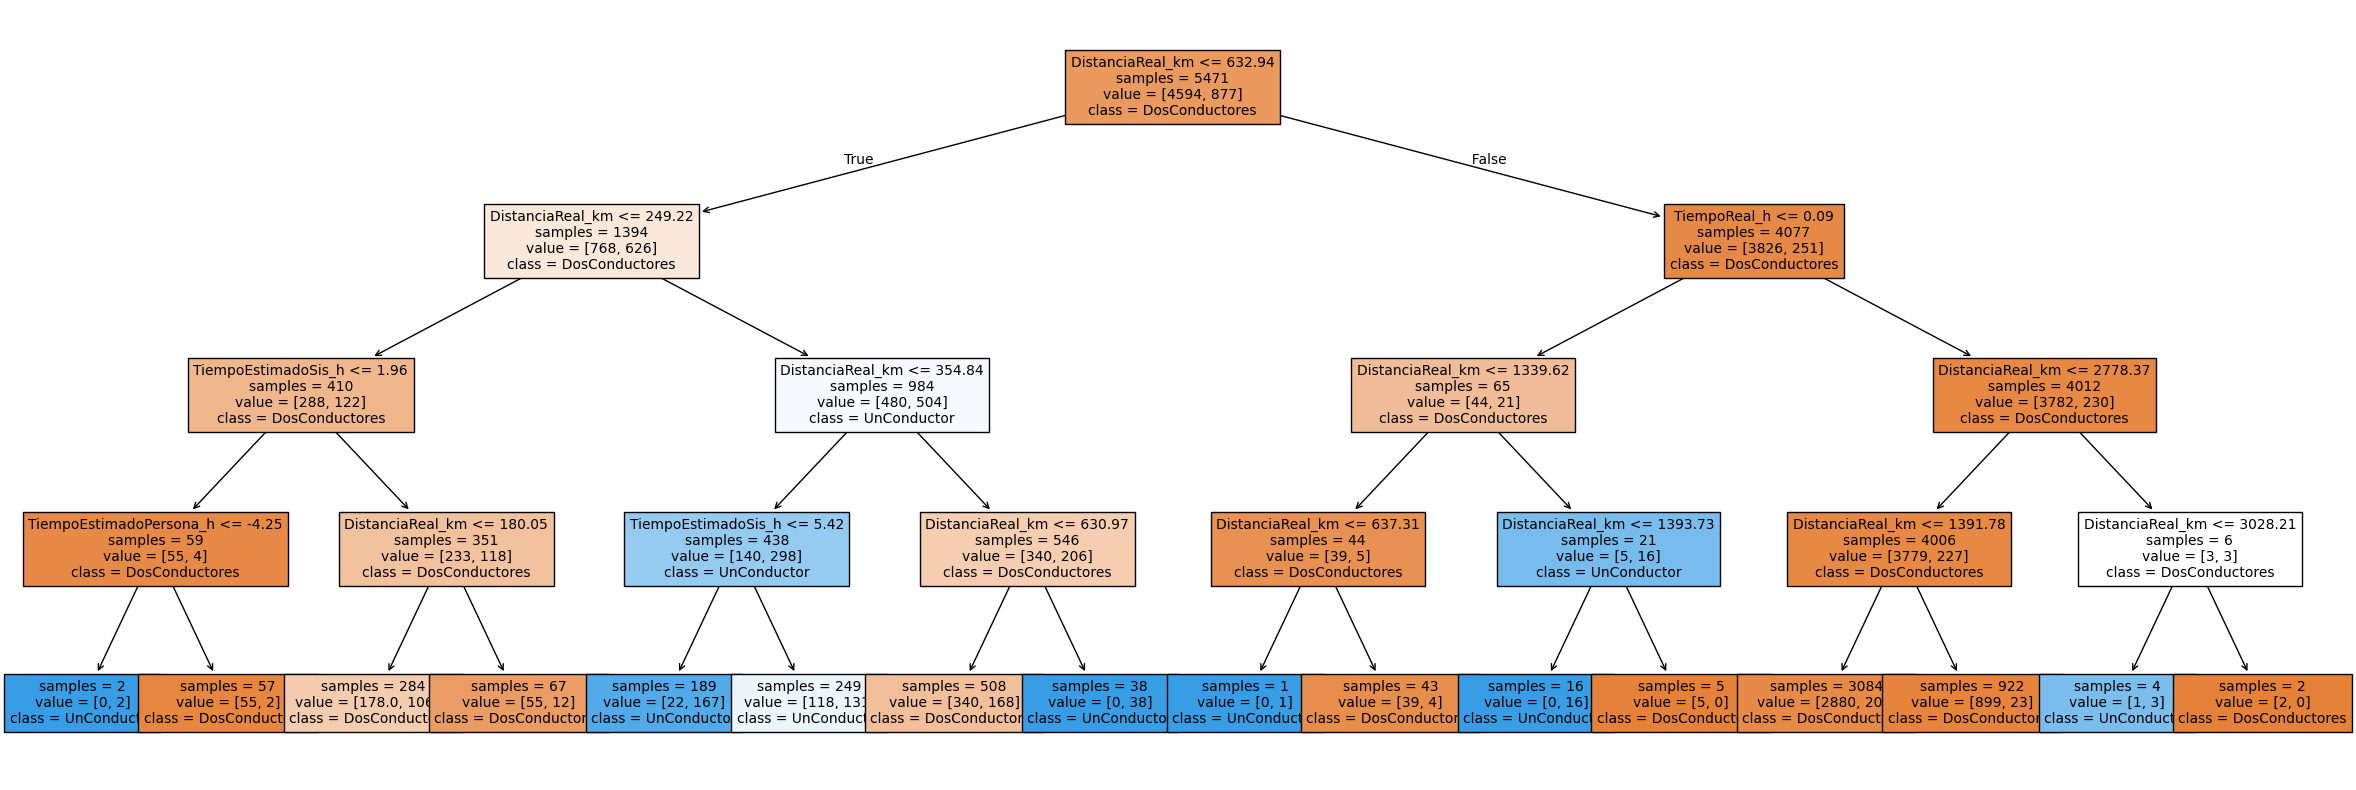

In [468]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(30, 10))

print(f"Profundidad del árbol: {modelo.get_depth()}")
print(f"Número de nodos terminales: {modelo.get_n_leaves()}")

plot = plot_tree(
            decision_tree = modelo,
            feature_names = paraArbol.columns,
            class_names   = modelo.classes_,
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

In [469]:
modelo.classes_

array(['DosConductores', 'UnConductor'], dtype=object)

# Final